In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from pathlib import Path
import hashlib
import json

import numpy as np
import pandas as pd

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.stattools import coint


# ============================================================
# Config
# ============================================================

@dataclass(frozen=True)
class PairSelectionConfig:
    # --- clustering ---
    k_min: int = 2
    k_max: int = 10
    mds_dim: int = 5
    random_state: int = 42

    # --- cointegration ---
    alpha: float = 0.05
    min_obs: int = 252
    max_pairs_per_cluster: Optional[int] = None

    # --- preprocessing ---
    series_kind: str = "log_price"     # price | log_price | cumret
    normalize_for_dtw: str = "zscore"  # zscore | none
    dropna_how: str = "inner"          # inner | outer

    # --- dtw ---
    use_tslearn: bool = True

    # --- caching ---
    cache_dir: str = "data/.cache_pairs"   
    cache: bool = True                    


# ============================================================
# Public API
# ============================================================

def select_pairs_from_wide_df(
    X0: pd.DataFrame,
    cfg: Optional[PairSelectionConfig] = None,
    top_k: int = 3,
    method: str = "optimal",
) -> pd.DataFrame:
    """
    Input:
        wide df (index=Date, columns=tickers)

    Output:
        best top_k pairs
    """
    cfg = cfg or PairSelectionConfig()

    # --- prefilter ---
    keep = [
        c for c in X0.columns
        if X0[c].dropna().shape[0] >= cfg.min_obs
        and X0[c].nunique() > 1
    ]
    X0 = X0[keep]
    if X0.shape[1] < 3:
        return pd.DataFrame()

    X, tickers = _to_matrix(X0, cfg)

    # --- cache key (stable) ---
    cache_paths = _get_cache_paths(X0, tickers, cfg)

    # --- DTW distances (cached) ---
    D = _load_npy(cache_paths["dtw"]) if cfg.cache else None
    if D is None:
        D = _dtw_distance_matrix(X, cfg)
        if cfg.cache:
            _save_npy(cache_paths["dtw"], D)

    # --- MDS embedding (cached) ---
    Z = _load_npy(cache_paths["mds"]) if cfg.cache else None
    if Z is None:
        Z = _mds_embedding(D, cfg)
        if cfg.cache:
            _save_npy(cache_paths["mds"], Z)

    # --- clustering ---
    labels = _cluster_from_embedding(Z, cfg)

    # --- cointegration within clusters ---
    pairs = _cointegration_pairs(X, tickers, labels, cfg)

    # --- top k selection (tradability + score) ---
    return select_top_k_pairs(pairs, X, k=top_k, method=method, alpha=cfg.alpha)


# ============================================================
# Preprocessing
# ============================================================

def _to_matrix(df: pd.DataFrame, cfg: PairSelectionConfig) -> Tuple[pd.DataFrame, List[str]]:
    if cfg.dropna_how == "inner":
        df = df.dropna(how="any")
    else:
        df = df.sort_index().interpolate(method="time").ffill().bfill()

    if cfg.series_kind == "log_price":
        df = np.log(df.where(df > 0))
    elif cfg.series_kind == "cumret":
        df = (1.0 + df.pct_change()).cumprod()

    if cfg.normalize_for_dtw == "zscore":
        df = (df - df.mean()) / df.std(ddof=0)
        df = df.replace([np.inf, -np.inf], np.nan).dropna(how="any")

    return df, list(df.columns)


# ============================================================
# DTW
# ============================================================

def _dtw_distance_matrix(X: pd.DataFrame, cfg: PairSelectionConfig) -> np.ndarray:
    data = X.values

    if cfg.use_tslearn:
        try:
            from tslearn.metrics import cdist_dtw
            series = data.T[:, :, None]  # (N, T, 1)
            # n_jobs existe selon versions tslearn -> on tente
            try:
                return cdist_dtw(series, n_jobs=-1)
            except TypeError:
                return cdist_dtw(series)
        except Exception:
            pass

    # fallback simple dtw (lent) - mais ton cas normal utilise tslearn
    def dtw(a, b):
        n, m = len(a), len(b)
        dp = np.full((n + 1, m + 1), np.inf)
        dp[0, 0] = 0.0
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = (a[i - 1] - b[j - 1]) ** 2
                dp[i, j] = cost + min(dp[i - 1, j], dp[i, j - 1], dp[i - 1, j - 1])
        return float(np.sqrt(dp[n, m]))

    N = data.shape[1]
    D = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i + 1, N):
            d = dtw(data[:, i], data[:, j])
            D[i, j] = D[j, i] = d
    return D


# ============================================================
# MDS embedding
# ============================================================

def _mds_embedding(D: np.ndarray, cfg: PairSelectionConfig) -> np.ndarray:
    mds = MDS(
        n_components=cfg.mds_dim,
        dissimilarity="precomputed",
        random_state=cfg.random_state,
        n_init=4,
        max_iter=300,
    )
    return mds.fit_transform(D)


# ============================================================
# Clustering
# ============================================================

def _cluster_from_embedding(Z: np.ndarray, cfg: PairSelectionConfig) -> np.ndarray:
    best_score = -np.inf
    best_labels = None

    k_min = max(2, cfg.k_min)
    k_max = min(cfg.k_max, Z.shape[0] - 1)

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=cfg.random_state)
        labels = km.fit_predict(Z)
        try:
            score = silhouette_score(Z, labels)
        except Exception:
            score = -np.inf

        if score > best_score:
            best_score = score
            best_labels = labels

    if best_labels is None:
        raise RuntimeError("Clustering failed (silhouette).")

    return best_labels
# ============================================================
# Correlation
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def drop_highly_correlated_columns(
    df: pd.DataFrame,
    k: float = 0.9995,
    method: str = "logret",   # "logret" or "level"
    min_obs: int = 252,
    plot: bool = True,
    title: str = None,
):
    """
    Retourne:
      - df_kept : df avec colonnes filtrées (on garde 1 colonne par groupe corr>k)
      - corr    : matrice de corr utilisée
      - dropped : liste des colonnes supprimées

    Règle:
      - on calcule la corr
      - on parcourt la matrice (triangle supérieur)
      - si corr(i,j) > k, on drop la colonne "j" (ou celle que tu veux)
    """

    X = df.copy()

    # 1) construire la matrice pour corr
    if method == "logret":
        Xc = np.log(X).diff()
    elif method == "level":
        Xc = X.copy()
    else:
        raise ValueError("method must be 'logret' or 'level'")

    # garder seulement obs suffisantes
    Xc = Xc.replace([np.inf, -np.inf], np.nan)
    Xc = Xc.dropna(axis=0, how="any")

    # garde-fou
    if Xc.shape[0] < min_obs or Xc.shape[1] < 2:
        return df, pd.DataFrame(), []

    corr = Xc.corr()

    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr.values, aspect="auto") 
        ax.set_title(title or f"Correlation matrix ({method})")
        ax.set_xticks(range(len(corr.columns)))
        ax.set_yticks(range(len(corr.columns)))
        ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
        ax.set_yticklabels(corr.columns, fontsize=7)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
    
    # 2) parcourir la matrice et dropper
    to_drop = set()
    cols = corr.columns.tolist()

    for i in range(len(cols)):
        if cols[i] in to_drop:
            continue
        for j in range(i + 1, len(cols)):
            if cols[j] in to_drop:
                continue
            if abs(corr.iloc[i, j]) > k:
                # règle simple: on drop j
                to_drop.add(cols[j])

    dropped = sorted(to_drop)
    kept = [c for c in df.columns if c not in to_drop]

    return df[kept], corr, dropped


# ============================================================
# Cointegration
# ============================================================

def _cointegration_pairs(X: pd.DataFrame, tickers: List[str], labels: np.ndarray, cfg: PairSelectionConfig) -> pd.DataFrame:
    results = []
    clusters: Dict[int, List[int]] = {}

    for i, l in enumerate(labels):
        clusters.setdefault(int(l), []).append(i)

    for cl, idxs in clusters.items():
        if len(idxs) < 2:
            continue
        for a in range(len(idxs)):
            for b in range(a + 1, len(idxs)):

                s1 = X.iloc[:, idxs[a]]
                s2 = X.iloc[:, idxs[b]]
                df2 = pd.concat([s1, s2], axis=1).dropna()

                if len(df2) < cfg.min_obs:
                    continue
                if df2.iloc[:,0].corr(df2.iloc[:,1]) > 0.999:
                    continue

                try:
                    stat, pval, _ = coint(df2.iloc[:, 0], df2.iloc[:, 1])
                except Exception:
                    continue

                if pval <= cfg.alpha:
                    results.append({
                        "cluster": cl,
                        "ticker_1": tickers[idxs[a]],
                        "ticker_2": tickers[idxs[b]],
                        "pvalue": float(pval),
                        "coint_stat": float(stat),
                        "n_obs": int(len(df2)),
                    })

    out = pd.DataFrame(results)
    if out.empty:
        return out

    out = out.sort_values(["cluster", "pvalue"], ascending=[True, True]).reset_index(drop=True)

    if cfg.max_pairs_per_cluster is not None:
        out = out.groupby("cluster", group_keys=False).head(cfg.max_pairs_per_cluster).reset_index(drop=True)

    return out


# ============================================================
# Tradability + scoring (inchangé vs ton style)
# ============================================================

def _half_life(spread: pd.Series) -> float:
    spread = spread.dropna()
    if len(spread) < 50:
        return np.inf

    ds = spread.diff().dropna()
    lag = spread.shift(1).loc[ds.index]
    b = np.polyfit(lag.values, ds.values, 1)[0]

    if not np.isfinite(b) or b >= 0:
        return np.inf
    return float(-np.log(2) / b)


def select_top_k_pairs(pairs_df: pd.DataFrame, X: pd.DataFrame, k: int = 3, method: str = "greedy", alpha: float = 0.05) -> pd.DataFrame:
    if pairs_df.empty:
        return pairs_df

    df = pairs_df.copy()

    hl, stds = [], []
    for _, r in df.iterrows():
        a, b = r["ticker_1"], r["ticker_2"]
        y, x = X[a], X[b]

        # OLS y ~ x + c
        Xreg = np.column_stack([np.ones_like(x.values), x.values])
        beta = np.linalg.lstsq(Xreg, y.values, rcond=None)[0]
        spread = y.values - (Xreg @ beta)
        spread = pd.Series(spread, index=y.index)

        hl.append(_half_life(spread))
        stds.append(float(np.nanstd(spread.values, ddof=0)))

    df["half_life"] = hl
    df["spread_std"] = stds

    df = df[(df["half_life"] < 120) & (df["spread_std"] > 0) & (df["pvalue"] <= alpha)].copy()

    if df.empty:
        return df

    df["score"] = -np.log(df["pvalue"].clip(1e-12, 1.0)) + df["spread_std"] - df["half_life"] / 100.0
    df = df.sort_values("score", ascending=False)

    used = set()
    chosen = []
    for _, r in df.iterrows():
        a, b = r["ticker_1"], r["ticker_2"]
        if a in used or b in used:
            continue
        chosen.append(r)
        used.add(a); used.add(b)
        if len(chosen) >= k:
            break

    return pd.DataFrame(chosen).reset_index(drop=True)


# ============================================================
# Cache helpers
# ============================================================

def _get_cache_paths(X0: pd.DataFrame, tickers: List[str], cfg: PairSelectionConfig) -> Dict[str, Path]:
    cache_dir = Path(cfg.cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    meta = {
        "tickers": tickers,
        "shape": list(X0.shape),
        "start": str(pd.to_datetime(X0.index.min()).date()) if len(X0.index) else None,
        "end": str(pd.to_datetime(X0.index.max()).date()) if len(X0.index) else None,
        "cfg": {
            "k_min": cfg.k_min, "k_max": cfg.k_max, "mds_dim": cfg.mds_dim, "random_state": cfg.random_state,
            "alpha": cfg.alpha, "min_obs": cfg.min_obs, "max_pairs_per_cluster": cfg.max_pairs_per_cluster,
            "series_kind": cfg.series_kind, "normalize_for_dtw": cfg.normalize_for_dtw, "dropna_how": cfg.dropna_how,
            "use_tslearn": cfg.use_tslearn,
        }
    }
    key = hashlib.sha1(json.dumps(meta, sort_keys=True).encode("utf-8")).hexdigest()[:16]

    return {
        "dtw": cache_dir / f"dtw_{key}.npy",
        "mds": cache_dir / f"mds_{key}.npy",
    }


def _save_npy(path: Path, arr: np.ndarray) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    np.save(path, arr)


def _load_npy(path: Path) -> Optional[np.ndarray]:
    if path.exists():
        return np.load(path, allow_pickle=False)
    return None


In [ ]:
base = Path("../data")

files = {
    "crypto": base / "crypto.xlsx",
    "commodities": base / "commodities.xlsx",
    "tech": base / "tech.xlsx",
}

base_cfg = PairSelectionConfig(
    k_min=2,
    k_max=10,
    mds_dim=5,
    alpha=0.05,
    min_obs=252,
    series_kind="log_price",
    normalize_for_dtw="zscore",
    dropna_how="inner",
    use_tslearn=True,
    cache=True,                    
    cache_dir="../data/.cache_pairs", 
)

pairs_by_class = {}

for name, path in files.items():
    cfg = replace(base_cfg, alpha=0.15) if name == "crypto" else base_cfg

    df = pd.read_excel(path, index_col="Date", parse_dates=True)
    df_filtered, corr, dropped = drop_highly_correlated_columns(
    df,
    k=0.9995,
    method="logret",
    plot=True,
    title=f"{name.capitalize()} corr (log-returns)"
)

    print("Dropped:", dropped)
    pairs = select_pairs_from_wide_df(df_filtered, cfg=cfg, top_k=3, method="greedy")

    pairs_by_class[name] = pairs
    pairs.to_csv(base / f"pairs_{name}.csv", index=False)

    print(f"{name}: {len(pairs)} pairs saved")

# Zhang Paper Analysis - Multi-Asset Pairs Trading Backtest

Analyse in-sample / out-of-sample pour **3 classes d'actifs** avec **3 paires chacune**:
- **In-sample**: 2019-01-01 → 2023-12-31
- **Out-of-sample**: 2024-01-01 → 2025-12-31

(avec **Numba** pour accélération)

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from dataclasses import dataclass, replace
from typing import Tuple, Optional, List, Dict
from pathlib import Path
import time
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

try:
    from numba import njit
    NUMBA_AVAILABLE = True
    print("Numba disponible - calculs accélérés")
except ImportError:
    NUMBA_AVAILABLE = False
    print("Numba non disponible - utilisation NumPy")
    def njit(*args, **kwargs):
        def decorator(func):
            return func
        if len(args) == 1 and callable(args[0]):
            return args[0]
        return decorator


✅ Numba disponible - calculs accélérés


In [ ]:
@njit(cache=True)
def halton_sequence_njit(size: int, base: int) -> np.ndarray:
    sequence = np.zeros(size)
    for i in range(size):
        n = i + 1
        f, result = 1.0, 0.0
        while n > 0:
            f = f / base
            result = result + f * (n % base)
            n = n // base
        sequence[i] = result
    return sequence


@njit(cache=True)
def kalman_filter_njit(y: np.ndarray, theta0: float, theta1: float,
                       q: float, r: float) -> Tuple[float, np.ndarray]:
    n = len(y)

    if abs(theta1) < 0.999:
        x = theta0 / (1.0 - theta1)
        P = q / (1.0 - theta1 * theta1)
    else:
        x = y[0]
        P = q * 10.0

    x_filt = np.zeros(n)
    loglik = 0.0
    log_2pi = np.log(2.0 * np.pi)

    for t in range(n):
        if t > 0:
            x = theta0 + theta1 * x
            P = theta1 * theta1 * P + q

        v = y[t] - x
        S = P + r

        if S > 1e-12:
            K = P / S
            x = x + K * v
            P = (1.0 - K) * P
            loglik += -0.5 * (log_2pi + np.log(S) + v * v / S)

        x_filt[t] = x

    return loglik, x_filt


@njit(cache=True)
def qmckf_njit(y: np.ndarray, theta0: float, theta1: float,
               q_base: float, q_het: float, r: float,
               n_particles: int) -> Tuple[float, np.ndarray]:
    n = len(y)
    x = y[0]
    P = q_base + q_het * x * x

    x_filt = np.zeros(n)
    loglik = 0.0
    log_2pi = np.log(2.0 * np.pi)

    h1 = halton_sequence_njit(n_particles, 2)
    h2 = halton_sequence_njit(n_particles, 3)

    for i in range(n_particles):
        h1[i] = max(1e-10, min(1.0 - 1e-10, h1[i]))
        h2[i] = max(1e-10, min(1.0 - 1e-10, h2[i]))

    z = np.zeros(n_particles)
    for i in range(n_particles):
        z[i] = np.sqrt(-2.0 * np.log(h1[i])) * np.cos(2.0 * np.pi * h2[i])

    samples = np.zeros(n_particles)
    f_samples = np.zeros(n_particles)

    for t in range(n):
        if t == 0:
            x_p, P_p = x, P
        else:
            sqrt_P = np.sqrt(max(P, 1e-12))
            sum_f = 0.0
            for i in range(n_particles):
                samples[i] = x + sqrt_P * z[i]
                f_samples[i] = theta0 + theta1 * samples[i]
                sum_f += f_samples[i]
            x_p = sum_f / n_particles

            sum_var, sum_g = 0.0, 0.0
            for i in range(n_particles):
                diff = f_samples[i] - x_p
                sum_var += diff * diff
                sum_g += q_base + q_het * samples[i] * samples[i]
            P_p = sum_var / n_particles + sum_g / n_particles

        v = y[t] - x_p
        S = P_p + r

        if S > 1e-12:
            K = P_p / S
            x = x_p + K * v
            P = (1.0 - K) * P_p
            loglik += -0.5 * (log_2pi + np.log(S) + v * v / S)
        else:
            x, P = x_p, P_p

        x_filt[t] = x

    return loglik, x_filt


@njit(cache=True)
def strategy_A_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: float) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(n):
        if pos == 0:
            if x[t] >= U[t]:
                pos = -1
            elif x[t] <= L[t]:
                pos = 1
        elif pos == 1 and x[t] >= C:
            pos = 0
        elif pos == -1 and x[t] <= C:
            pos = 0
        sig[t] = pos

    return sig


@njit(cache=True)
def strategy_C_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: float) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(1, n):
        prev, curr = x[t - 1], x[t]
        U_prev, U_curr = U[t - 1], U[t]
        L_prev, L_curr = L[t - 1], L[t]

        entry_short = (prev > U_prev) and (curr <= U_curr)
        entry_long = (prev < L_prev) and (curr >= L_curr)
        exit_long = (prev < C) and (curr >= C)
        exit_short = (prev > C) and (curr <= C)
        stop_short = (prev < U_prev) and (curr >= U_curr)
        stop_long = (prev > L_prev) and (curr <= L_curr)

        if pos == 0:
            if entry_short:
                pos = -1
            elif entry_long:
                pos = 1
        elif pos == 1 and (exit_long or stop_long):
            pos = 0
        elif pos == -1 and (exit_short or stop_short):
            pos = 0

        sig[t] = pos

    return sig


@njit(cache=True)
def backtest_njit(signals: np.ndarray, x_filt: np.ndarray, cost_bp: float) -> Tuple[float, float, int]:
    n = len(signals)
    pnl = np.zeros(n)

    n_trades = 0
    cost_factor = 2.0 * cost_bp / 10000.0

    for t in range(1, n):
        dx = x_filt[t] - x_filt[t - 1]
        pos_change = abs(signals[t] - signals[t - 1])
        if pos_change > 0:
            n_trades += 1
        pnl[t] = signals[t] * dx - pos_change * cost_factor

    cum_pnl = np.sum(pnl)
    ann_ret = cum_pnl / (n / 252.0)

    std_pnl = np.std(pnl)
    ann_std = std_pnl * np.sqrt(252.0)

    sharpe = (ann_ret - 0.02) / ann_std if ann_std > 1e-12 else 0.0
    return ann_ret, sharpe, n_trades




✅ Core functions OK


In [ ]:
@njit(cache=True)
def grid_search_select_nstd_is_njit(
    x_filt_is,
    q_base,
    q_het,
    is_hetero,
    use_strategy_C,
    cost_bp
):
    best_n = 1.0
    best_ret = 0.0
    best_sr = -1e10
    best_trades = 0
    found = 0  

    for i in range(25):
        n_std = 0.1 + 0.1 * i

        U, L, C = compute_thresholds_is_static_njit(x_filt_is, q_base, q_het, n_std, is_hetero)

        if use_strategy_C:
            sig = strategy_C_njit(x_filt_is, U, L, C)
        else:
            sig = strategy_A_njit(x_filt_is, U, L, C)

        ann_ret, sharpe, n_trades = backtest_njit(sig, x_filt_is, cost_bp)

        # on accepte même si n_trades==0, mais on privilégie les configs qui tradent : score = sharpe - penalité_no_trade
        score = sharpe
        if n_trades == 0:
            score = sharpe - 3.0  #  pénalité

        if score > best_sr:
            best_sr = score
            best_ret = ann_ret
            best_n = n_std
            best_trades = n_trades
            found = 1

    # si rien trouvé (plutot rare), on renvoie quelque chose de safe
    if found == 0 or best_sr <= -1e9:
        return 1.0, 0.0, 0.0, 0

    # IMPORTANT: best_sr est un "score" si pénalité appliquée
    # on recalcule le VRAI sharpe du best_n pour retourner un sharpe propre
    U, L, C = compute_thresholds_is_static_njit(x_filt_is, q_base, q_het, best_n, is_hetero)
    if use_strategy_C:
        sig = strategy_C_njit(x_filt_is, U, L, C)
    else:
        sig = strategy_A_njit(x_filt_is, U, L, C)
    ann_ret, sharpe, n_trades = backtest_njit(sig, x_filt_is, cost_bp)

    return best_n, ann_ret, sharpe, n_trades


In [ ]:
@njit(cache=True)
def compute_thresholds_njit(x_filt: np.ndarray, q_base: float, q_het: float,
                            n_std: float, is_hetero: bool) -> Tuple[np.ndarray, np.ndarray, float]:
    """Alias pour compatibilité grid_search"""
    return compute_thresholds_is_static_njit(x_filt, q_base, q_het, n_std, is_hetero)


@njit(cache=True)
def compute_thresholds_is_static_njit(
    x_filt: np.ndarray,
    q_base: float,
    q_het: float,
    n_std: float,
    is_hetero: bool
) -> Tuple[np.ndarray, np.ndarray, float]:
    n = len(x_filt)
    C = float(np.mean(x_filt))  
    sigma_emp = np.std(x_filt)

    U = np.empty(n)
    L = np.empty(n)

    if is_hetero and q_het > 1e-10:
        g_x = np.sqrt(q_base + q_het * x_filt * x_filt)
        mean_g = np.mean(g_x) if n > 0 else 1.0
        if mean_g < 1e-12:
            mean_g = 1.0
        for t in range(n):
            sigma_t = g_x[t] / mean_g * sigma_emp
            U[t] = C + n_std * sigma_t
            L[t] = C - n_std * sigma_t
    else:
        thr = n_std * sigma_emp
        for t in range(n):
            U[t] = C + thr
            L[t] = C - thr

    return U, L, C


In [ ]:
@njit(cache=True)
def compute_thresholds_oos_expanding_njit(
    x_filt_is,        
    x_filt_oos,     
    q_base,
    q_het,
    n_std,
    is_hetero
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Seuils OOS en expanding (sans look-ahead):
      - stats(t) calculées sur l'historique disponible AVANT d'intégrer x_oos[t]
      - puis update avec x_oos[t] pour t+1

    IMPORTANT:
      - Ici, en hetero, on utilise gx(x_oos[t]) pour sigma_t (info de t).
        C'est OK si ton signal est calculé à t pour exécution à t+1.
    """
    n_is = len(x_filt_is)
    n_oos = len(x_filt_oos)

    U = np.zeros(n_oos)
    L = np.zeros(n_oos)
    C = np.zeros(n_oos)

    mean = 0.0
    M2 = 0.0
    count = 0

    for i in range(n_is):
        count += 1
        delta = x_filt_is[i] - mean
        mean += delta / count
        delta2 = x_filt_is[i] - mean
        M2 += delta * delta2

    # mean_g sur IS (fixe)
    mean_g = 1.0
    if is_hetero and q_het > 1e-12 and n_is > 0:
        gsum = 0.0
        for i in range(n_is):
            gsum += np.sqrt(q_base + q_het * x_filt_is[i] * x_filt_is[i])
        mean_g = gsum / n_is

    for t in range(n_oos):
        # std basée sur historique dispo avant d'utiliser x_filt_oos[t]
        var = (M2 / count) if count > 1 else 1e-12
        std = np.sqrt(max(var, 1e-12))

        C[t] = mean

        if is_hetero and q_het > 1e-12:
            gx = np.sqrt(q_base + q_het * x_filt_oos[t] * x_filt_oos[t])
            sigma_t = gx / mean_g * std
            U[t] = mean + n_std * sigma_t
            L[t] = mean - n_std * sigma_t
        else:
            thr = n_std * std
            U[t] = mean + thr
            L[t] = mean - thr

        xnew = x_filt_oos[t]
        count += 1
        delta = xnew - mean
        mean += delta / count
        delta2 = xnew - mean
        M2 += delta * delta2

    return U, L, C


In [ ]:
@dataclass
class ModelParams:
    theta0: float = 0.0
    theta1: float = 0.95
    q_base: float = 1e-4
    q_het: float = 0.0
    r: float = 1e-4


def estimate_gamma_ols(log_PA: np.ndarray, log_PB: np.ndarray) -> float:
    """
    Estimate γ via OLS on log-prices:
        log(PA) = a + γ log(PB) + eps
    Returns: γ
    """
    X = np.column_stack([np.ones(len(log_PB)), log_PB])
    return float(np.linalg.lstsq(X, log_PA, rcond=None)[0][1])



def estimate_model_I(y: np.ndarray) -> Tuple[ModelParams, np.ndarray, float]:
    y_mean, y_var = np.mean(y), np.var(y)
    rho = np.corrcoef(y[:-1] - y_mean, y[1:] - y_mean)[0, 1]
    theta1_init = float(np.clip(rho, 0.8, 0.99))

    z0 = np.array([
        y_mean * (1 - theta1_init),
        np.arctanh(theta1_init),
        np.log(y_var * (1 - theta1_init ** 2) * 0.7 + 1e-10),
        np.log(y_var * 0.3 + 1e-10),
    ])

    def neg_ll(z):
        ll, _ = kalman_filter_njit(y, z[0], np.tanh(z[1]), np.exp(z[2]), np.exp(z[3]))
        return -ll if np.isfinite(ll) else 1e10

    bounds = [(-0.5, 0.5),
              (np.arctanh(0.5), np.arctanh(0.999)),
              (np.log(1e-8), np.log(1.0)),
              (np.log(1e-8), np.log(1.0))]

    res = minimize(neg_ll, z0, method='L-BFGS-B', bounds=bounds)

    params = ModelParams(
        theta0=float(res.x[0]),
        theta1=float(np.tanh(res.x[1])),
        q_base=float(np.exp(res.x[2])),
        r=float(np.exp(res.x[3])),
        q_het=0.0
    )

    ll, x_filt = kalman_filter_njit(y, params.theta0, params.theta1, params.q_base, params.r)
    return params, x_filt, float(ll)


def estimate_model_II(y: np.ndarray) -> Tuple[ModelParams, np.ndarray, float]:
    y_mean = float(np.mean(y))
    best_ll, best_params, best_filt = -np.inf, None, None

    for t0, t1, q_b, q_h, r in [
        (y_mean * 0.01, 0.95, 0.0005, 0.10, 0.010),
        (y_mean * 0.01, 0.93, 0.0003, 0.13, 0.011),
        (y_mean * 0.01, 0.96, 0.0010, 0.08, 0.008),
    ]:
        z0 = np.array([t0, np.arctanh(t1), np.log(q_b), np.log(q_h), np.log(r)])

        def neg_ll(z):
            ll, _ = qmckf_njit(y, z[0], np.tanh(z[1]), np.exp(z[2]), np.exp(z[3]), np.exp(z[4]), 50)
            return -ll if np.isfinite(ll) else 1e10

        bounds = [(-0.1, 0.1),
                  (np.arctanh(0.85), np.arctanh(0.99)),
                  (np.log(1e-6), np.log(0.005)),
                  (np.log(0.05), np.log(0.3)),
                  (np.log(0.005), np.log(0.05))]

        try:
            res = minimize(neg_ll, z0, method='L-BFGS-B', bounds=bounds, options={'maxiter': 500})
            params = ModelParams(
                theta0=float(res.x[0]),
                theta1=float(np.tanh(res.x[1])),
                q_base=float(np.exp(res.x[2])),
                q_het=float(np.exp(res.x[3])),
                r=float(np.exp(res.x[4]))
            )
            ll, x_filt = qmckf_njit(y, params.theta0, params.theta1, params.q_base, params.q_het, params.r, 100)
            if ll > best_ll:
                best_ll, best_params, best_filt = float(ll), params, x_filt
        except Exception:
            continue

    if best_params is None:
        best_params = ModelParams(theta0=0.0, theta1=0.95, q_base=0.0003, q_het=0.1, r=0.01)
        ll, x_filt = qmckf_njit(y, best_params.theta0, best_params.theta1,
                                best_params.q_base, best_params.q_het, best_params.r, 100)
        best_ll, best_filt = float(ll), x_filt

    return best_params, best_filt, float(best_ll)

print("Estimation OK")


✅ Estimation OK


In [ ]:
def load_price_data_from_wide_excel(data_path: str, ticker: str) -> pd.Series:
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    if ticker not in df.columns:
        raise ValueError(f"{ticker} not in {data_path}")
    return df[ticker].dropna().sort_index()


def load_pairs_for_all_classes(asset_classes: Dict[str, str], top_k: int = 3) -> Dict[str, pd.DataFrame]:
    pairs_data = {}
    for asset_class in asset_classes.keys():
        pairs_path = Path("../data") / f"pairs_{asset_class}.csv"
        if pairs_path.exists():
            df = pd.read_csv(pairs_path).head(top_k)
            pairs_data[asset_class] = df
            print(f"{asset_class:15s}: {len(df)} paires")
        else:
            print(f"{asset_class:15s}: {pairs_path} non trouvé")
            pairs_data[asset_class] = pd.DataFrame()
    return pairs_data

In [ ]:
def analyze_pair_is_oos_clean(
    data_path: str,
    ticker_1: str,
    ticker_2: str,
    is_start: str,
    is_end: str,
    oos_start: str,
    oos_end: str,
    cost_bp: float = 20.0
) -> Tuple[Optional[Dict], Optional[Dict]]:

    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)

    if ticker_1 not in df.columns or ticker_2 not in df.columns:
        return None, None

    PA_full = df[ticker_1].dropna().sort_index()
    PB_full = df[ticker_2].dropna().sort_index()

    common = PA_full.index.intersection(PB_full.index)
    if len(common) < 400:
        return None, None

    PA_full = PA_full.loc[common]
    PB_full = PB_full.loc[common]

    # --- IS slice
    is_mask = (PA_full.index >= pd.Timestamp(is_start)) & (PA_full.index <= pd.Timestamp(is_end))
    PA_is = PA_full.loc[is_mask]
    PB_is = PB_full.loc[is_mask]
    if len(PA_is) < 252:
        return None, None

    log_PA_is = np.log(PA_is.values)
    log_PB_is = np.log(PB_is.values)

    gamma_is = estimate_gamma_ols(log_PA_is, log_PB_is)
    y_is = log_PA_is - gamma_is * log_PB_is

    # Estimation sur IS
    p1_is, f1_is, _ = estimate_model_I(y_is)
    p2_is, f2_is, _ = estimate_model_II(y_is)

    # Grid-search sur IS uniquement (n_std)
    n1_is, ret_m1_is, sr_m1_is, tr_m1_is = grid_search_select_nstd_is_njit(
        f1_is, p1_is.q_base, 0.0, False, False, cost_bp
    )
    n2_is, ret_m2_is, sr_m2_is, tr_m2_is = grid_search_select_nstd_is_njit(
        f2_is, p2_is.q_base, p2_is.q_het, True, True, cost_bp
    )

    result_is = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "gamma_is": float(gamma_is),
        "M1_nstd": float(n1_is), "M1_Return": float(ret_m1_is), "M1_Sharpe": float(sr_m1_is), "M1_Trades": int(tr_m1_is),
        "M2_nstd": float(n2_is), "M2_Return": float(ret_m2_is), "M2_Sharpe": float(sr_m2_is), "M2_Trades": int(tr_m2_is),
        "N_IS": int(len(y_is))
    }

    oos_mask = (PA_full.index >= pd.Timestamp(oos_start)) & (PA_full.index <= pd.Timestamp(oos_end))
    PA_oos = PA_full.loc[oos_mask]
    PB_oos = PB_full.loc[oos_mask]
    if len(PA_oos) < 100:
        return result_is, None

    log_PA_oos = np.log(PA_oos.values)
    log_PB_oos = np.log(PB_oos.values)
    y_oos = log_PA_oos - gamma_is * log_PB_oos

    # Filtrage OOS avec params IS
    _, f1_oos = kalman_filter_njit(y_oos, p1_is.theta0, p1_is.theta1, p1_is.q_base, p1_is.r)
    _, f2_oos = qmckf_njit(y_oos, p2_is.theta0, p2_is.theta1, p2_is.q_base, p2_is.q_het, p2_is.r, 100)

    # Seuils OOS expanding (warm start IS)
    U1_oos, L1_oos, C1_oos = compute_thresholds_oos_expanding_njit(
        f1_is, f1_oos, p1_is.q_base, 0.0, float(n1_is), False
    )
    U2_oos, L2_oos, C2_oos = compute_thresholds_oos_expanding_njit(
        f2_is, f2_oos, p2_is.q_base, p2_is.q_het, float(n2_is), True
    )

    # Signals OOS (attention: stratégie C utilise t-1/t)
    sig1_oos = strategy_A_njit(f1_oos, U1_oos, L1_oos, C1_oos[0])  # C varie dans le temps, A utilise un C constant normalement
    # pour rester cohérent, on va trader avec C_t = C1_oos[t]. On fait une version dédiée ci-dessous.

    return result_is, {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "M1_nstd": float(n1_is),
        "M2_nstd": float(n2_is),
        "N_OOS": int(len(y_oos)),
        "NOTE": "OOS computed with expanding stats (no look-ahead). Next cell replaces signal logic to use time-varying C."
    }


In [ ]:
@njit(cache=True)
def strategy_A_timevaryingC_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0
    for t in range(n):
        if pos == 0:
            if x[t] >= U[t]:
                pos = -1
            elif x[t] <= L[t]:
                pos = 1
        elif pos == 1 and x[t] >= C[t]:
            pos = 0
        elif pos == -1 and x[t] <= C[t]:
            pos = 0
        sig[t] = pos
    return sig



@njit(cache=True)
def strategy_C_timevaryingC_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(1, n):
        prev, curr = x[t - 1], x[t]
        U_prev, U_curr = U[t - 1], U[t]
        L_prev, L_curr = L[t - 1], L[t]
        C_prev, C_curr = C[t - 1], C[t]

        entry_short = (prev > U_prev) and (curr <= U_curr)
        entry_long  = (prev < L_prev) and (curr >= L_curr)

        exit_long   = (prev < C_prev) and (curr >= C_curr)
        exit_short  = (prev > C_prev) and (curr <= C_curr)

        stop_short  = (prev < U_prev) and (curr >= U_curr)
        stop_long   = (prev > L_prev) and (curr <= L_curr)

        if pos == 0:
            if entry_short:
                pos = -1
            elif entry_long:
                pos = 1
        elif pos == 1 and (exit_long or stop_long):
            pos = 0
        elif pos == -1 and (exit_short or stop_short):
            pos = 0

        sig[t] = pos

    return sig


print("Strategies with time-varying C OK")


✅ Strategies with time-varying C OK


In [12]:
@njit(cache=True)
def backtest_with_signals_njit(signals: np.ndarray, x: np.ndarray, cost_bp: float) -> Tuple[float, float, int]:
    return backtest_njit(signals, x, cost_bp)


@njit(cache=True)
def evaluate_oos_expanding(
    f_is: np.ndarray,
    f_oos: np.ndarray,
    q_base: float,
    q_het: float,
    n_std: float,
    heteroscedastic: bool,
    use_strategy_C: bool,
    cost_bp: float
) -> Tuple[float, float, int]:
    """
    Backtest OOS avec thresholds expanding (évite look-ahead bias).
    """
    # Calculer thresholds expanding en passant IS et OOS séparément
    U_oos, L_oos, C_oos = compute_thresholds_oos_expanding_njit(
        f_is, f_oos, q_base, q_het, n_std, heteroscedastic
    )

    # Appliquer stratégie avec C time-varying
    if use_strategy_C:
        sig_oos = strategy_C_timevaryingC_njit(f_oos, U_oos, L_oos, C_oos)
    else:
        sig_oos = strategy_A_timevaryingC_njit(f_oos, U_oos, L_oos, C_oos)

    # Backtest avec coûts
    ret, sr, trades = backtest_njit(f_oos, sig_oos, cost_bp)

    return ret, sr, trades

In [ ]:
def analyze_pair_is_oos_FINAL(
    data_path: str,
    ticker_1: str,
    ticker_2: str,
    is_start: str,
    is_end: str,
    oos_start: str,
    oos_end: str,
    cost_bp: float = 20.0
) -> Tuple[Optional[Dict], Optional[Dict]]:
    """
    IS/OOS clean:
      - gamma estimé sur IS
      - modèles estimés sur IS
      - n_std sélectionné sur IS
      - OOS: paramètres IS appliqués
      - OOS: seuils expanding sans look-ahead (stats up to t-1), C time-varying
      - IMPORTANT: pour les tickers taux/index (peuvent être négatifs), on travaille en niveaux:
            y = PA - gamma * PB
        sinon en log:
            y = log(PA) - gamma * log(PB)
    """
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    if ticker_1 not in df.columns or ticker_2 not in df.columns:
        return None, None

    PA = df[ticker_1].dropna().sort_index()
    PB = df[ticker_2].dropna().sort_index()
    common = PA.index.intersection(PB.index)
    if len(common) < 400:
        return None, None
    PA, PB = PA.loc[common], PB.loc[common]

    # -------------------------
    # IN-SAMPLE
    # -------------------------
    is_mask = (PA.index >= pd.Timestamp(is_start)) & (PA.index <= pd.Timestamp(is_end))
    PA_is, PB_is = PA.loc[is_mask], PB.loc[is_mask]
    if len(PA_is) < 252:
        return None, None

    PA_is_v = PA_is.values
    PB_is_v = PB_is.values    
    log_PA_is = np.log(PA_is_v)
    log_PB_is = np.log(PB_is_v)
    gamma_is = estimate_gamma_ols(log_PA_is, log_PB_is)
    y_is = log_PA_is - gamma_is * log_PB_is

    # Estimation sur IS
    p1_is, f1_is, _ = estimate_model_I(y_is)
    p2_is, f2_is, _ = estimate_model_II(y_is)

    # Grid-search sur IS uniquement (n_std)
    n1_is, ret1_is, sr1_is, tr1_is = grid_search_select_nstd_is_njit(
        f1_is, p1_is.q_base, 0.0, False, False, cost_bp
    )
    n2_is, ret2_is, sr2_is, tr2_is = grid_search_select_nstd_is_njit(
        f2_is, p2_is.q_base, p2_is.q_het, True, True, cost_bp
    )

    result_is = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "gamma_is": float(gamma_is),
        "M1_nstd": float(n1_is), "M1_Return": float(ret1_is), "M1_Sharpe": float(sr1_is), "M1_Trades": int(tr1_is),
        "M2_nstd": float(n2_is), "M2_Return": float(ret2_is), "M2_Sharpe": float(sr2_is), "M2_Trades": int(tr2_is),
        "N_IS": int(len(y_is))
    }

    # -------------------------
    # OUT-OF-SAMPLE
    # -------------------------
    oos_mask = (PA.index >= pd.Timestamp(oos_start)) & (PA.index <= pd.Timestamp(oos_end))
    PA_oos, PB_oos = PA.loc[oos_mask], PB.loc[oos_mask]
    if len(PA_oos) < 100:
        return result_is, None

    PA_oos_v = PA_oos.values
    PB_oos_v = PB_oos.values

    y_oos = np.log(PA_oos_v) - gamma_is * np.log(PB_oos_v)

    # Filtrage OOS avec params IS
    _, f1_oos = kalman_filter_njit(y_oos, float(p1_is.theta0), float(p1_is.theta1), float(p1_is.q_base), float(p1_is.r))
    _, f2_oos = qmckf_njit(y_oos, float(p2_is.theta0), float(p2_is.theta1), float(p2_is.q_base), float(p2_is.q_het), float(p2_is.r), 100)

    # Backtests OOS (thresholds expanding + C time-varying)
    ret1_oos, sr1_oos, tr1_oos = evaluate_oos_expanding(
        f1_is, f1_oos, p1_is.q_base, 0.0, float(n1_is), False, False, cost_bp
    )
    ret2_oos, sr2_oos, tr2_oos = evaluate_oos_expanding(
        f2_is, f2_oos, p2_is.q_base, p2_is.q_het, float(n2_is), True, True, cost_bp
    )

    result_oos = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "M1_nstd": float(n1_is), "M1_Return": float(ret1_oos), "M1_Sharpe": float(sr1_oos), "M1_Trades": int(tr1_oos),
        "M2_nstd": float(n2_is), "M2_Return": float(ret2_oos), "M2_Sharpe": float(sr2_oos), "M2_Trades": int(tr2_oos),
        "N_OOS": int(len(y_oos)),
        "Improvement_Sharpe_%": float((sr2_oos / sr1_oos - 1) * 100) if abs(sr1_oos) > 1e-12 else np.nan,
        "Improvement_Return_%": float((ret2_oos / ret1_oos - 1) * 100) if abs(ret1_oos) > 1e-12 else np.nan
    }

    return result_is, result_oos


grid_search_njit = grid_search_select_nstd_is_njit
compute_thresholds_njit = compute_thresholds_is_static_njit

In [ ]:
# ============================================================================
# CONFIG + RUN IS/OOS ANALYSIS
# ============================================================================

IN_SAMPLE_START = "2019-01-01"
IN_SAMPLE_END   = "2023-12-31"
OUT_SAMPLE_START = "2024-01-01"
OUT_SAMPLE_END   = "2025-12-31"

ASSET_CLASSES_CONFIG = {
    "crypto": "../data/crypto.xlsx",
    "commodities": "../data/commodities.xlsx",
    "tech": "../data/tech.xlsx",
}

pairs_by_class = load_pairs_for_all_classes(ASSET_CLASSES_CONFIG, top_k=3)

all_is, all_oos = [], []
start = time.time()
k = 0

for asset_class, data_path in ASSET_CLASSES_CONFIG.items():
    pairs_df = pairs_by_class.get(asset_class, pd.DataFrame())
    if pairs_df is None or len(pairs_df) == 0:
        continue

    print(f"\n{asset_class.upper()} ({len(pairs_df)} pairs)")
    for _, row in pairs_df.iterrows():
        k += 1
        t1, t2 = row["ticker_1"], row["ticker_2"]

        try:
            res_is, res_oos = analyze_pair_is_oos_FINAL(
                data_path=data_path,
                ticker_1=t1, ticker_2=t2,
                is_start=IN_SAMPLE_START, is_end=IN_SAMPLE_END,
                oos_start=OUT_SAMPLE_START, oos_end=OUT_SAMPLE_END,
                cost_bp=20.0
            )
            if res_is is not None:
                res_is["Asset_Class"] = asset_class
                all_is.append(res_is)
            if res_oos is not None:
                res_oos["Asset_Class"] = asset_class
                all_oos.append(res_oos)

            if res_oos is not None:
                print(f"{t1} / {t2} | IS SR={res_is['M2_Sharpe']:.3f} | OOS SR={res_oos['M2_Sharpe']:.3f}")
            else:
                print(f"{t1} / {t2} | IS only")
        except Exception as e:
            print(f"{t1} / {t2} | {str(e)[:80]}")

elapsed = time.time() - start
df_is  = pd.DataFrame(all_is)
df_oos = pd.DataFrame(all_oos)

print(f"\n Total: {elapsed:.1f}s | pairs processed={k}")
print(f" IS rows: {len(df_is)} | OOS rows: {len(df_oos)}")

✅ crypto         : 3 paires
✅ commodities    : 3 paires
✅ tech           : 3 paires

📊 CRYPTO (3 pairs)


   ✅ XTH Curncy / XMN Curncy | IS SR=1.710 | OOS SR=0.007
   ✅ XLM Curncy / XLC Curncy | IS SR=1.613 | OOS SR=0.004
   ✅ XRP Curncy / XMR Curncy | IS SR=1.750 | OOS SR=0.129

📊 COMMODITIES (3 pairs)
   ✅ CL1 Comdty / CO1 Comdty | IS SR=0.000 | OOS SR=0.000
   ✅ W 1 Comdty / CT1 Comdty | IS SR=1.929 | OOS SR=-0.025
   ✅ NG1 Comdty / LX1 Comdty | IS SR=2.141 | OOS SR=0.002

📊 TECH (3 pairs)
   ✅ ADI US Equity / KLAC US Equity | IS SR=1.516 | OOS SR=-0.014
   ✅ NXPI US Equity / AMAT US Equity | IS SR=1.889 | OOS SR=-0.010
   ✅ TXN US Equity / HUBS US Equity | IS SR=1.515 | OOS SR=-0.001

⏱️ Total: 10.1s | pairs processed=9
✅ IS rows: 9 | ✅ OOS rows: 9



  IN-SAMPLE
Pairs: 9
Model I  mean Sharpe: 0.5187 | mean Return: 0.201881
Model II mean Sharpe: 1.5626 | mean Return: 0.455643

  OUT-OF-SAMPLE
Pairs: 9
Model I  mean Sharpe: -3.1117 | mean Return: 0.276745
Model II mean Sharpe: 0.0102 | mean Return: 0.190395


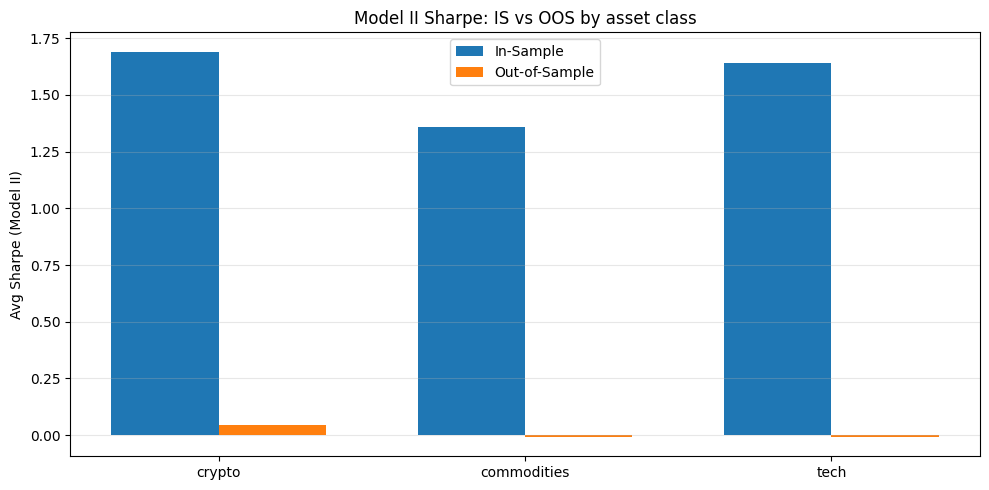

In [15]:
import matplotlib.pyplot as plt

def print_summary(df: pd.DataFrame, label: str):
    print("\n" + "="*80)
    print(f"  {label}")
    print("="*80)
    if df is None or len(df) == 0:
        print("No data")
        return
    print(f"Pairs: {len(df)}")
    print(f"Model I  mean Sharpe: {df['M1_Sharpe'].mean():.4f} | mean Return: {df['M1_Return'].mean():.6f}")
    print(f"Model II mean Sharpe: {df['M2_Sharpe'].mean():.4f} | mean Return: {df['M2_Return'].mean():.6f}")

print_summary(df_is, "IN-SAMPLE")
print_summary(df_oos, "OUT-OF-SAMPLE")

# Bar plot IS vs OOS (Model II Sharpe)
asset_classes_list = list(ASSET_CLASSES_CONFIG.keys())
is_vals, oos_vals = [], []

for ac in asset_classes_list:
    is_sub = df_is[df_is["Asset_Class"] == ac]
    oos_sub = df_oos[df_oos["Asset_Class"] == ac]
    is_vals.append(is_sub["M2_Sharpe"].mean() if len(is_sub) else 0.0)
    oos_vals.append(oos_sub["M2_Sharpe"].mean() if len(oos_sub) else 0.0)

x = np.arange(len(asset_classes_list))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, is_vals, width, label="In-Sample")
plt.bar(x + width/2, oos_vals, width, label="Out-of-Sample")
plt.xticks(x, asset_classes_list)
plt.ylabel("Avg Sharpe (Model II)")
plt.title("Model II Sharpe: IS vs OOS by asset class")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Portfolio Construction Multi-Asset Pairs Trading

Stratégie de portefeuille avec:
- ** 3 classes d'actifs** (crypto, commodities, taux, tech)
- **3 paires par classe** sélectionnées via la méthode de paire selection
- **Rééquilibrage semestriel** avec rolling window (2 ans de données)
- **Stratégie Zhang**: Model I + Strategy C & Model II + Strategy C
- **Gestion des sorties**: Position surveillée jusqu'à fermeture naturelle après déselection
- **Métriques avancées**

In [ ]:
# ============================================================================
# PORTFOLIO CONFIGURATION
# ============================================================================

from datetime import datetime, timedelta
from collections import defaultdict

# Classes d'actifs à utiliser
ASSET_CLASSES = ["crypto", "commodities", "tech"]
N_PAIRS_PER_CLASS = 3
TOTAL_PAIRS = len(ASSET_CLASSES) * N_PAIRS_PER_CLASS

# Périodes de backtesting
BACKTEST_START = "2023-01-01" 
BACKTEST_END = "2024-12-31"   

# Paramètres de sélection des paires
SELECTION_LOOKBACK_YEARS = 1   # Utiliser 1 an de données pour sélection
REBALANCE_FREQ_MONTHS = 2      # Rééquilibrage tous les 2 mois


# Coûts de transaction
TRANSACTION_COST_BP = 20.0     # 20 bps par trade

# Configuration des fichiers de données pour chaque classe d'actifs
ASSET_CLASSES_CONFIG = {
    "crypto": {
        "file_path": "../data/crypto.xlsx"
    },
    "commodities": {
        "file_path": "../data/commodities.xlsx"
    },
    "tech": {
        "file_path": "../data/tech.xlsx"
    }
}

print("Configuration du portefeuille:")
print(f"   - Classes d'actifs: {len(ASSET_CLASSES)}")
print(f"   - Paires par classe: {N_PAIRS_PER_CLASS}")
print(f"   - Total paires: {TOTAL_PAIRS}")
print(f"   - Période: {BACKTEST_START} → {BACKTEST_END}")
print(f"   - Rééquilibrage: tous les {REBALANCE_FREQ_MONTHS} mois")
print(f"   - Lookback sélection: {SELECTION_LOOKBACK_YEARS} ans")


✅ Configuration du portefeuille:
   - Classes d'actifs: 3
   - Paires par classe: 3
   - Total paires: 9
   - Période: 2023-01-01 → 2024-12-31
   - Rééquilibrage: tous les 2 mois
   - Lookback sélection: 1 ans


In [18]:
# ============================================================================
# ROLLING PAIR SELECTION (same algorithm as above)
# ============================================================================

def generate_rebalance_dates(start_date: str, end_date: str, freq_months: int = 6) -> List[pd.Timestamp]:
    """Génère les dates de rééquilibrage."""
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)

    dates = []
    current = start

    while current <= end:
        dates.append(current)
        # Ajouter freq_months mois
        month = current.month + freq_months
        year = current.year + (month - 1) // 12
        month = ((month - 1) % 12) + 1
        current = pd.Timestamp(year=year, month=month, day=1)

    return dates


# Config de sélection (même algo que plus haut)
PORTFOLIO_PAIR_CFG = PairSelectionConfig(
    k_min=2,
    k_max=10,
    mds_dim=5,
    alpha=0.05,
    min_obs=252,
    series_kind="log_price",
    normalize_for_dtw="zscore",
    dropna_how="inner",
    use_tslearn=True,
    cache=True,
    cache_dir="../data/.cache_pairs",
)


def select_top_pairs_for_period(
    asset_class: str,
    selection_date: pd.Timestamp,
    lookback_years: int = 2,
    n_pairs: int = 3
) -> pd.DataFrame:
    """
    Sélectionne les top N paires pour une classe d'actifs à une date donnée
    en utilisant le même algo que plus haut (clustering + sélection greedy).
    """
    selection_start = selection_date - pd.DateOffset(years=lookback_years)

    data_path = Path("../data") / f"{asset_class}.xlsx"
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)

In [ ]:
# ============================================================================
# POSITION MANAGEMENT (fermeture naturelle sans limite de temps)
# ============================================================================
from dataclasses import dataclass
from typing import Optional, Dict
import pandas as pd

@dataclass
class PairPosition:
    """Représente une position sur une paire."""
    asset_class: str
    ticker_1: str
    ticker_2: str
    entry_date: pd.Timestamp
    gamma: float
    model_params: ModelParams
    thresholds: Dict  # U, L, C, n_std
    half_life: float = 0.0               # demi-vie (jours), renseignée depuis la sélection
    is_active: bool = True               # Paire encore sélectionnable si active
    deselection_date: Optional[pd.Timestamp] = None
    current_signal: int = 0              # -1, 0, 1
    last_signal_change_date: Optional[pd.Timestamp] = None  # date d'entrée en position (pour holding min)
    

class PortfolioManager:
    """Gère le portefeuille de paires avec fermeture naturelle après déselection."""
    
    def __init__(self):
        self.positions: Dict[Tuple[str, str, str], PairPosition] = {}  # (asset_class, t1, t2) -> Position
        self.trade_log = []
        
    def add_or_update_position(self, position: PairPosition):
        """Ajoute ou met à jour une position."""
        key = (position.asset_class, position.ticker_1, position.ticker_2)
        
        if key in self.positions:
            # Position existe déjà, la réactiver si elle était déselectionnée
            old_pos = self.positions[key]
            if not old_pos.is_active:
                position.is_active = True
                position.deselection_date = None
                print(f"   ♻️  Réactivation: {key}")
        
        self.positions[key] = position
    
    def deselect_pair(self, asset_class: str, ticker_1: str, ticker_2: str, deselection_date: pd.Timestamp):
        """Marque une paire comme déselectionnée (monitoring jusqu'à fermeture naturelle)."""
        key = (asset_class, ticker_1, ticker_2)
        
        if key in self.positions:
            pos = self.positions[key]
            if pos.is_active:
                pos.is_active = False
                pos.deselection_date = deselection_date
                print(f"Déselection: {key} - monitoring jusqu'à fermeture naturelle")
    
    def should_close_position(self, key: Tuple[str, str, str], current_date: pd.Timestamp) -> bool:
        """Détermine si une position doit être fermée.
        
        Une paire désélectionnée (is_active=False) peut continuer à trader si elle a
        une position ouverte. On ferme définitivement IMMÉDIATEMENT si:
        - La paire n'est plus active (is_active=False) ET
        - Aucune position n'est ouverte (signal == 0)
        
        Cela signifie:
        - Paire désélectionnée + position ouverte → on laisse se fermer naturellement
        - Paire désélectionnée + pas de position → fermeture immédiate (pas de trading OOS)
        """
        if key not in self.positions:
            return False
        
        pos = self.positions[key]
        
        # Si la paire est active (top N), pas de fermeture forcée
        if pos.is_active:
            return False
        
        # Si déselectionnée ET aucune position ouverte → fermeture immédiate
        if not pos.is_active and pos.current_signal == 0:
            return True
        
        return False
    
    def get_active_positions(self) -> List[PairPosition]:
        """Retourne toutes les positions actives (sélectionnées ou en monitoring)."""
        return list(self.positions.values())
    
    def close_position(self, key: Tuple[str, str, str]):
        """Ferme définitivement une position."""
        if key in self.positions:
            del self.positions[key]
            print(f"Fermeture: {key}")


print("Position Manager prêt")

✅ Position Manager prêt


In [ ]:
# ============================================================================
# PAIR TRADING ENGINE (Zhang Model II + Strategy C)
# ============================================================================

def compute_pair_signal_and_pnl(
    position: PairPosition,
    PA: pd.Series,
    PB: pd.Series,
    date: pd.Timestamp,
    prev_date: Optional[pd.Timestamp] = None,
    model: str = "II",  # "I" ou "II"
) -> Tuple[int, float, float]:
    """
    Calcule le signal, le P&L et un forecast continu pour une paire à une date donnée.

    Returns: (new_signal, pnl, forecast_pair)

    forecast_pair = -(x_t - C_t) / sigma_t
    sigma_t est estimé via les thresholds: sigma_t ≈ (U_t - C_t) / n_std
    """
    # Récupérer les données jusqu'à cette date
    PA_hist = PA[PA.index <= date]
    PB_hist = PB[PB.index <= date]
    if len(PA_hist) < 2 or len(PB_hist) < 2:
        return position.current_signal, 0.0, 0.0

    # Spread ( en log)
    PA_v = PA_hist.values
    PB_v = PB_hist.values
    y = np.log(PA_v) - position.gamma * np.log(PB_v)


    # Filtrage selon modèle
    try:
        if model == "I":
            # Model I (Kalman)
            _, x_filt = kalman_filter_njit(
                y,
                float(position.model_params.theta0),
                float(position.model_params.theta1),
                float(position.model_params.q_base),
                float(position.model_params.r),
            )
            # Thresholds homoscédastiques
            U, L, C = compute_thresholds_njit(
                x_filt,
                float(position.model_params.q_base),
                0.0,
                float(position.thresholds["n_std"]),
                False,
            )
            is_hetero = False
        else:
            # Model II (QMCKF)
            _, x_filt = qmckf_njit(
                y,
                float(position.model_params.theta0),
                float(position.model_params.theta1),
                float(position.model_params.q_base),
                float(position.model_params.q_het),
                float(position.model_params.r),
                100,
            )
            # Thresholds hétéroscédastiques
            U, L, C = compute_thresholds_njit(
                x_filt,
                float(position.model_params.q_base),
                float(position.model_params.q_het),
                float(position.thresholds["n_std"]),
                True,
            )
            is_hetero = True

    except Exception:
        return position.current_signal, 0.0, 0.0

    # Derniers points
    curr_x = float(x_filt[-1])
    prev_x = float(x_filt[-2]) if len(x_filt) >= 2 else curr_x

    U_curr = float(U[-1])
    U_prev = float(U[-2]) if len(U) >= 2 else U_curr
    L_curr = float(L[-1])
    L_prev = float(L[-2]) if len(L) >= 2 else L_curr

    C_curr = float(C)

    # ==========================
    # Forecast continu (mispricing normalisé)
    # sigma_t ≈ (U_t - C_t) / n_std
    # ==========================
    n_std = float(position.thresholds.get("n_std", 1.0))
    if abs(n_std) < 1e-12:
        n_std = 1.0

    sigma_t = (U_curr - C_curr) / n_std
    if sigma_t < 1e-12:
        sigma_t = 1.0

    forecast_pair = -(curr_x - C_curr) / sigma_t

    # ==========================
    # Strategy logic
    # - Model I -> Strategy A (simple)
    # - Model II -> Strategy C (crossing) avec tes règles half-life
    # ==========================
    old_signal = int(position.current_signal)
    new_signal = old_signal

    if model == "I":
        # Strategy A (simple threshold)
        if old_signal == 0:
            if curr_x >= U_curr:
                new_signal = -1
            elif curr_x <= L_curr:
                new_signal = 1
        elif old_signal == 1 and curr_x >= C_curr:
            new_signal = 0
        elif old_signal == -1 and curr_x <= C_curr:
            new_signal = 0

        # Si paire en monitoring (désélectionnée), interdire nouvelles entrées
        if old_signal == 0 and (not position.is_active):
            new_signal = 0

    else:
        # Strategy C (crossing)
        entry_short = (prev_x > U_prev) and (curr_x <= U_curr)
        entry_long  = (prev_x < L_prev) and (curr_x >= L_curr)

        exit_long   = (prev_x < C_curr) and (curr_x >= C_curr)
        exit_short  = (prev_x > C_curr) and (curr_x <= C_curr)

        stop_long   = (prev_x > L_prev) and (curr_x <= L_curr)
        stop_short  = (prev_x < U_prev) and (curr_x >= U_curr)

        # Si paire en monitoring (désélectionnée), interdire nouvelles entrées
        if old_signal == 0:
            if position.is_active:
                if entry_short:
                    new_signal = -1
                elif entry_long:
                    new_signal = 1
        elif old_signal == 1:
            if exit_long:
                new_signal = 0
            elif stop_long:
                # règle 2×HL
                if position.last_signal_change_date is not None and position.half_life > 0:
                    days_in_position = (pd.Timestamp(date) - pd.Timestamp(position.last_signal_change_date)).days
                    min_holding = int(np.ceil(2.0 * position.half_life))
                    if days_in_position >= min_holding:
                        new_signal = 0
                    else:
                        new_signal = 1
                else:
                    new_signal = 0
        elif old_signal == -1:
            if exit_short:
                new_signal = 0
            elif stop_short:
                # règle 2×HL
                if position.last_signal_change_date is not None and position.half_life > 0:
                    days_in_position = (pd.Timestamp(date) - pd.Timestamp(position.last_signal_change_date)).days
                    min_holding = int(np.ceil(2.0 * position.half_life))
                    if days_in_position >= min_holding:
                        new_signal = 0
                    else:
                        new_signal = -1
                else:
                    new_signal = 0

    # ==========================
    # coûts si changement de position
    # ==========================
    pnl = 0.0
    if prev_date is not None and old_signal != 0:
        dx = curr_x - prev_x
        pnl = old_signal * dx
        if new_signal != old_signal:
            cost_factor = 2.0 * TRANSACTION_COST_BP / 10000.0
            pnl -= cost_factor

    return int(new_signal), float(pnl), float(forecast_pair)

print("Pair Trading Engine prêt")


✅ Pair Trading Engine prêt


In [ ]:
def run_portfolio_backtest(
    asset_classes: List[str],
    backtest_start: str,
    backtest_end: str,
    rebalance_freq_months: int,
    lookback_years: int,
    n_pairs_per_class: int,
    model: str = "II"  # "I" pour Model 1 (Strat A) ou "II" pour Model 2 (Strat C)
) -> pd.DataFrame:
    """
    Backtest complet avec:
    - Rééquilibrage périodique
    - Trading multi-classes d'actifs
    - Gestion désélection: on attend fermeture naturelle des trades
    - Choix du modèle: "I" (Strat A, homoscédastique) ou "II" (Strat C, hétéroscédastique)
    """
    from datetime import datetime
    
    if model not in ["I", "II"]:
        raise ValueError("model doit être 'I' (Strat A) ou 'II' (Strat C)")
    
    model_name = "MODEL I - STRAT A (Homoscédastique)" if model == "I" else "MODEL II - STRAT C (Hétéroscédastique)"
    is_hetero = model == "II"
    
    print(f"\n{'='*80}")
    print(f"  PORTFOLIO BACKTEST MULTI-ASSET")
    print(f"  {model_name}")
    print(f"{'='*80}\n")
    print(f"🔧 Configuration:")
    print(f"   Période: {backtest_start} → {backtest_end}")
    print(f"   Fréquence rééquilibrage: {rebalance_freq_months} mois")
    print(f"   Lookback: {lookback_years} années")
    print(f"   Paires/classe: {n_pairs_per_class}")
    print(f"   Coût transaction: {TRANSACTION_COST_BP} bp")
    
    # === 1. CHARGER LES DONNÉES ===
    print(f"\n📦 Chargement des données...")
    
    all_price_data = {}  # {asset_class: {ticker: Series}}
    
    for asset_class in asset_classes:
        print(f"\n🔷 {asset_class.upper()}:")
        cfg = ASSET_CLASSES_CONFIG[asset_class]
        
        # Charger le fichier Excel
        df = pd.read_excel(cfg['file_path'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        
        # Étendre la période pour avoir assez de données pour lookback
        data_start = pd.to_datetime(backtest_start) - pd.DateOffset(years=lookback_years + 1)
        df = df[df.index >= data_start]
        
        print(f"   📊 {len(df)} jours de données")
        print(f"   📅 {df.index.min()} → {df.index.max()}")
        print(f"   🔢 {len(df.columns)} tickers: {list(df.columns[:3])}...")
        
        # Stocker par ticker
        all_price_data[asset_class] = {col: df[col].dropna() for col in df.columns}
    
    # === 2. INITIALISATION ===
    portfolio_mgr = PortfolioManager()
    daily_pnl = []
    
    # Tracker les stats de chaque paire
    pair_stats = {}  # {(asset_class, ticker1, ticker2): {'n_selections': 0, 'n_trades': 0}}
    
    # Dates de trading
    backtest_dates = pd.date_range(
        start=backtest_start, 
        end=backtest_end, 
        freq='B'  # Business days
    )
    
    # Dates de rééquilibrage
    rebalance_dates = pd.date_range(
        start=backtest_start,
        end=backtest_end,
        freq=pd.DateOffset(months=rebalance_freq_months)
    )
    
    print(f"\n Calendrier:")
    print(f"   Jours de trading: {len(backtest_dates)}")
    print(f"   Rééquilibrages: {len(rebalance_dates)}")
    for i, date in enumerate(rebalance_dates):
        print(f"      #{i+1}: {date.strftime('%Y-%m-%d')}")
    
    # === 3. BACKTEST ===
    print(f"\n Début du backtest...\n")
    
    next_rebalance_idx = 0
    rebalance_counter = 0
    
    for date_idx, current_date in enumerate(backtest_dates):
        # === REBALANCING ===
        if next_rebalance_idx < len(rebalance_dates) and current_date >= rebalance_dates[next_rebalance_idx]:
            rebalance_date = rebalance_dates[next_rebalance_idx]
            rebalance_counter += 1
            
            print(f"\n{'='*80}")
            print(f"  REBALANCE #{rebalance_counter} - {rebalance_date.strftime('%Y-%m-%d')}")
            print(f"{'='*80}\n")
            
            # Stocker les spreads pour visualisation (période OOS)
            rebalance_spreads = {ac: [] for ac in asset_classes}
            
            # Sélectionner les paires pour chaque classe
            new_selected_pairs = {}
            
            for asset_class in asset_classes:
                print(f"\n🔷 {asset_class.upper()}: Sélection de {n_pairs_per_class} paires")
                
                # Définir période de sélection
                selection_end = rebalance_date
                selection_start = selection_end - pd.DateOffset(years=lookback_years)
                
                # Données disponibles
                prices_dict = all_price_data[asset_class]
                
                # Filtrer sur la période
                filtered_prices = {}
                for ticker, series in prices_dict.items():
                    mask = (series.index >= selection_start) & (series.index < selection_end)
                    subseries = series[mask]
                    if len(subseries) >= 252:  # Au moins 1 an
                        filtered_prices[ticker] = subseries
                
                if len(filtered_prices) < 2:
                    print(f"Pas assez de données ({len(filtered_prices)} tickers)")
                    continue
                
                # Créer DataFrame
                df_prices = pd.DataFrame(filtered_prices)
                
                print(f"Période: {df_prices.index.min()} → {df_prices.index.max()}")
                print(f"Tickers: {len(df_prices.columns)}")
                
                # Sélectionner les paires
                pairs_df = select_pairs_from_wide_df(
                    df_prices, 
                    cfg=PORTFOLIO_PAIR_CFG,
                    top_k=n_pairs_per_class,
                    method="greedy"
                )
                
                if len(pairs_df) > 0:
                    new_selected_pairs[asset_class] = pairs_df
                    print(f"{len(pairs_df)} paires sélectionnées")
                    for _, row in pairs_df.iterrows():
                        print(f"      - {row['ticker_1']} / {row['ticker_2']} (p={row['pvalue']:.4f}, HL={row['half_life']:.1f})")
                else:
                    print(f"Aucune paire sélectionnée")
            
            # Mettre à jour le portfolio
            # 1. Marquer les anciennes paires comme déselectionnées
            current_keys = set((pos.asset_class, pos.ticker_1, pos.ticker_2) 
                             for pos in portfolio_mgr.get_active_positions())
            
            new_keys = set()
            for asset_class, pairs_df in new_selected_pairs.items():
                for _, row in pairs_df.iterrows():
                    new_keys.add((asset_class, row['ticker_1'], row['ticker_2']))
            
            # Paires qui ne sont plus sélectionnées
            deselected = current_keys - new_keys
            
            # Compter combien ont encore des trades ouverts
            n_with_open_positions = 0
            n_closed_immediately = 0
            
            for key in deselected:
                pos = portfolio_mgr.positions.get(key)
                if pos and pos.current_signal != 0:
                    # Trade ouvert : on garde en monitoring jusqu'à fermeture naturelle
                    n_with_open_positions += 1
                    portfolio_mgr.deselect_pair(key[0], key[1], key[2], rebalance_date)
                else:
                    # Pas de trade ouvert : fermeture immédiate, ne peut plus trader
                    n_closed_immediately += 1
                    portfolio_mgr.close_position(key)
            
            if len(deselected) > 0:
                print(f"\n Désélection: {len(deselected)} paires")
                print(f"{n_with_open_positions} avec trade ouvert (on attend la fermeture naturelle)")
                print(f"{n_closed_immediately} sans trade ouvert (fermées immédiatement)")
            
            # 2. Ajouter/réactiver les nouvelles paires
            print(f"\n Estimation des modèles ({model_name})...")
            for asset_class, pairs_df in new_selected_pairs.items():
                for _, row in pairs_df.iterrows():
                    # Charger les données pour estimation IS
                    estimation_start = rebalance_date - pd.DateOffset(years=1)  # 1 an pour estimation
                    
                    PA = all_price_data[asset_class][row['ticker_1']]
                    PB = all_price_data[asset_class][row['ticker_2']]
                    
                    PA_est = PA[(PA.index >= estimation_start) & (PA.index < rebalance_date)]
                    PB_est = PB[(PB.index >= estimation_start) & (PB.index < rebalance_date)]
                    
                    if len(PA_est) < 252 or len(PB_est) < 252:
                        continue
                    
                    # Estimer gamma et modèle
                    PA_v = PA_est.values
                    PB_v = PB_est.values
                    
                    log_PA = np.log(PA_v)
                    log_PB = np.log(PB_v)
                    gamma = estimate_gamma_ols(log_PA, log_PB)
                    y = log_PA - gamma * log_PB

                    
                    # Estimer le modèle choisi
                    try:
                        if model == "I":
                            params, x_filt, _ = estimate_model_I(y)
                            # Grid search homoscédastique
                            best_n_std_raw, _, _, _ = grid_search_njit(
                                x_filt, params.q_base, 0.0, False, False, TRANSACTION_COST_BP
                            )
                        else:  # model == "II"
                            params, x_filt, _ = estimate_model_II(y)
                            # Grid search hétéroscédastique
                            best_n_std_raw, _, _, _ = grid_search_njit(
                                x_filt, params.q_base, params.q_het, True, True, TRANSACTION_COST_BP
                            )
                        
                        # Forcer un n_std maximum pour garantir des trades
                        MAX_N_STD = 1.5
                        best_n_std = min(best_n_std_raw, MAX_N_STD)
                        
                        print(f"      → γ={gamma:.3f}, n_std={best_n_std:.2f} (raw={best_n_std_raw:.2f})")
                        
                        # === Calculer spreads et seuils sur période OOS ===
                        # Déterminer la fin de la période OOS (prochain rebalance ou fin du backtest)
                        if next_rebalance_idx + 1 < len(rebalance_dates):
                            oos_end = rebalance_dates[next_rebalance_idx + 1]
                        else:
                            oos_end = pd.to_datetime(backtest_end)
                        
                        # Charger les données OOS
                        PA_oos = PA[(PA.index >= rebalance_date) & (PA.index < oos_end)]
                        PB_oos = PB[(PB.index >= rebalance_date) & (PB.index < oos_end)]
                        
                        if len(PA_oos) > 0 and len(PB_oos) > 0:
                            # Calculer le spread OOS avec les paramètres IS
                            log_PA_oos = np.log(PA_oos.values)
                            log_PB_oos = np.log(PB_oos.values)
                            y_oos = log_PA_oos - gamma * log_PB_oos
                            
                            # Appliquer le filtre approprié
                            if model == "I":
                                _, x_filt_oos = kalman_filter_njit(y_oos, params.theta0, params.theta1, params.q_base, params.r)
                                U_oos, L_oos, C_oos = compute_thresholds_njit(
                                    x_filt_oos, params.q_base, 0.0, best_n_std, False
                                )
                            else:  # model == "II"
                                _, x_filt_oos = qmckf_njit(y_oos, params.theta0, params.theta1, params.q_base, params.q_het, params.r, 100)
                                U_oos, L_oos, C_oos = compute_thresholds_njit(
                                    x_filt_oos, params.q_base, params.q_het, best_n_std, True
                                )
                            
                            # Stocker pour visualisation OOS
                            rebalance_spreads[asset_class].append({
                                'ticker_1': row['ticker_1'],
                                'ticker_2': row['ticker_2'],
                                'x_filt': np.array(x_filt_oos),
                                'U': np.array(U_oos),
                                'L': np.array(L_oos),
                                'C': float(C_oos),
                                'n_std': best_n_std,
                                'dates': PA_oos.index
                            })
                        
                        # récupérer half-life si présent dans la row (issue de select_pairs)
                        hl = float(row['half_life']) if 'half_life' in row.index else 0.0

                        position = PairPosition(
                            asset_class=asset_class,
                            ticker_1=row['ticker_1'],
                            ticker_2=row['ticker_2'],
                            entry_date=rebalance_date,
                            gamma=gamma,
                            model_params=params,
                            thresholds={'n_std': best_n_std},
                            half_life=hl,
                            is_active=True,
                            current_signal=0,
                            last_signal_change_date=None,
                        )
                        
                        portfolio_mgr.add_or_update_position(position)
                        
                        # Tracker la sélection
                        key = (asset_class, row['ticker_1'], row['ticker_2'])
                        if key not in pair_stats:
                            pair_stats[key] = {'n_selections': 0, 'n_trades': 0}
                        pair_stats[key]['n_selections'] += 1
                        
                    except Exception as e:
                        import traceback
                        print(f"Erreur estimation {row['ticker_1']}/{row['ticker_2']}:")
                        print(f"{str(e)}")
                        traceback.print_exc()
            
            # Visualiser les spreads avec seuils
            # PÉRIODE OOS (trading réel)
            print(f"\n VISUALISATION DES SPREADS ET SEUILS (PÉRIODE OOS - {model_name}):")
            if len(rebalance_spreads) > 0:
                import matplotlib.pyplot as plt
                
                # Collecter toutes les paires
                all_pairs = []
                for asset_class in sorted(rebalance_spreads.keys()):
                    all_pairs.extend(rebalance_spreads[asset_class])
                
                n_pairs = len(all_pairs)
                if n_pairs > 0:
                    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
                    axes = axes.flatten()
                    
                    total_crossings = 0
                    for idx, spread_info in enumerate(all_pairs):
                        if idx >= 9:
                            break
                        
                        ax = axes[idx]
                        dates = spread_info['dates']
                        x_filt = spread_info['x_filt']
                        U = spread_info['U']
                        L = spread_info['L']
                        C = spread_info['C']
                        
                        # Compter les crossings potentiels sur OOS
                        crosses_U = np.sum((x_filt[:-1] > U[:-1]) & (x_filt[1:] <= U[1:]))
                        crosses_L = np.sum((x_filt[:-1] < L[:-1]) & (x_filt[1:] >= L[1:]))
                        n_crossings = crosses_U + crosses_L
                        total_crossings += n_crossings
                        
                        # Tracer le spread
                        ax.plot(dates, x_filt, 'b-', alpha=0.8, linewidth=1.5, label='Spread')
                        
                        # Tracer les seuils
                        ax.plot(dates, U, 'r--', alpha=0.6, linewidth=1, label=f'U/L (n_std={spread_info['n_std']:.2f})')
                        ax.plot(dates, L, 'r--', alpha=0.6, linewidth=1)
                        ax.axhline(C, color='green', linestyle=':', alpha=0.6, linewidth=1, label='C (mean)')
                        ax.axhline(0, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
                        
                        # Titre avec nombre de crossings
                        t1 = spread_info['ticker_1'].replace(' Curncy', '').replace(' Comdty', '').replace(' US Equity', '')
                        t2 = spread_info['ticker_2'].replace(' Curncy', '').replace(' Comdty', '').replace(' US Equity', '')
                        ax.set_title(f"{t1}/{t2} ({n_crossings} crossings)", fontsize=9, fontweight='bold')
                        ax.set_xlabel('Date', fontsize=7)
                        ax.set_ylabel('Spread', fontsize=7)
                        ax.legend(fontsize=6, loc='best')
                        ax.grid(alpha=0.3)
                        ax.tick_params(labelsize=6)
                        y_min, y_max = np.percentile(x_filt, [2, 98])
                        y_margin = (y_max - y_min) * 0.1  # 10% de marge
                        ax.set_ylim(y_min - y_margin, y_max + y_margin)
                    
                    for idx in range(n_pairs, 9):
                        axes[idx].axis('off')
                    
                    if n_pairs > 0:
                        date_range = f"{all_pairs[0]['dates'][0].strftime('%Y-%m-%d')} à {all_pairs[0]['dates'][-1].strftime('%Y-%m-%d')}"
                    else:
                        date_range = ""
                    
                    plt.suptitle(f"REBALANCE #{rebalance_counter} (OOS) - {date_range} | Total crossings: {total_crossings}", 
                               fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"{n_pairs} paires affichées | {total_crossings} crossings de seuils détectés")
                else:
                    print(f"Aucune paire à afficher")
            else:
                print(f"Aucun spread enregistré pour visualisation")
            
            next_rebalance_idx += 1
        
        # === DAILY TRADING ===
        # Pour chaque position active, calculer le signal et le P&L
        total_daily_pnl = 0.0
        n_active_positions = 0
        position_pnls = []
        
        sum_forecast = 0.0
        
        prev_date = backtest_dates[date_idx - 1] if date_idx > 0 else None
        
        for position in portfolio_mgr.get_active_positions():
            # Vérifier si on doit forcer la fermeture
            key = (position.asset_class, position.ticker_1, position.ticker_2)
            
            if portfolio_mgr.should_close_position(key, current_date):
                # Fermeture définitive (paire désélectionnée ET aucune position ouverte)
                portfolio_mgr.close_position(key)
                continue
            
            # Charger les prix
            try:
                PA = all_price_data[position.asset_class][position.ticker_1]
                PB = all_price_data[position.asset_class][position.ticker_2]
                
                # Calculer signal et P&L (+ forecast_pair)
                old_signal = position.current_signal
                new_signal, pnl, forecast_pair = compute_pair_signal_and_pnl(
                    position, PA, PB, current_date, prev_date
                )
                
                # Tracker les nouveaux trades (entrée)
                if old_signal == 0 and new_signal != 0:
                    key = (position.asset_class, position.ticker_1, position.ticker_2)
                    if key not in pair_stats:
                        pair_stats[key] = {'n_selections': 0, 'n_trades': 0}
                    pair_stats[key]['n_trades'] += 1
                
                position.current_signal = new_signal
                total_daily_pnl += pnl
                sum_forecast += forecast_pair  
                
                if new_signal != old_signal:
                    position.last_signal_change_date = current_date
                n_active_positions += 1
                
                position_pnls.append({
                    'date': current_date,
                    'asset_class': position.asset_class,
                    'pair': f"{position.ticker_1}/{position.ticker_2}",
                    'signal': new_signal,
                    'pnl': pnl,
                    'is_active': position.is_active
                })
                
            except Exception as e:
                continue
        
        # Enregistrer le P&L du jour (équipondéré)
        if n_active_positions > 0:
            avg_pnl = total_daily_pnl / n_active_positions
            forecast_portfolio = sum_forecast / n_active_positions  
        else:
            avg_pnl = 0.0
            forecast_portfolio = 0.0
        
        daily_pnl.append({
            'date': current_date,
            'pnl': avg_pnl,
            'n_positions': n_active_positions,
            'rebalance_period': rebalance_counter,
            'forecast': forecast_portfolio  
        })
        
        # Progression
        if date_idx % 250 == 0:
            print(f"   Progress: {date_idx}/{len(backtest_dates)} dates ({date_idx/len(backtest_dates)*100:.1f}%)")
    
    print(f"\n Backtest terminé!")
    
    # Afficher les statistiques par paire
    print(f"\n{'='*80}")
    print(f"  STATISTIQUES DES PAIRES")
    print(f"{'='*80}\n")
    
    print(f"Nombre total de paires différentes utilisées: {len(pair_stats)}")
    
    # Trier par asset_class puis par nombre de trades
    sorted_pairs = sorted(pair_stats.items(), key=lambda x: (x[0][0], -x[1]['n_trades']))
    
    current_asset_class = None
    for key, stats in sorted_pairs:
        asset_class, ticker_1, ticker_2 = key
        
        if asset_class != current_asset_class:
            print(f"\n🔷 {asset_class.upper()}")
            current_asset_class = asset_class
        
        print(f"   {ticker_1:>10} / {ticker_2:<10} │ "
              f"Sélections: {stats['n_selections']:>2}x │ "
              f"Trades: {stats['n_trades']:>3}")
    
    # Statistiques globales
    total_selections = sum(s['n_selections'] for s in pair_stats.values())
    total_trades = sum(s['n_trades'] for s in pair_stats.values())
    
    print(f"\n TOTAUX:")
    print(f"   Total sélections: {total_selections}")
    print(f"   Total trades: {total_trades}")
    print(f"   Moyenne trades/paire: {total_trades/len(pair_stats):.1f}")
    print(f"   Moyenne trades/sélection: {total_trades/total_selections:.2f}")
    print(f"{'='*80}\n")
    
    # Créer DataFrame des résultats
    df_pnl = pd.DataFrame(daily_pnl)
    df_pnl = df_pnl.set_index('date')
    
    return df_pnl


## Exécution du Backtest


  PORTFOLIO BACKTEST MULTI-ASSET
  MODEL II - STRAT C (Hétéroscédastique)

🔧 Configuration:
   Période: 2023-01-01 → 2024-12-31
   Fréquence rééquilibrage: 2 mois
   Lookback: 1 années
   Paires/classe: 3
   Coût transaction: 20.0 bp

📦 Chargement des données...

🔷 CRYPTO:
   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 21 tickers: ['XBT Curncy', 'XET Curncy', 'XRP Curncy']...

🔷 COMMODITIES:


   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 29 tickers: ['CL1 Comdty', 'CO1 Comdty', 'NG1 Comdty']...

🔷 TECH:
   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 44 tickers: ['AAPL US Equity', 'MSFT US Equity', 'GOOGL US Equity']...

📅 Calendrier:
   Jours de trading: 522
   Rééquilibrages: 12
      #1: 2023-01-01
      #2: 2023-03-01
      #3: 2023-05-01
      #4: 2023-07-01
      #5: 2023-09-01
      #6: 2023-11-01
      #7: 2024-01-01
      #8: 2024-03-01
      #9: 2024-05-01
      #10: 2024-07-01
      #11: 2024-09-01
      #12: 2024-11-01

🚀 Début du backtest...


  REBALANCE #1 - 2023-01-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-01-01 00:00:00 → 2022-12-31 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XVC Curncy / XMK Curncy (p=0.0064, HL=13.6)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-01-01 00:00:00 → 2022-12-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      -

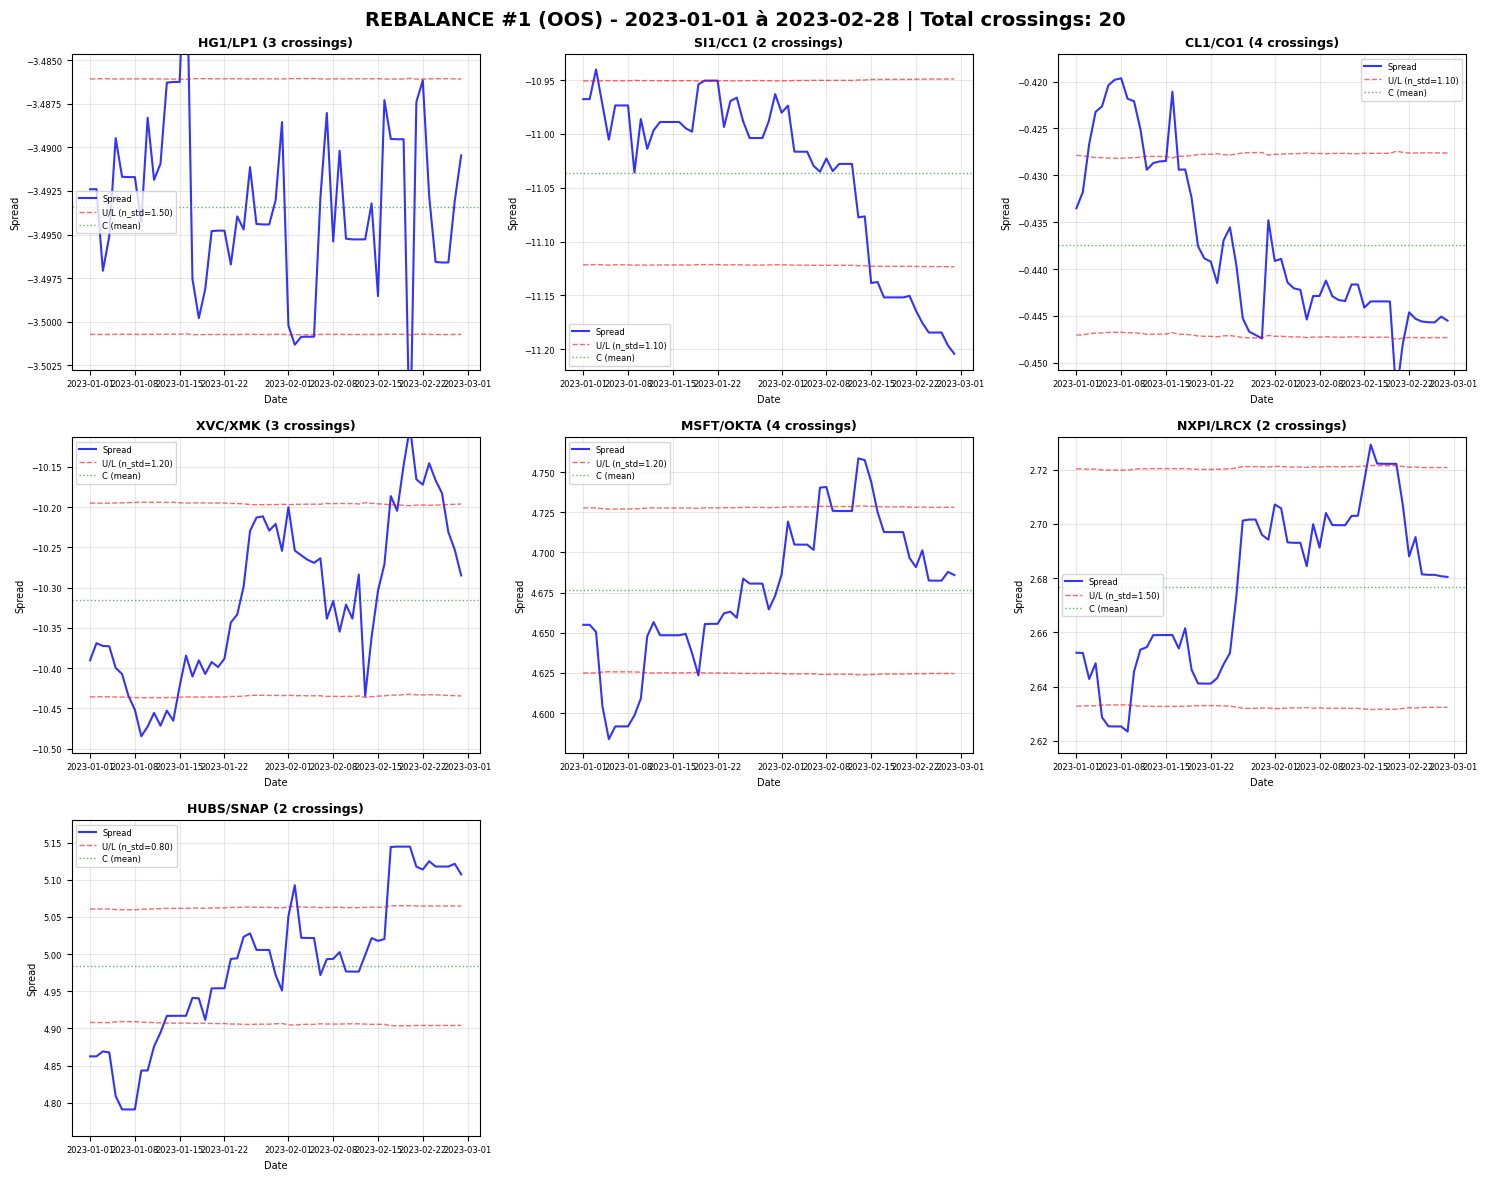

   ✅ 7 paires affichées | 20 crossings de seuils détectés
   Progress: 0/522 dates (0.0%)

  REBALANCE #2 - 2023-03-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XMK Curncy / XLMUSD Curncy (p=0.0289, HL=13.3)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - SI1 Comdty / LN1 Comdty (p=0.0000, HL=5.5)
      - CL1 Comdty / CO1 Comdty (p=0.0001, HL=5.2)
      - SB1 Comdty / CC1 Comdty (p=0.0023, HL=7.1)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AMD US Equity / OKTA US Equity (p=0.0008, HL=19.8)
      - MSFT US Equity / NOW US Equity (p=0.0020, HL=8.9)
      - NXPI US Equity / LRCX US Equity (p=0.0023, HL=7.3)
   ❌ Fermeture: ('commodities', 'SI1 Comdty', 'CC1 Comdty')
   ❌ Fermeture: ('crypto', 'XVC

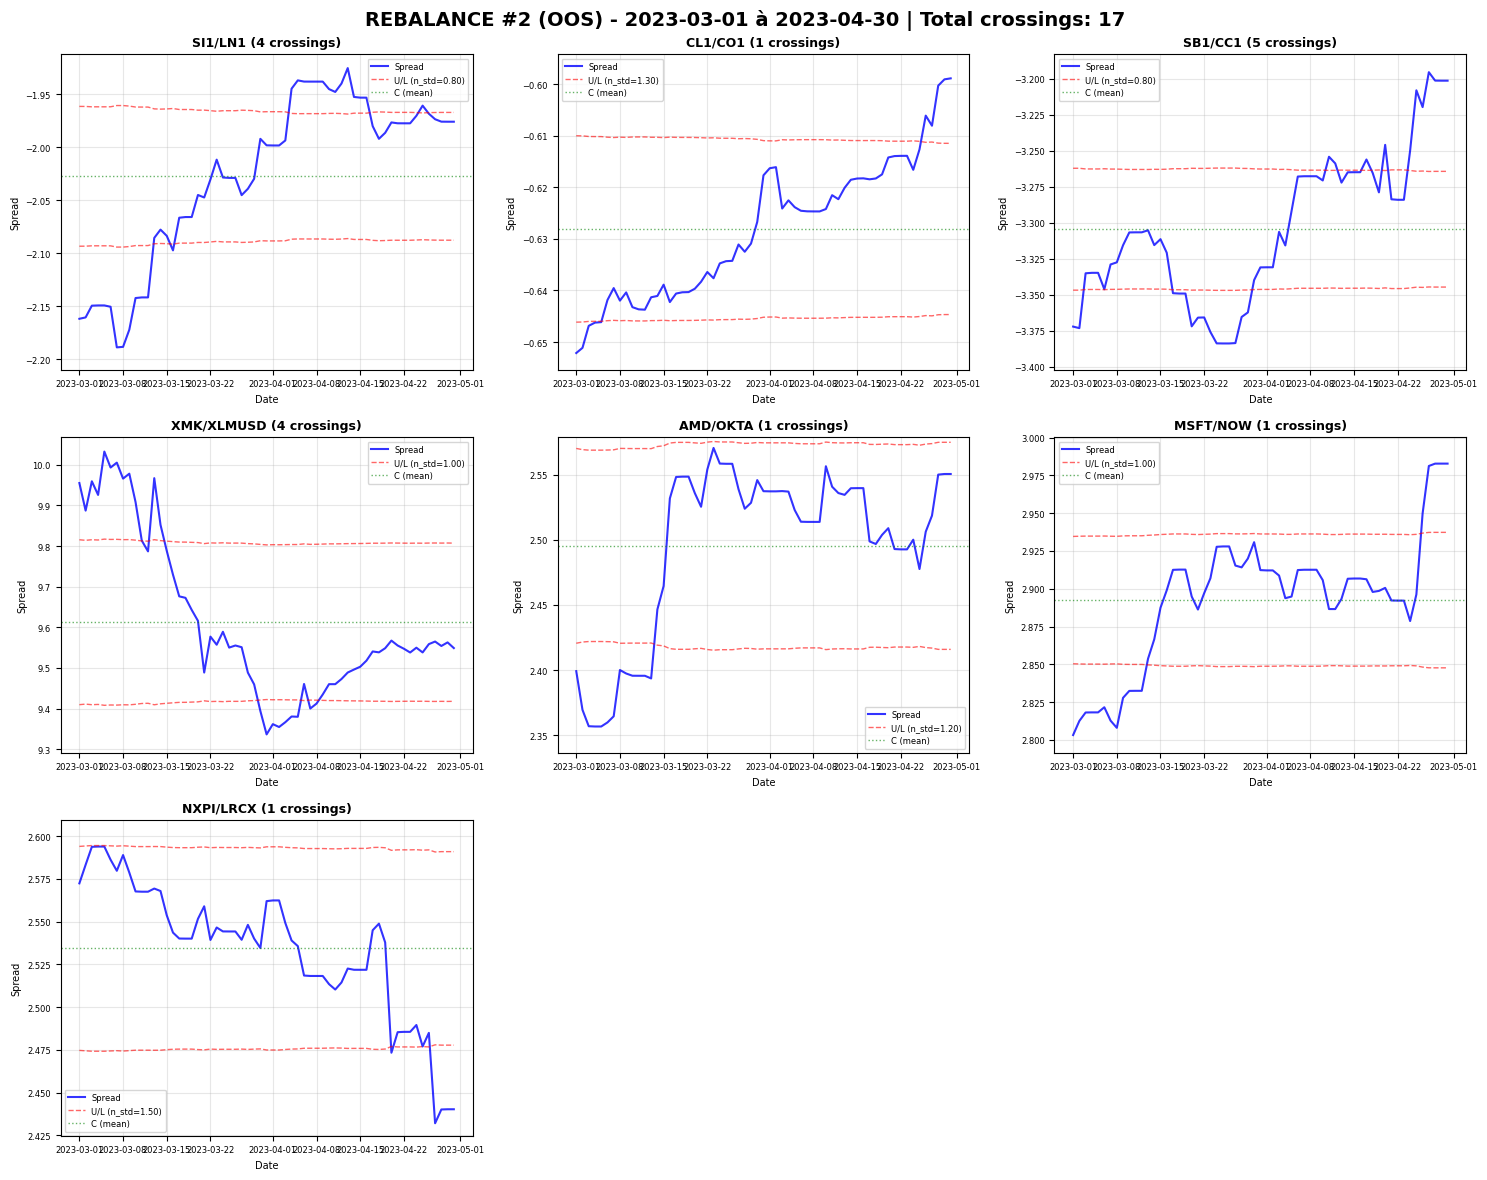

   ✅ 7 paires affichées | 17 crossings de seuils détectés

  REBALANCE #3 - 2023-05-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XLM Curncy / XMK Curncy (p=0.0437, HL=14.9)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0002, HL=2.0)
      - SB1 Comdty / CC1 Comdty (p=0.0015, HL=6.4)
      - LA1 Comdty / S 1 Comdty (p=0.0024, HL=10.0)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - ASML US Equity / SHOP US Equity (p=0.0019, HL=7.5)
      - NOW US Equity / BIDU US Equity (p=0.0025, HL=10.9)
      - ON US Equity / WDAY US Equity (p=0.0057, HL=14.9)
   ⚠️  Déselection: ('tech', 'AMD US Equity', 'OKTA US Equity') - monitoring jusqu'à fermeture naturelle
   ❌ Fermeture: ('te

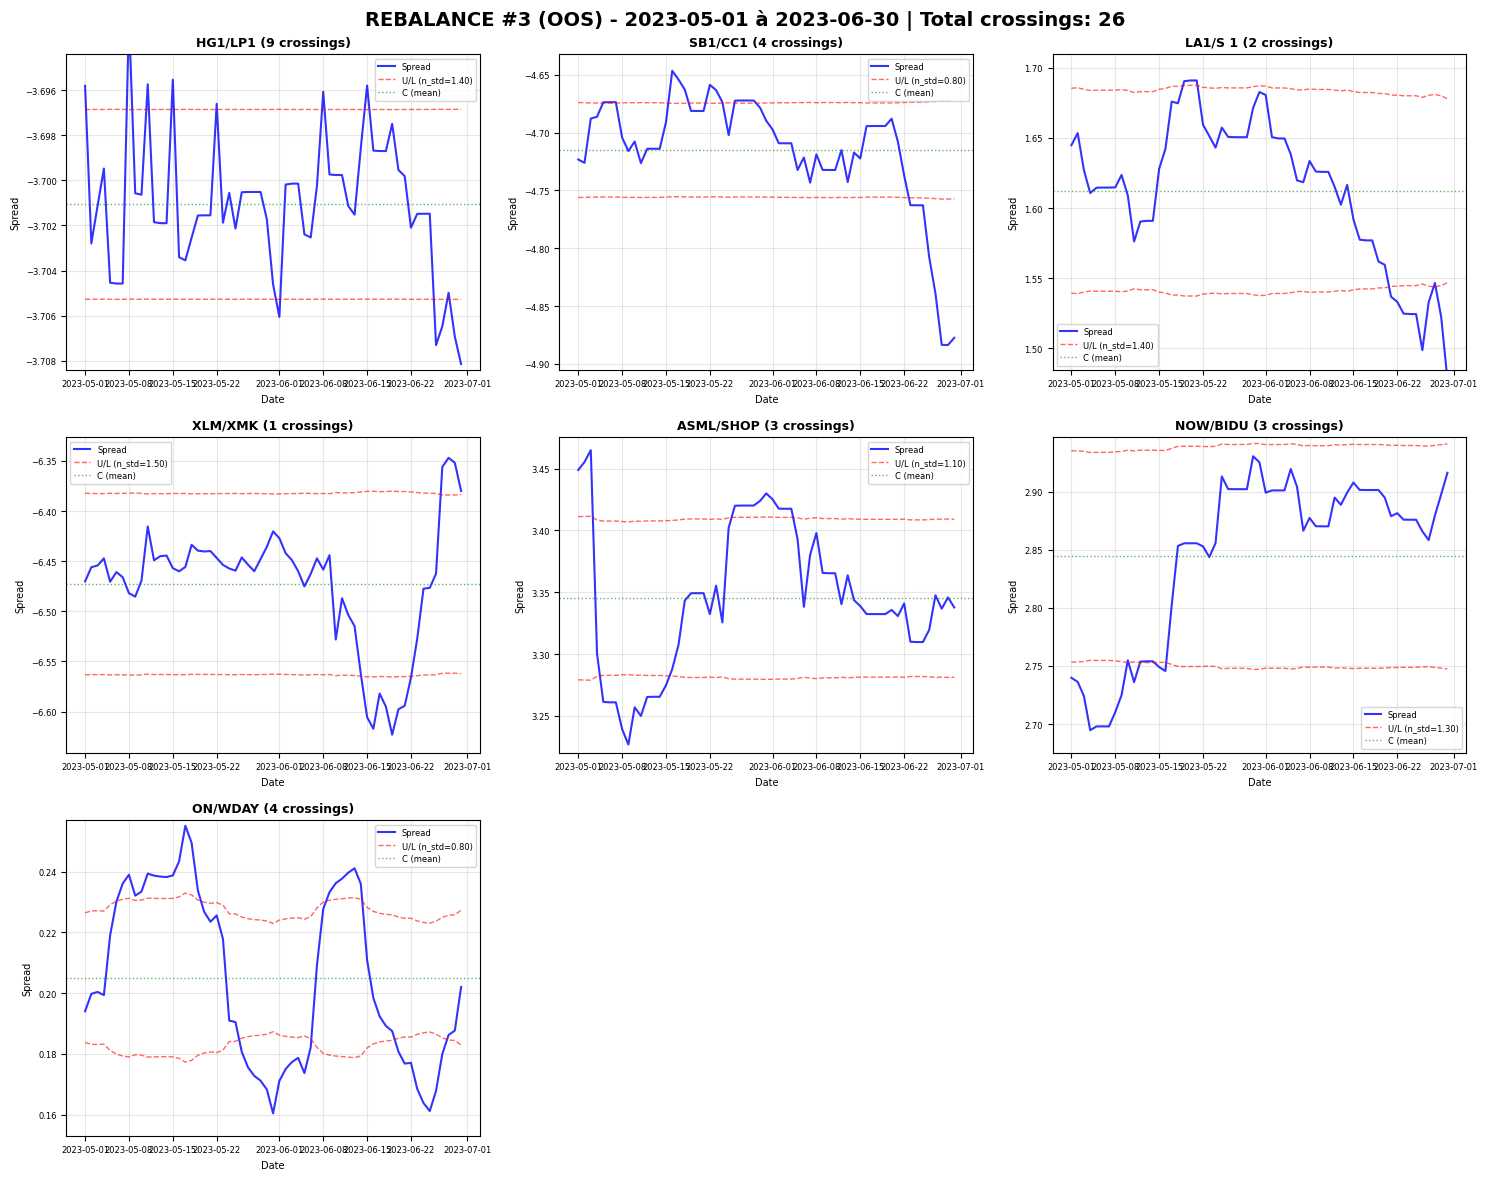

   ✅ 7 paires affichées | 26 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'AMD US Equity', 'OKTA US Equity')

  REBALANCE #4 - 2023-07-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XET Curncy / BTCUSD Curncy (p=0.0065, HL=11.9)
      - XVC Curncy / XEO Curncy (p=0.0255, HL=17.3)
      - XBT Curncy / ETHUSD Curncy (p=0.0298, HL=17.6)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0000, HL=1.7)
      - CL1 Comdty / LB1 Comdty (p=0.0001, HL=7.7)
      - RR1 Comdty / LC1 Comdty (p=0.0008, HL=11.9)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - MU US Equity / NOW US Equity (p=0.0018, HL=7.6)
      - SNAP US Equity / BIDU US Equity (p=0.0047, HL=8.0)
      - ON US Eq

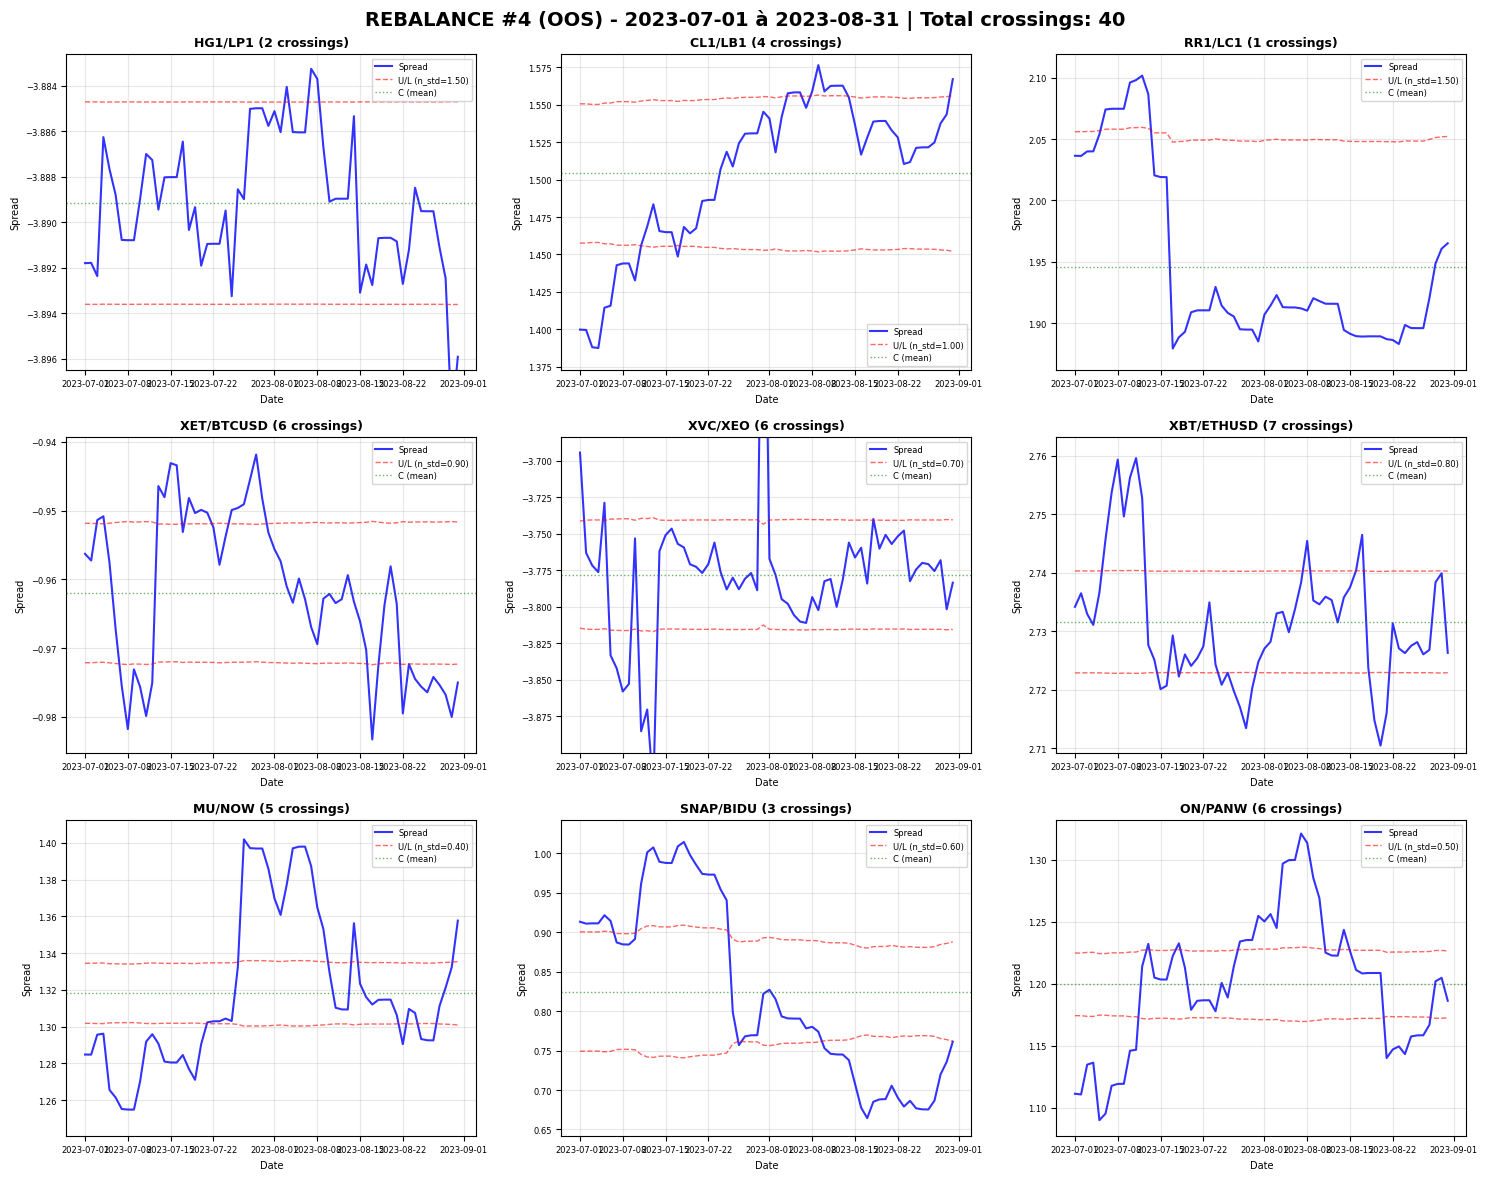

   ✅ 9 paires affichées | 40 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'LA1 Comdty', 'S 1 Comdty')

  REBALANCE #5 - 2023-09-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XVC Curncy / XMN Curncy (p=0.0031, HL=4.3)
      - XET Curncy / BTCUSD Curncy (p=0.0047, HL=10.1)
      - XBT Curncy / ETHUSD Curncy (p=0.0093, HL=11.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0016, HL=2.0)
      - CT1 Comdty / LH1 Comdty (p=0.0037, HL=11.9)
      - CL1 Comdty / HO1 Comdty (p=0.0044, HL=10.3)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - ORCL US Equity / LRCX US Equity (p=0.0023, HL=11.3)
      - MU US Equity / SHOP US Equity (p=0.0054, HL=8.1)
      - NFLX U

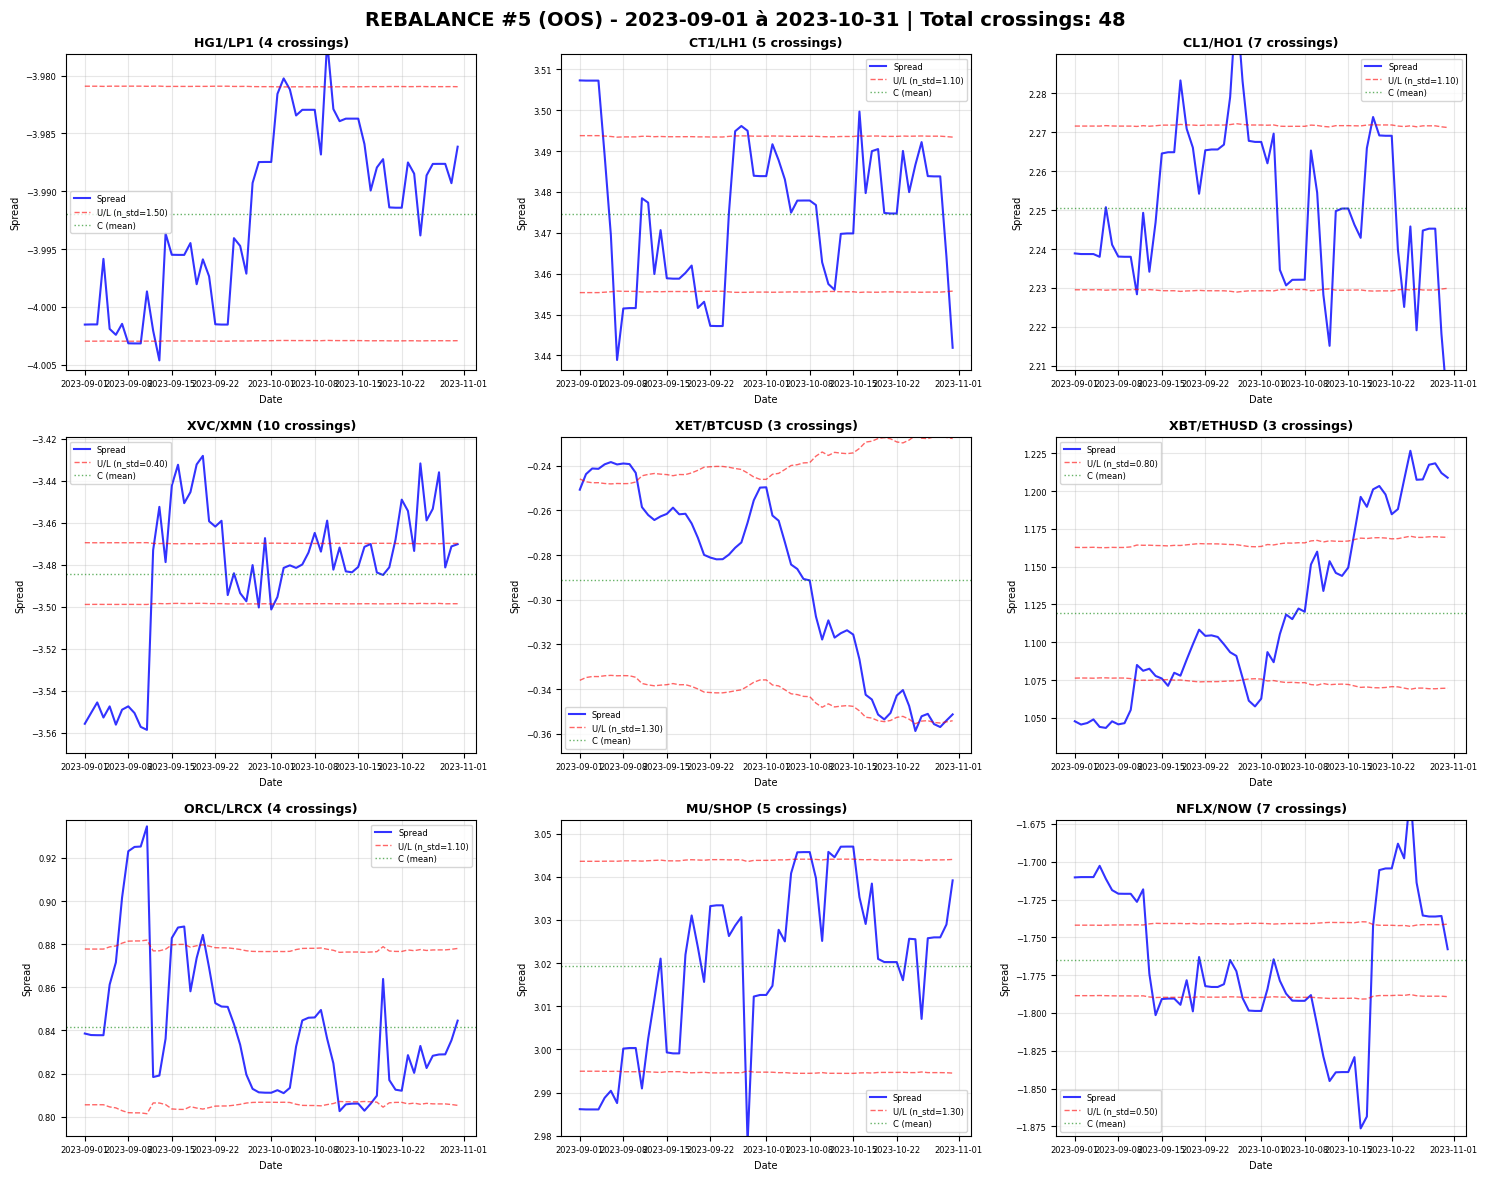

   ✅ 9 paires affichées | 48 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'MU US Equity', 'NOW US Equity')

  REBALANCE #6 - 2023-11-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XVC Curncy / XMN Curncy (p=0.0043, HL=4.3)
      - XDH Curncy / XEO Curncy (p=0.0064, HL=11.1)
      - XBN Curncy / XMK Curncy (p=0.0223, HL=18.4)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - CT1 Comdty / FC1 Comdty (p=0.0001, HL=6.2)
      - LA1 Comdty / LB1 Comdty (p=0.0007, HL=7.6)
      - HG1 Comdty / SM1 Comdty (p=0.0017, HL=7.5)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AMAT US Equity / TEAM US Equity (p=0.0000, HL=6.3)
      - AVGO US Equity / MDB US Equity (p=0.0000, HL=5.5)
      - LRCX US Equity /

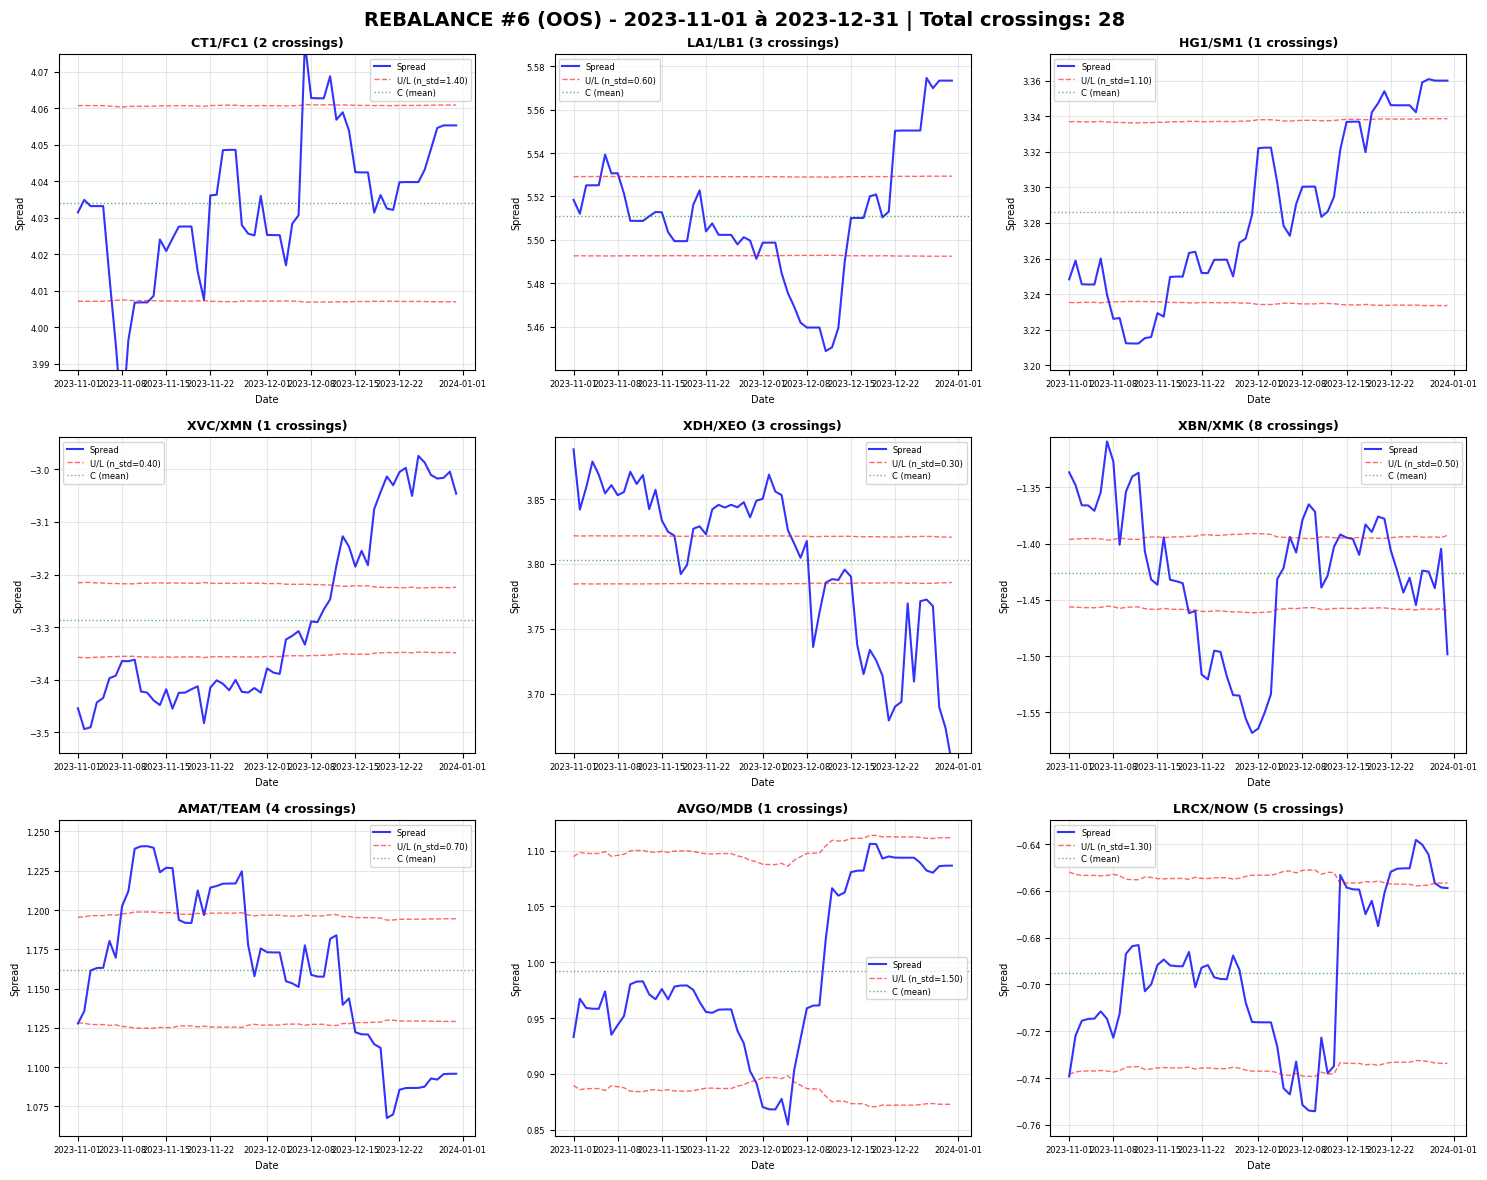

   ✅ 9 paires affichées | 28 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'HUBS US Equity', 'SNAP US Equity')
   ❌ Fermeture: ('commodities', 'HG1 Comdty', 'LP1 Comdty')
   ❌ Fermeture: ('tech', 'ORCL US Equity', 'LRCX US Equity')
   Progress: 250/522 dates (47.9%)

  REBALANCE #7 - 2024-01-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 21
   ⚠️  Aucune paire sélectionnée

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / W 1 Comdty (p=0.0007, HL=6.9)
      - NG1 Comdty / PL1 Comdty (p=0.0026, HL=12.0)
      - LA1 Comdty / LB1 Comdty (p=0.0047, HL=9.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AVGO US Equity / AMAT US Equity (p=0.0011, HL=7.3)
      - MU US Equity / ESTC US Equity (p=0.0015, HL=9.1)
      - AMZN US

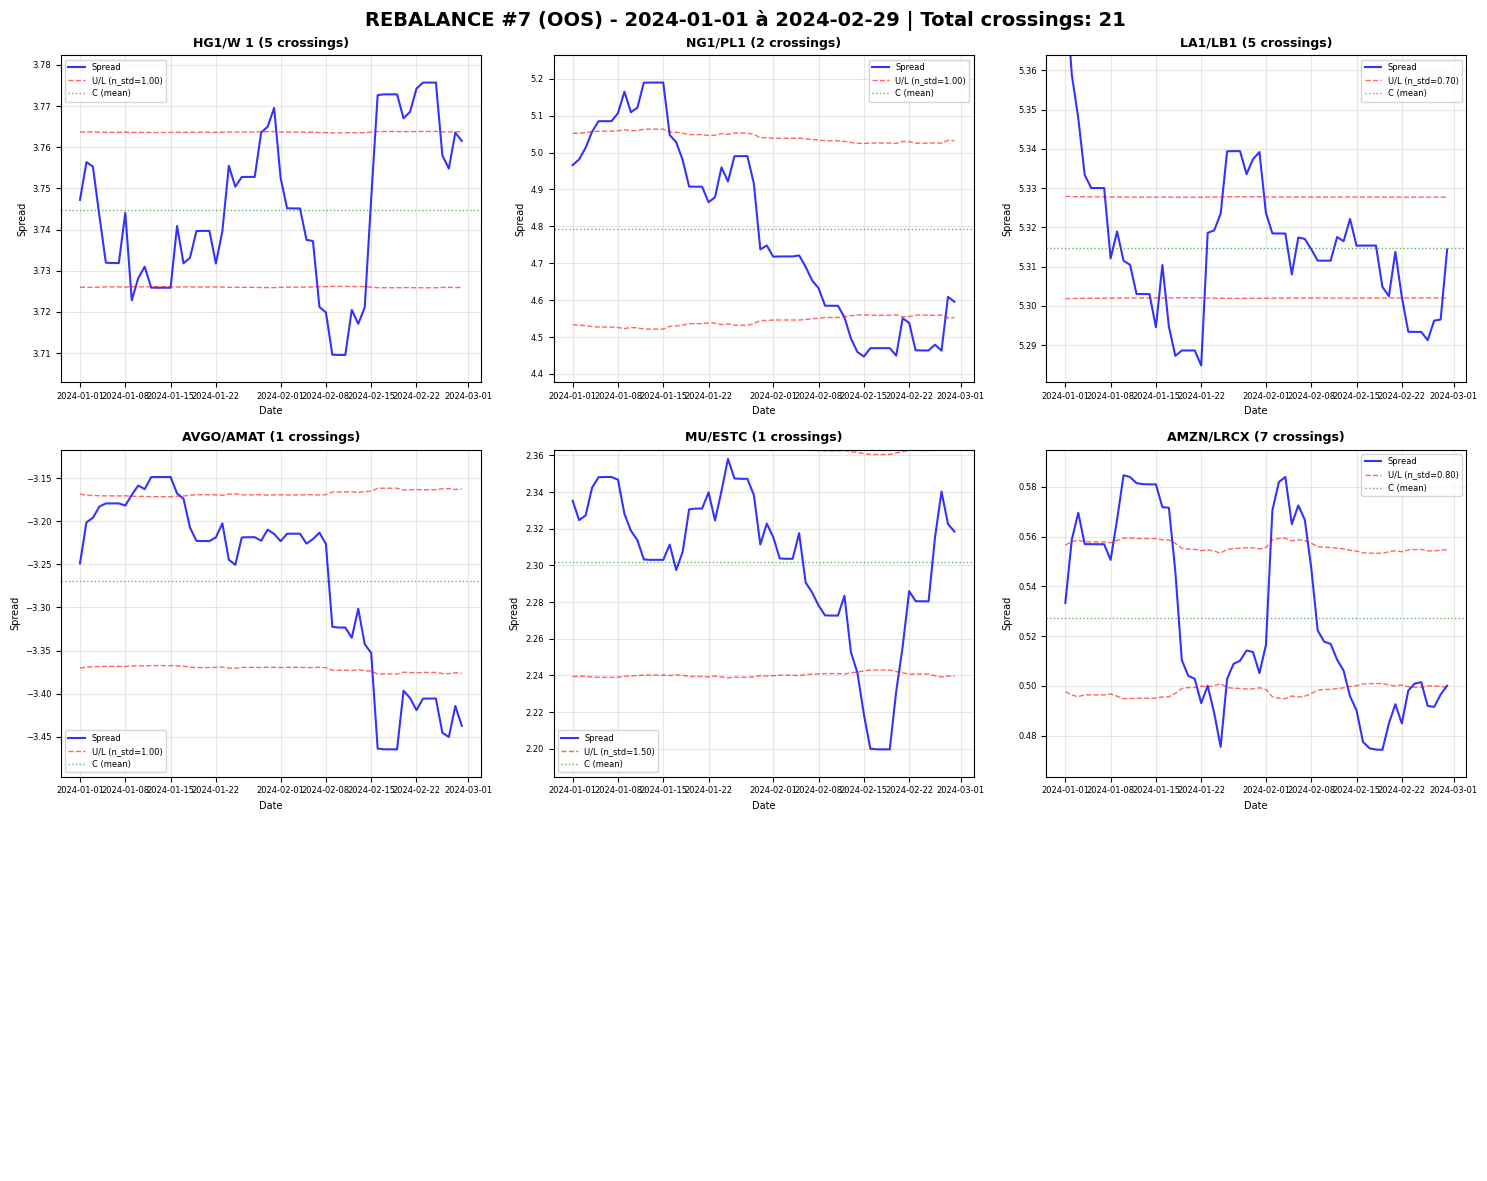

   ✅ 6 paires affichées | 21 crossings de seuils détectés
   ❌ Fermeture: ('crypto', 'XDH Curncy', 'XEO Curncy')
   ❌ Fermeture: ('commodities', 'CT1 Comdty', 'FC1 Comdty')

  REBALANCE #8 - 2024-03-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0079, HL=8.4)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - GC1 Comdty / KC1 Comdty (p=0.0000, HL=8.8)
      - LT1 Comdty / LH1 Comdty (p=0.0002, HL=9.3)
      - LA1 Comdty / LB1 Comdty (p=0.0006, HL=8.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AVGO US Equity / ZS US Equity (p=0.0005, HL=7.4)
      - AMZN US Equity / KLAC US Equity (p=0.0011, HL=7.2)
      - NFLX US Equity / LRCX US Equity (p=0.0041, HL=7.6)
   ❌ Fermetur

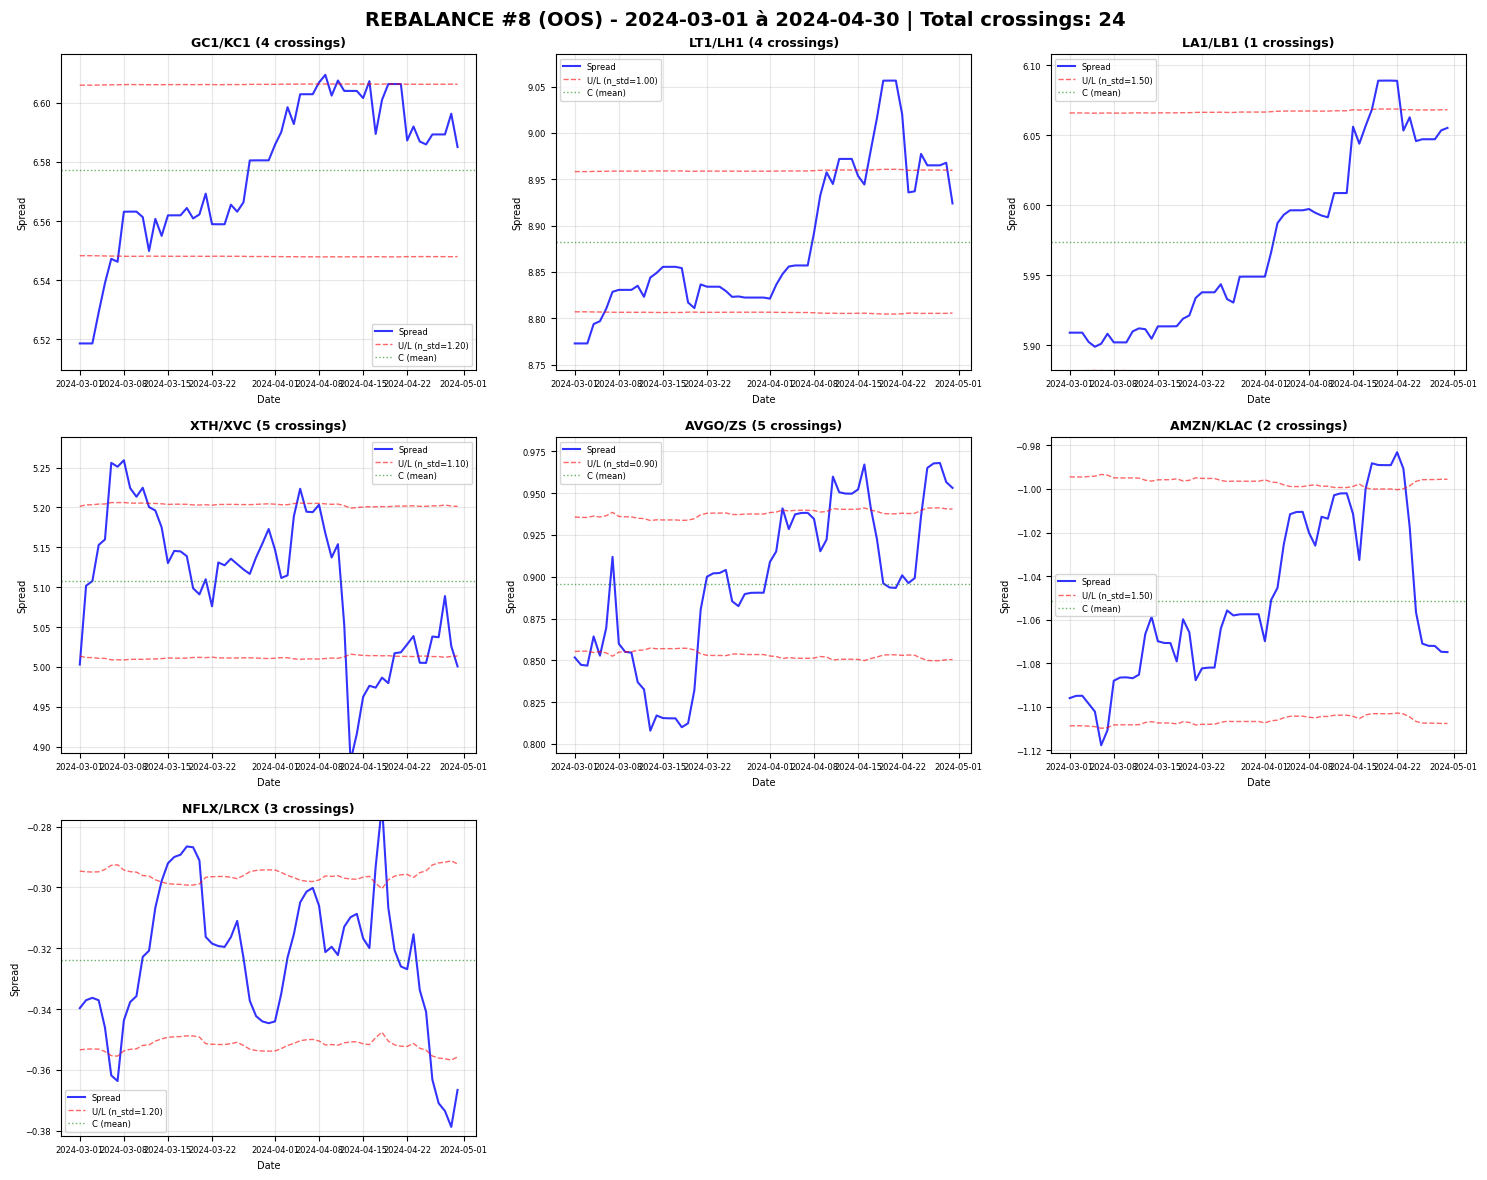

   ✅ 7 paires affichées | 24 crossings de seuils détectés
   ❌ Fermeture: ('crypto', 'XBN Curncy', 'XMK Curncy')

  REBALANCE #9 - 2024-05-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-05-01 00:00:00 → 2024-04-30 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XTH Curncy / ETHUSD Curncy (p=0.0014, HL=8.0)
      - XET Curncy / ETCUSD Curncy (p=0.0032, HL=8.7)
      - XBN Curncy / XMK Curncy (p=0.0272, HL=20.3)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-05-01 00:00:00 → 2024-04-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - SI1 Comdty / HG1 Comdty (p=0.0003, HL=11.4)
      - LC1 Comdty / FC1 Comdty (p=0.0099, HL=8.4)
      - CL1 Comdty / CO1 Comdty (p=0.0080, HL=5.1)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-05-01 00:00:00 → 2024-04-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - NFLX US Equity / QCOM US Equity (p=0.0001, HL=8.5)
      - AMZN US Equity / KLAC US Equity (p=0.0001, HL=5.6)
      - TXN US Equit

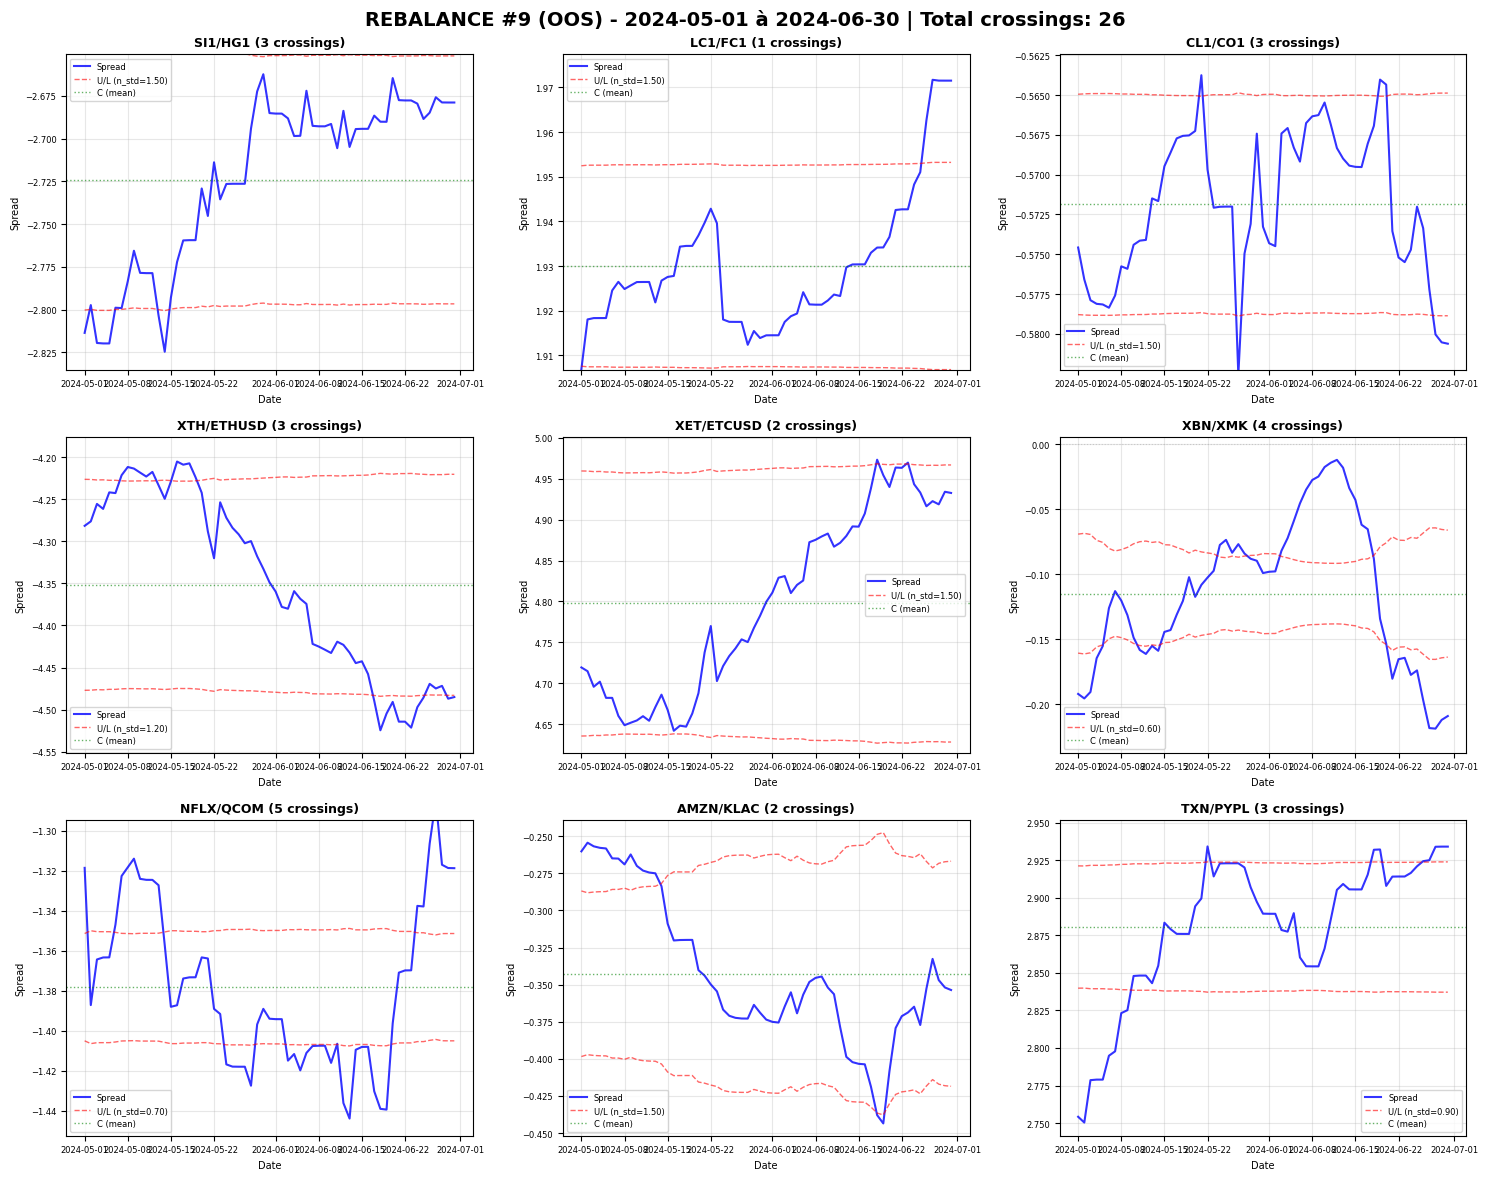

   ✅ 9 paires affichées | 26 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'LA1 Comdty', 'LB1 Comdty')

  REBALANCE #10 - 2024-07-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-07-01 00:00:00 → 2024-06-30 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0263, HL=10.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-07-01 00:00:00 → 2024-06-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - CL1 Comdty / CO1 Comdty (p=0.0002, HL=3.8)
      - PL1 Comdty / LP1 Comdty (p=0.0004, HL=9.7)
      - PA1 Comdty / BO1 Comdty (p=0.0032, HL=8.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-07-01 00:00:00 → 2024-06-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - NFLX US Equity / ASML US Equity (p=0.0006, HL=7.4)
      - AMZN US Equity / LRCX US Equity (p=0.0007, HL=7.1)
      - PANW US Equity / ESTC US Equity (p=0.0011, HL=6.6)
   ⚠️  Déselection: ('commodities', 'SI1 Comdty', 'HG1 Comdty') 

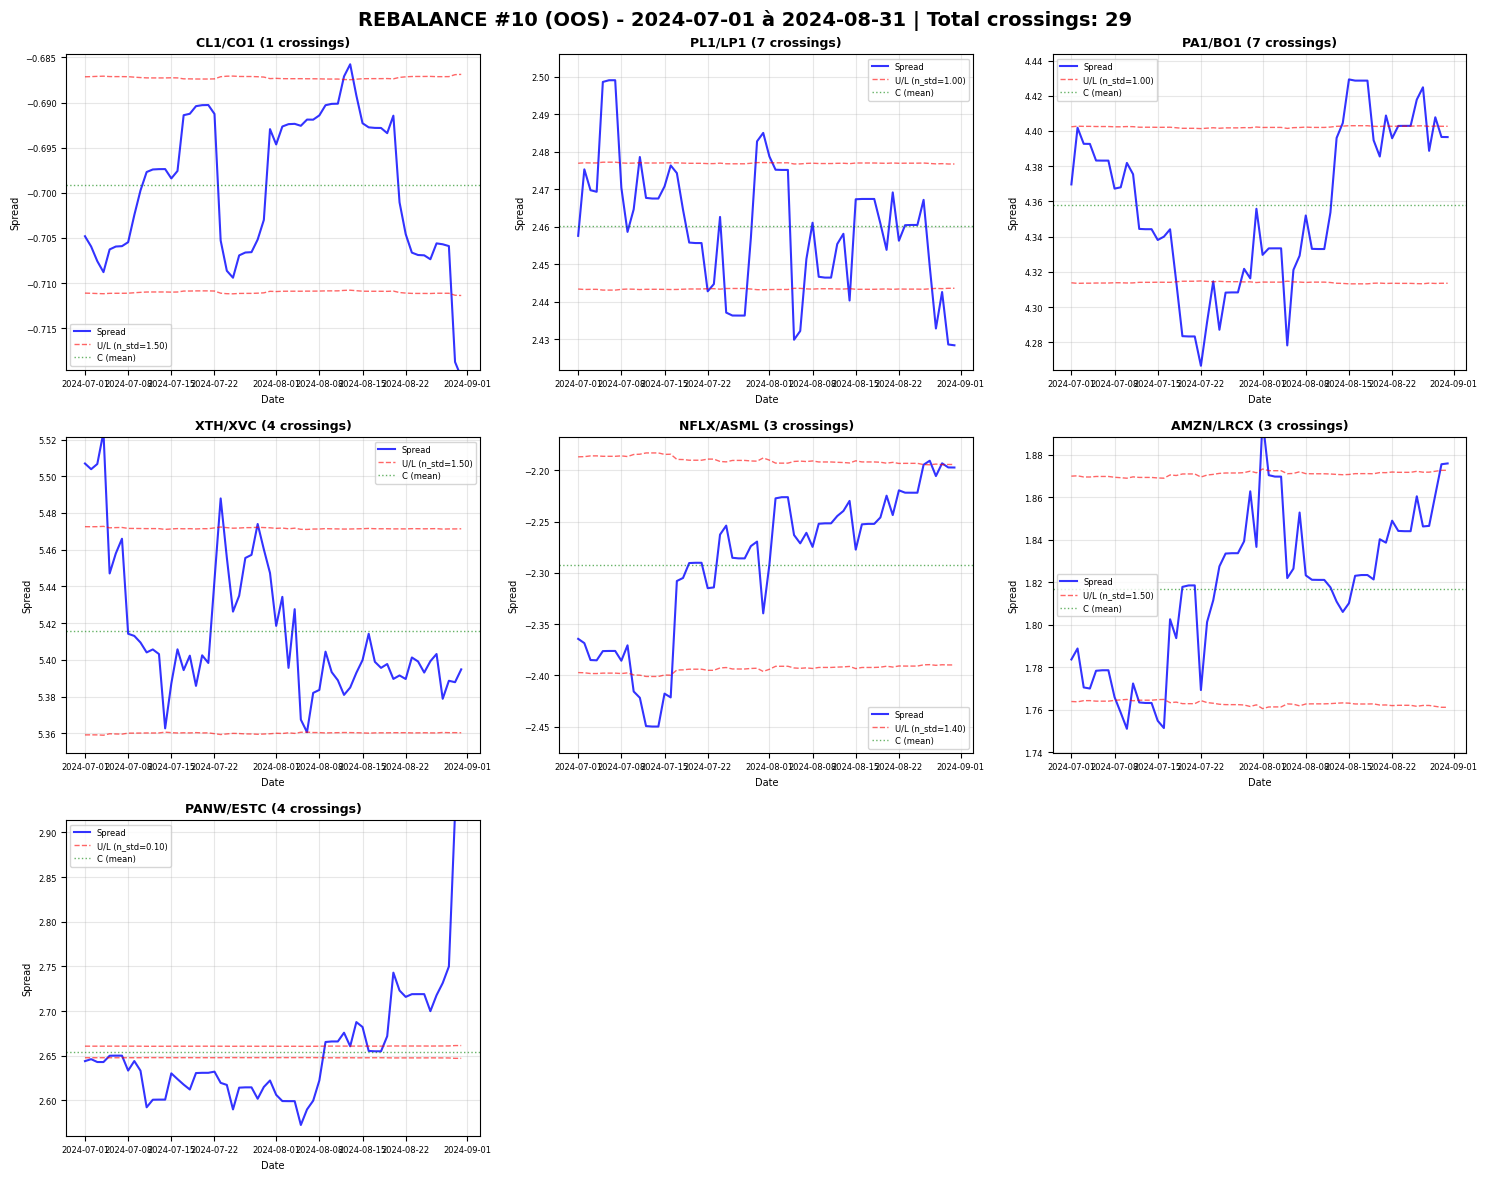

   ✅ 7 paires affichées | 29 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'NG1 Comdty', 'PL1 Comdty')

  REBALANCE #11 - 2024-09-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-09-01 00:00:00 → 2024-08-31 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0228, HL=12.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-09-01 00:00:00 → 2024-08-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0006, HL=3.6)
      - PL1 Comdty / LX1 Comdty (p=0.0028, HL=7.3)
      - PA1 Comdty / BO1 Comdty (p=0.0096, HL=8.7)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-09-01 00:00:00 → 2024-08-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - MRVL US Equity / ASML US Equity (p=0.0025, HL=12.5)
      - NFLX US Equity / KLAC US Equity (p=0.0025, HL=7.1)
      - AMZN US Equity / AMAT US Equity (p=0.0032, HL=7.9)
   ❌ Fermeture: ('tech', 'AMZN US Equity', 'LRCX US Equity')
  

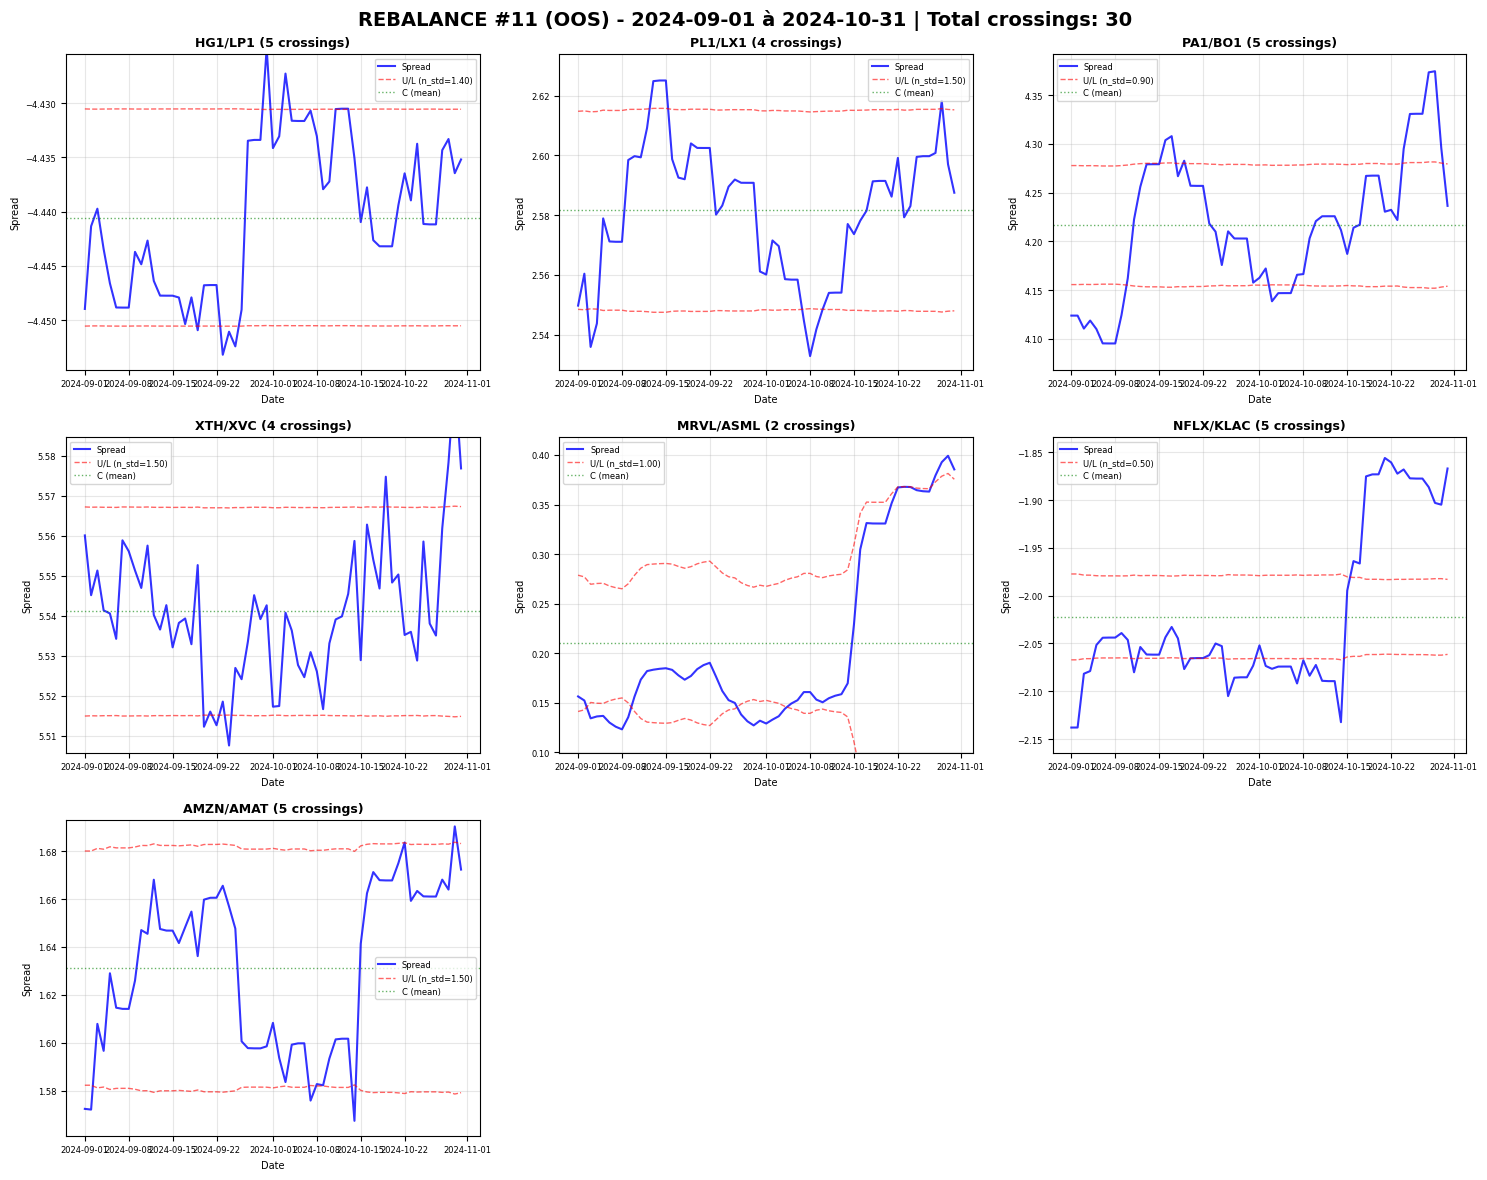

   ✅ 7 paires affichées | 30 crossings de seuils détectés

  REBALANCE #12 - 2024-11-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-11-01 00:00:00 → 2024-10-31 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0271, HL=12.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-11-01 00:00:00 → 2024-10-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0016, HL=3.7)
      - PL1 Comdty / LX1 Comdty (p=0.0109, HL=7.4)
      - PA1 Comdty / O 1 Comdty (p=0.0301, HL=12.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-11-01 00:00:00 → 2024-10-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - IBM US Equity / NOW US Equity (p=0.0010, HL=6.2)
      - NXPI US Equity / SHOP US Equity (p=0.0026, HL=14.4)
      - LRCX US Equity / ROKU US Equity (p=0.0031, HL=10.8)
   ❌ Fermeture: ('tech', 'AMZN US Equity', 'AMAT US Equity')
   ❌ Fermeture: ('tech', 'MRVL US Equity', 'ASML US Equity')
 

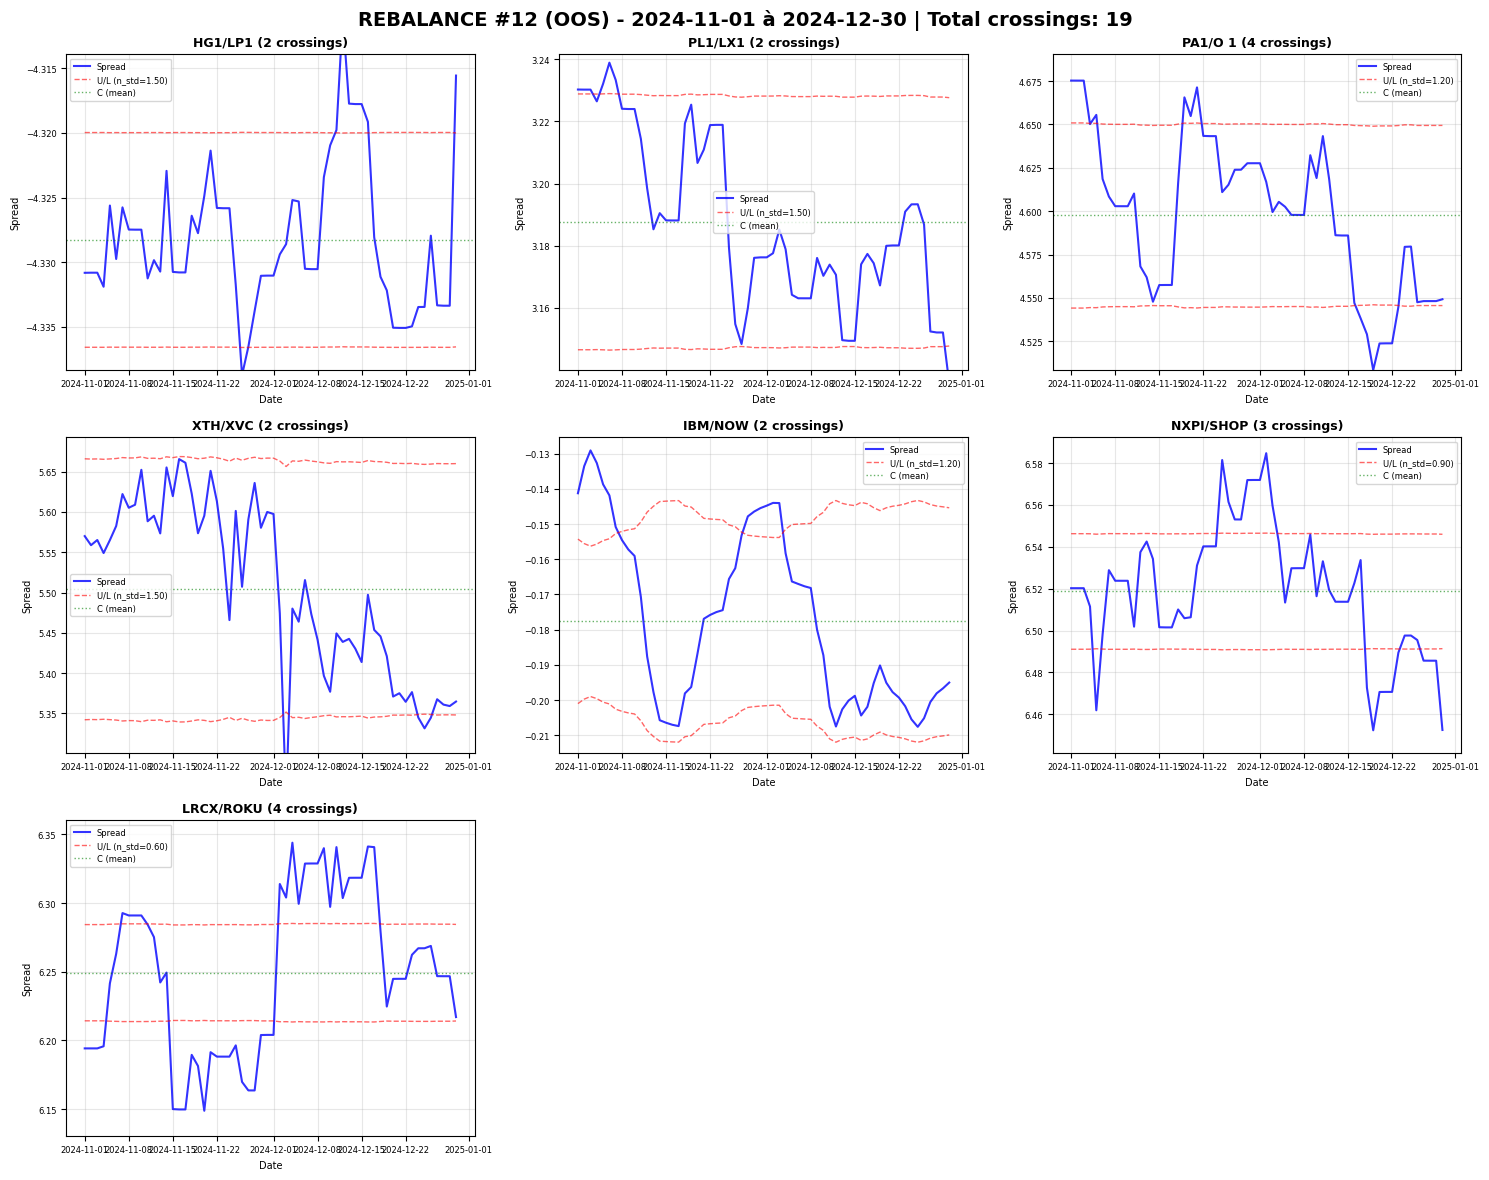

   ✅ 7 paires affichées | 19 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'PA1 Comdty', 'BO1 Comdty')
   ❌ Fermeture: ('tech', 'NFLX US Equity', 'KLAC US Equity')
   Progress: 500/522 dates (95.8%)

✅ Backtest terminé!

  STATISTIQUES DES PAIRES

📊 Nombre total de paires différentes utilisées: 68

🔷 COMMODITIES
   LA1 Comdty / LB1 Comdty │ Sélections:  3x │ Trades:   4
   HG1 Comdty / LP1 Comdty │ Sélections:  6x │ Trades:   3
   SB1 Comdty / CC1 Comdty │ Sélections:  2x │ Trades:   2
   SI1 Comdty / HG1 Comdty │ Sélections:  1x │ Trades:   2
   PA1 Comdty / BO1 Comdty │ Sélections:  2x │ Trades:   2
   CL1 Comdty / CO1 Comdty │ Sélections:  4x │ Trades:   1
   SI1 Comdty / LN1 Comdty │ Sélections:  1x │ Trades:   1
   LA1 Comdty / S 1 Comdty │ Sélections:  1x │ Trades:   1
   RR1 Comdty / LC1 Comdty │ Sélections:  1x │ Trades:   1
   CT1 Comdty / FC1 Comdty │ Sélections:  1x │ Trades:   1
   HG1 Comdty / SM1 Comdty │ Sélections:  1x │ Trades:   1
   NG1 Comdty / PL1 Co

In [ ]:
# Pour Model 2 (Strat C) - par défaut
df_portfolio_pnl_2_C = run_portfolio_backtest(
    asset_classes=ASSET_CLASSES,
    backtest_start=BACKTEST_START,
    backtest_end=BACKTEST_END,
    rebalance_freq_months=REBALANCE_FREQ_MONTHS,
    lookback_years=SELECTION_LOOKBACK_YEARS,
    n_pairs_per_class=N_PAIRS_PER_CLASS,
    model="II"  # Strat C (hétéroscédastique)
)

print(df_portfolio_pnl_2_C.head())

print(f"\n Résultats du backtest:")
print(f"   Dates: {len(df_portfolio_pnl_2_C)}")
print(f"   PnL moyen par jour: {df_portfolio_pnl_2_C['pnl'].mean():.6f}")
print(f"   Positions moyennes: {df_portfolio_pnl_2_C['n_positions'].mean():.1f}")


  PORTFOLIO BACKTEST MULTI-ASSET
  MODEL I - STRAT A (Homoscédastique)

🔧 Configuration:
   Période: 2023-01-01 → 2024-12-31
   Fréquence rééquilibrage: 2 mois
   Lookback: 1 années
   Paires/classe: 3
   Coût transaction: 20.0 bp

📦 Chargement des données...

🔷 CRYPTO:


   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 21 tickers: ['XBT Curncy', 'XET Curncy', 'XRP Curncy']...

🔷 COMMODITIES:
   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 29 tickers: ['CL1 Comdty', 'CO1 Comdty', 'NG1 Comdty']...

🔷 TECH:
   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 44 tickers: ['AAPL US Equity', 'MSFT US Equity', 'GOOGL US Equity']...

📅 Calendrier:
   Jours de trading: 522
   Rééquilibrages: 12
      #1: 2023-01-01
      #2: 2023-03-01
      #3: 2023-05-01
      #4: 2023-07-01
      #5: 2023-09-01
      #6: 2023-11-01
      #7: 2024-01-01
      #8: 2024-03-01
      #9: 2024-05-01
      #10: 2024-07-01
      #11: 2024-09-01
      #12: 2024-11-01

🚀 Début du backtest...


  REBALANCE #1 - 2023-01-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-01-01 00:00:00 → 2022-12-31 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XVC Curncy / XMK Curncy (p=0.0064, HL

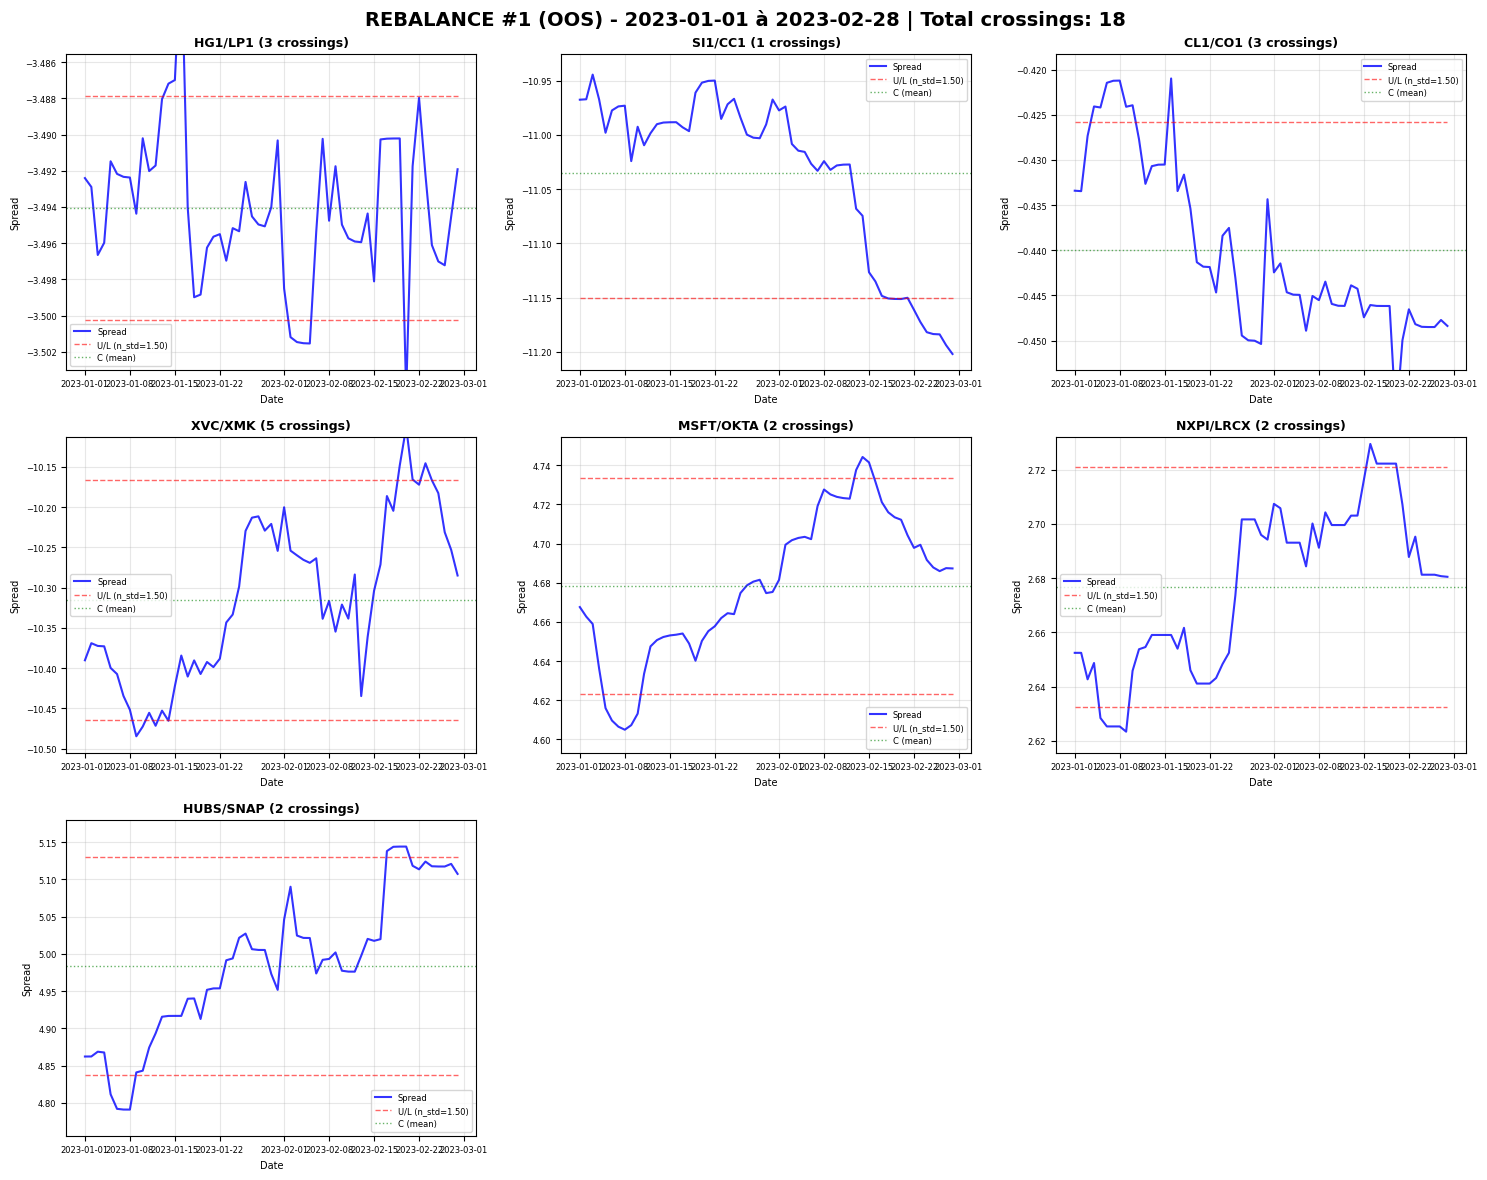

   ✅ 7 paires affichées | 18 crossings de seuils détectés
   Progress: 0/522 dates (0.0%)

  REBALANCE #2 - 2023-03-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XMK Curncy / XLMUSD Curncy (p=0.0289, HL=13.3)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - SI1 Comdty / LN1 Comdty (p=0.0000, HL=5.5)
      - CL1 Comdty / CO1 Comdty (p=0.0001, HL=5.2)
      - SB1 Comdty / CC1 Comdty (p=0.0023, HL=7.1)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AMD US Equity / OKTA US Equity (p=0.0008, HL=19.8)
      - MSFT US Equity / NOW US Equity (p=0.0020, HL=8.9)
      - NXPI US Equity / LRCX US Equity (p=0.0023, HL=7.3)
   ❌ Fermeture: ('commodities', 'SI1 Comdty', 'CC1 Comdty')
   ❌ Fermeture: ('crypto', 'XVC

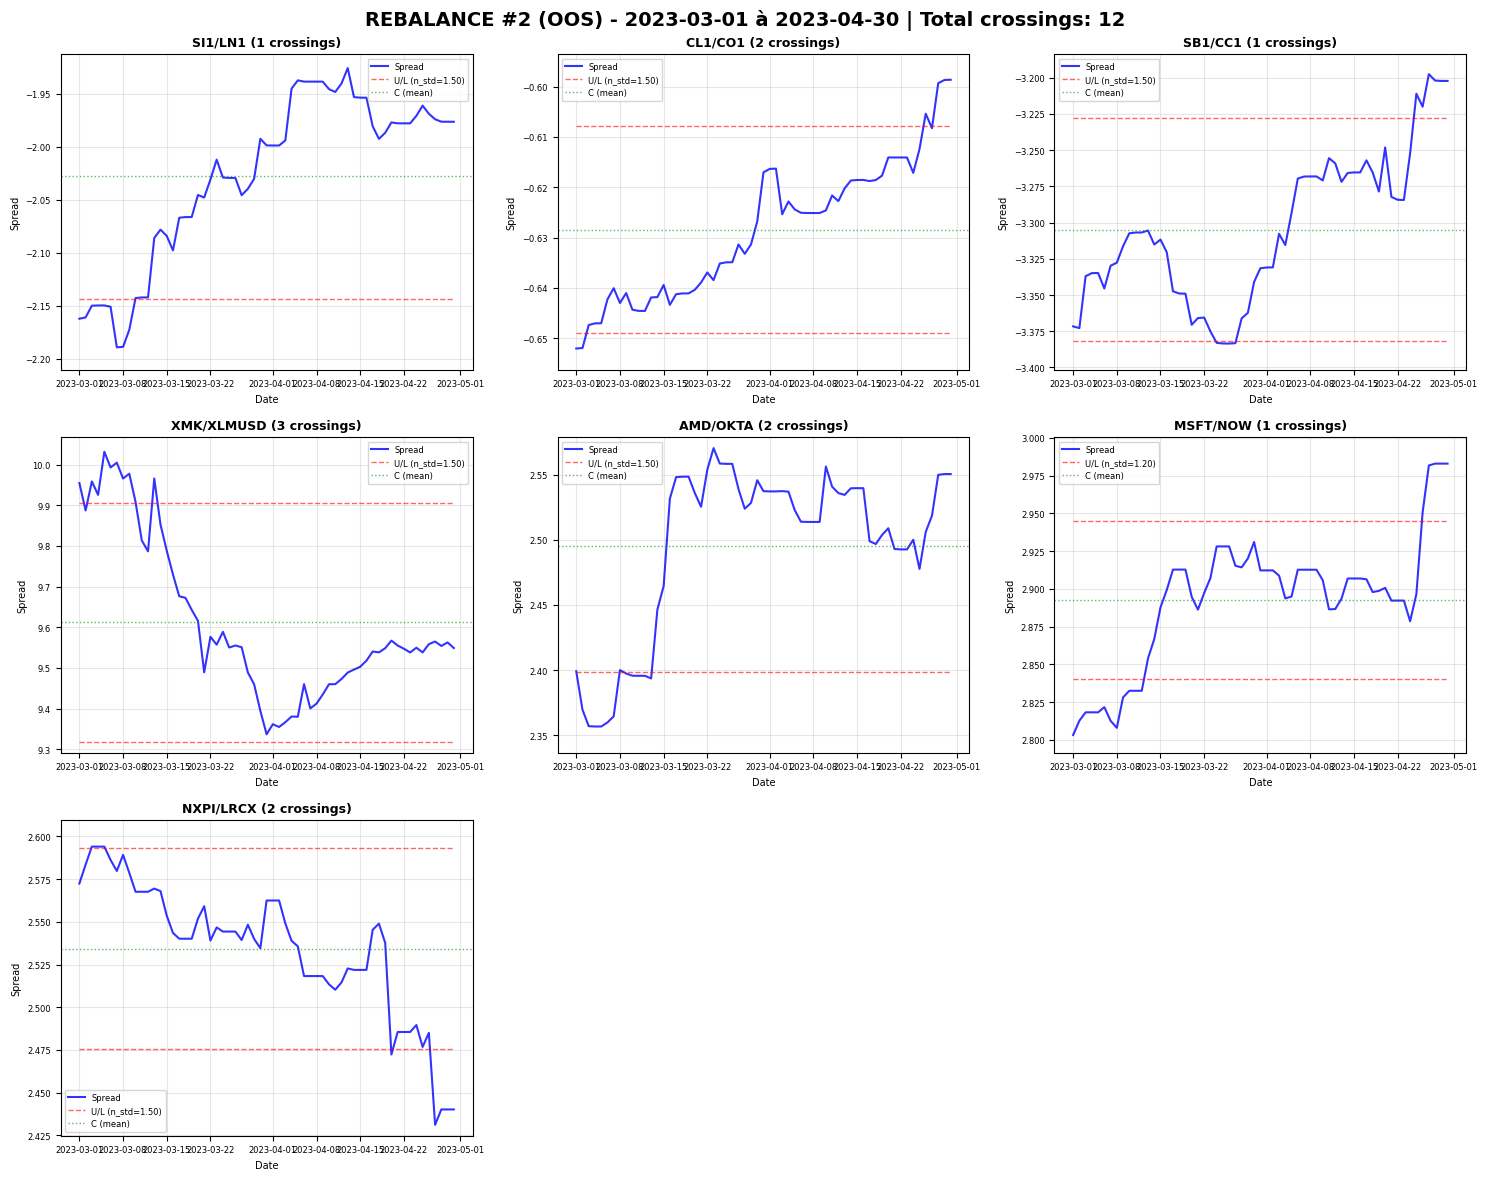

   ✅ 7 paires affichées | 12 crossings de seuils détectés

  REBALANCE #3 - 2023-05-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XLM Curncy / XMK Curncy (p=0.0437, HL=14.9)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0002, HL=2.0)
      - SB1 Comdty / CC1 Comdty (p=0.0015, HL=6.4)
      - LA1 Comdty / S 1 Comdty (p=0.0024, HL=10.0)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - ASML US Equity / SHOP US Equity (p=0.0019, HL=7.5)
      - NOW US Equity / BIDU US Equity (p=0.0025, HL=10.9)
      - ON US Equity / WDAY US Equity (p=0.0057, HL=14.9)
   ❌ Fermeture: ('tech', 'AMD US Equity', 'OKTA US Equity')
   ⚠️  Déselection: ('tech', 'MSFT US Equity', 'NOW US Equity') -

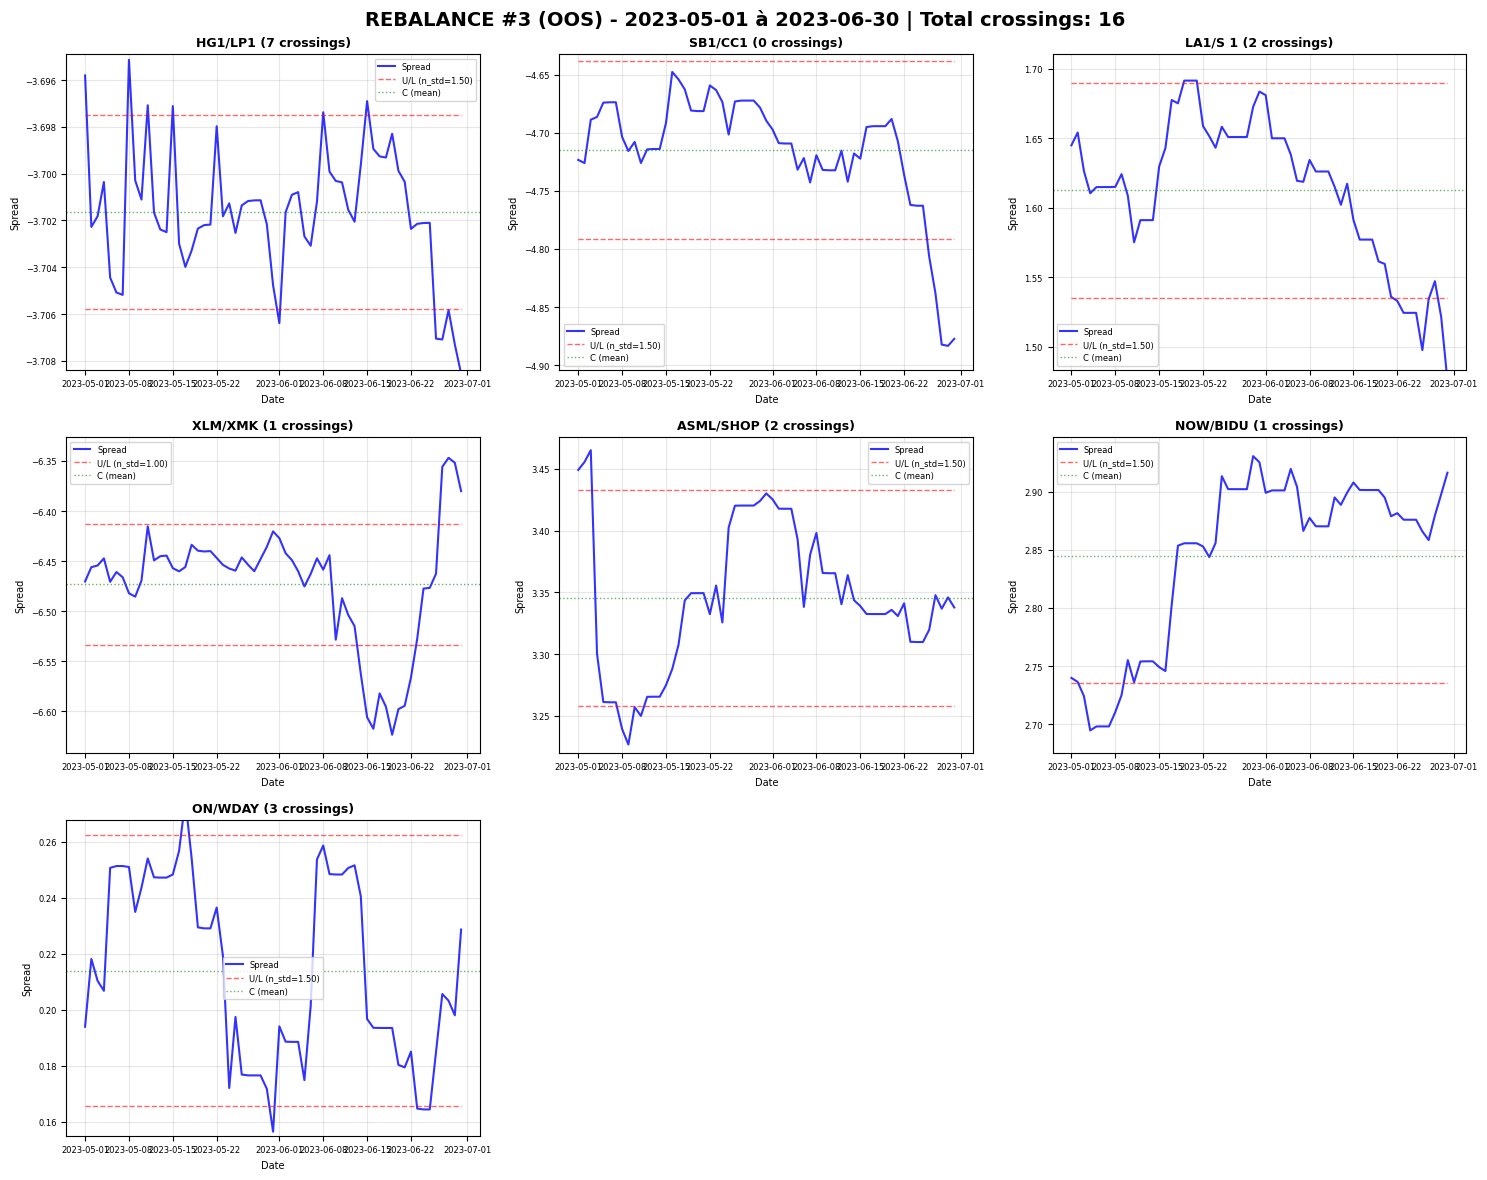

   ✅ 7 paires affichées | 16 crossings de seuils détectés

  REBALANCE #4 - 2023-07-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XET Curncy / BTCUSD Curncy (p=0.0065, HL=11.9)
      - XVC Curncy / XEO Curncy (p=0.0255, HL=17.3)
      - XBT Curncy / ETHUSD Curncy (p=0.0298, HL=17.6)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0000, HL=1.7)
      - CL1 Comdty / LB1 Comdty (p=0.0001, HL=7.7)
      - RR1 Comdty / LC1 Comdty (p=0.0008, HL=11.9)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - MU US Equity / NOW US Equity (p=0.0018, HL=7.6)
      - SNAP US Equity / BIDU US Equity (p=0.0047, HL=8.0)
      - ON US Equity / PANW US Equity (p=0.0060, HL=13.8)
   ❌ Fermeture: ('

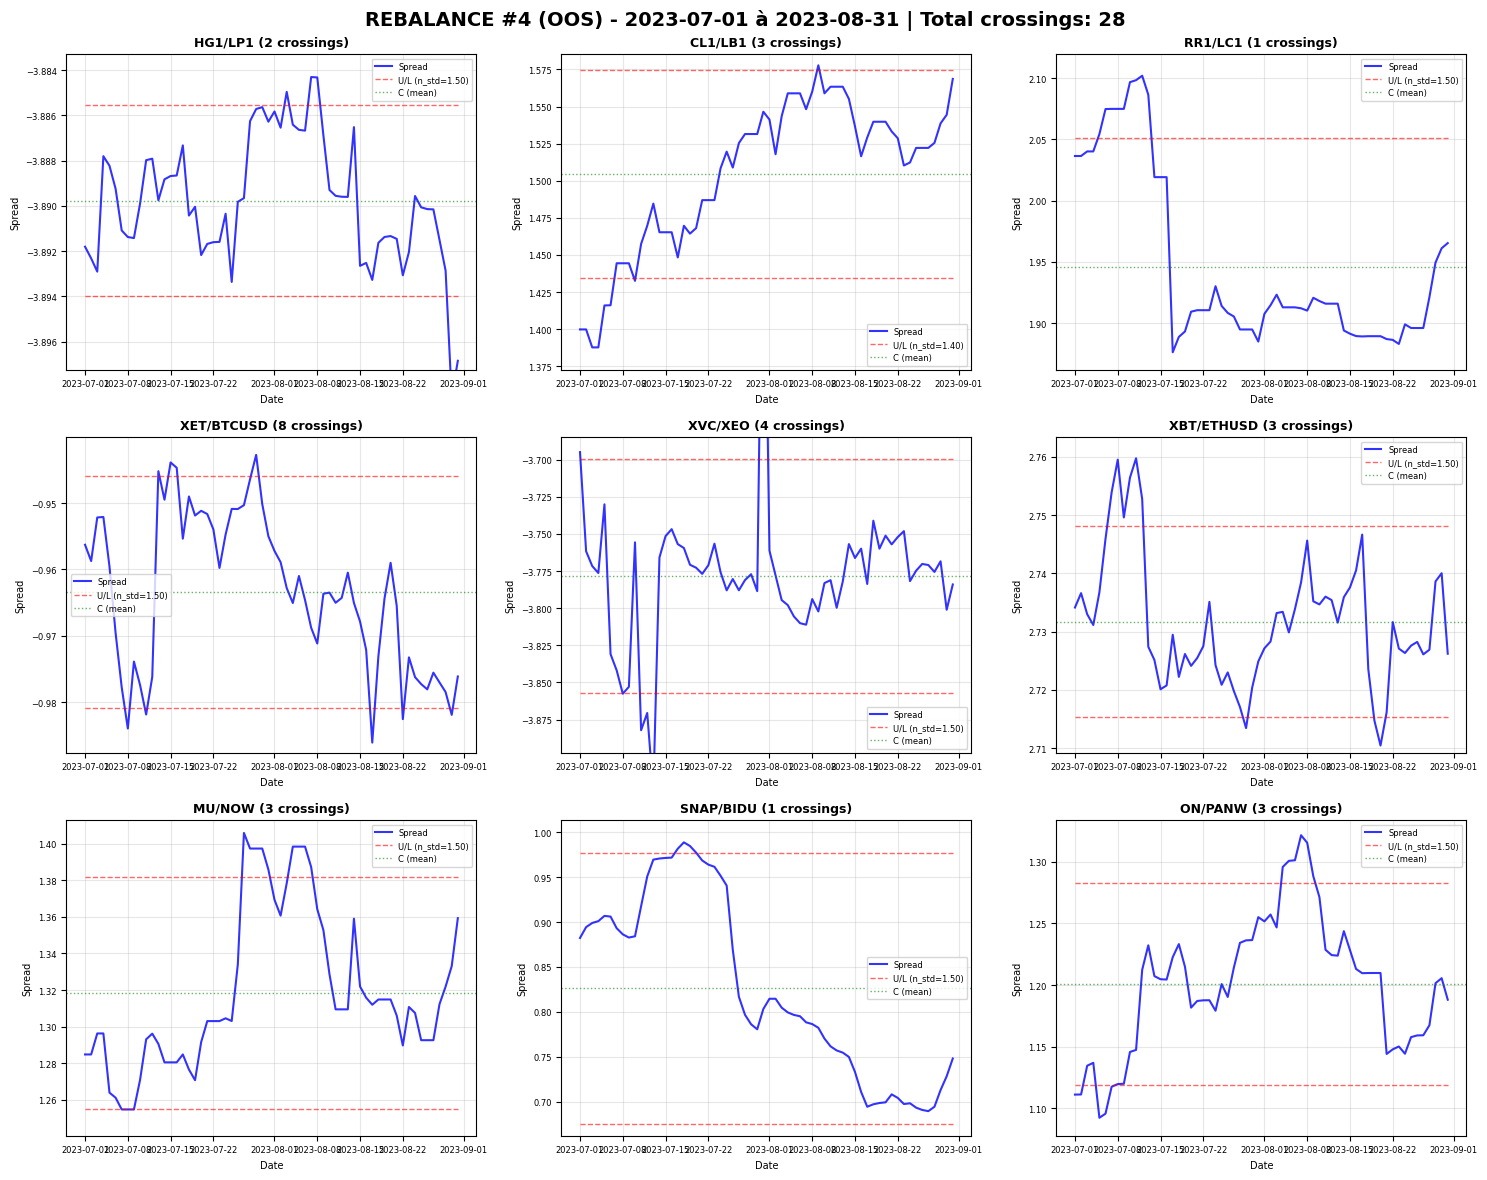

   ✅ 9 paires affichées | 28 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'MSFT US Equity', 'NOW US Equity')

  REBALANCE #5 - 2023-09-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XVC Curncy / XMN Curncy (p=0.0031, HL=4.3)
      - XET Curncy / BTCUSD Curncy (p=0.0047, HL=10.1)
      - XBT Curncy / ETHUSD Curncy (p=0.0093, HL=11.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0016, HL=2.0)
      - CT1 Comdty / LH1 Comdty (p=0.0037, HL=11.9)
      - CL1 Comdty / HO1 Comdty (p=0.0044, HL=10.3)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - ORCL US Equity / LRCX US Equity (p=0.0023, HL=11.3)
      - MU US Equity / SHOP US Equity (p=0.0054, HL=8.1)
      - NFLX U

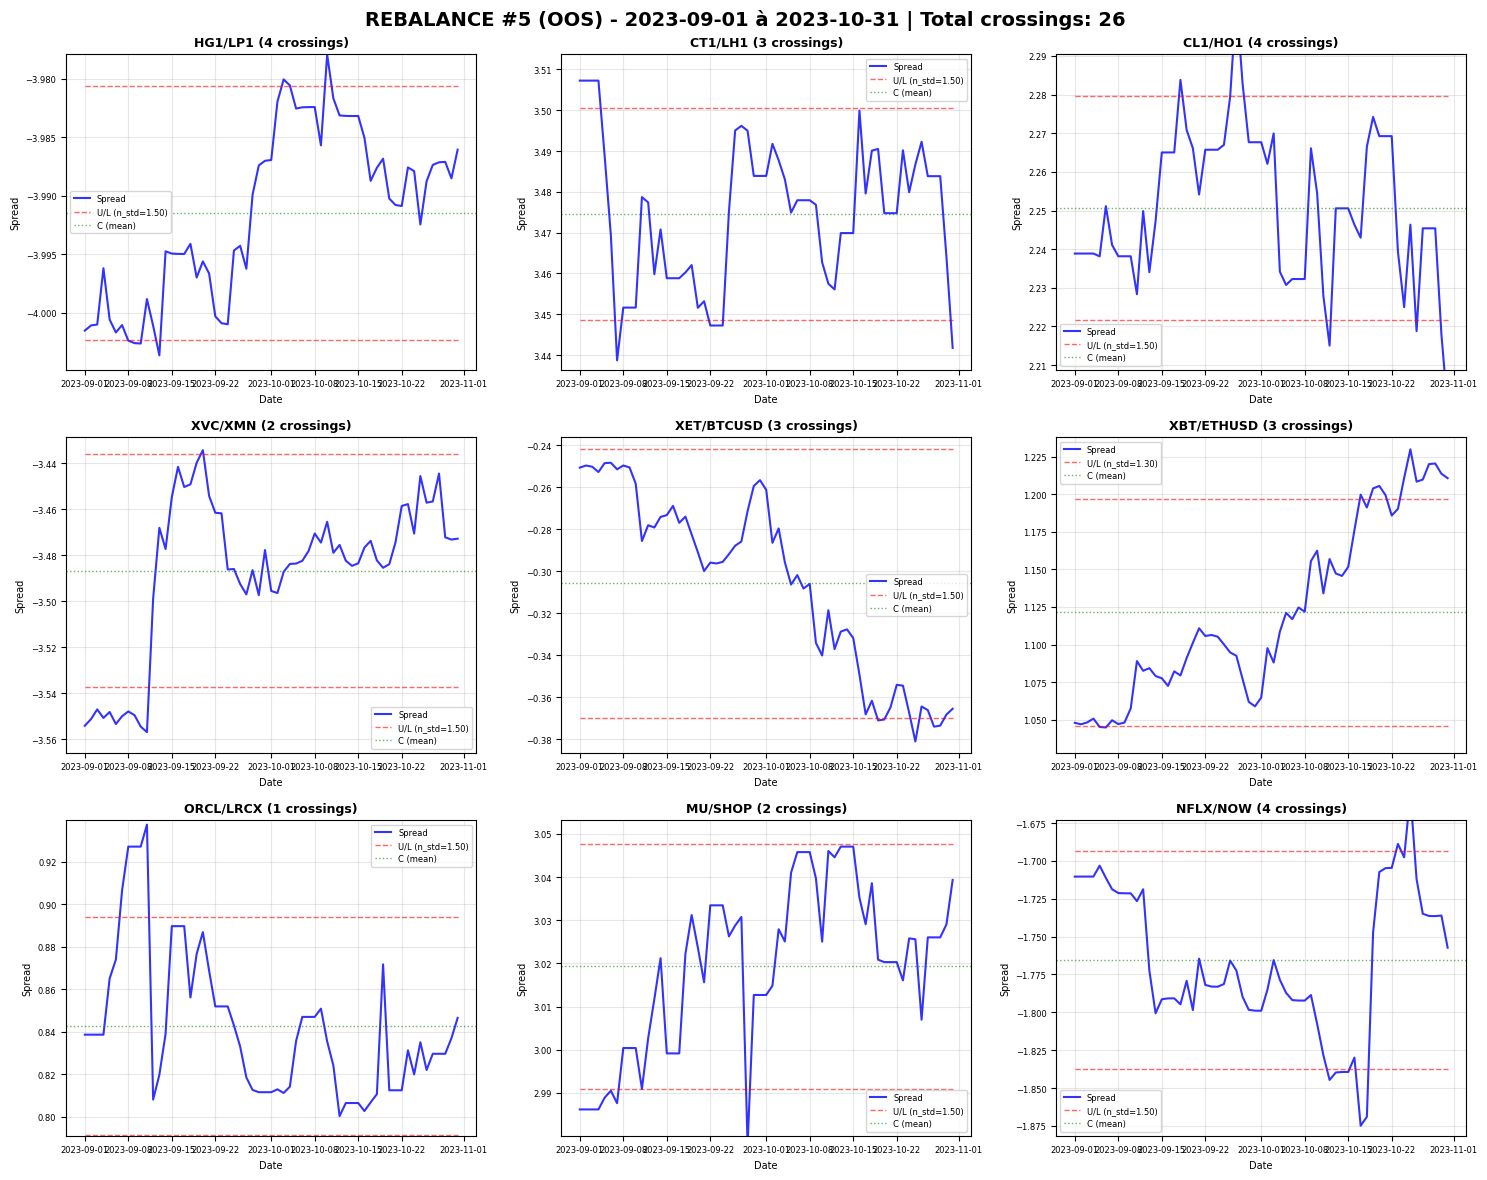

   ✅ 9 paires affichées | 26 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'ON US Equity', 'PANW US Equity')

  REBALANCE #6 - 2023-11-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XVC Curncy / XMN Curncy (p=0.0043, HL=4.3)
      - XDH Curncy / XEO Curncy (p=0.0064, HL=11.1)
      - XBN Curncy / XMK Curncy (p=0.0223, HL=18.4)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - CT1 Comdty / FC1 Comdty (p=0.0001, HL=6.2)
      - LA1 Comdty / LB1 Comdty (p=0.0007, HL=7.6)
      - HG1 Comdty / SM1 Comdty (p=0.0017, HL=7.5)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AMAT US Equity / TEAM US Equity (p=0.0000, HL=6.3)
      - AVGO US Equity / MDB US Equity (p=0.0000, HL=5.5)
      - LRCX US Equity 

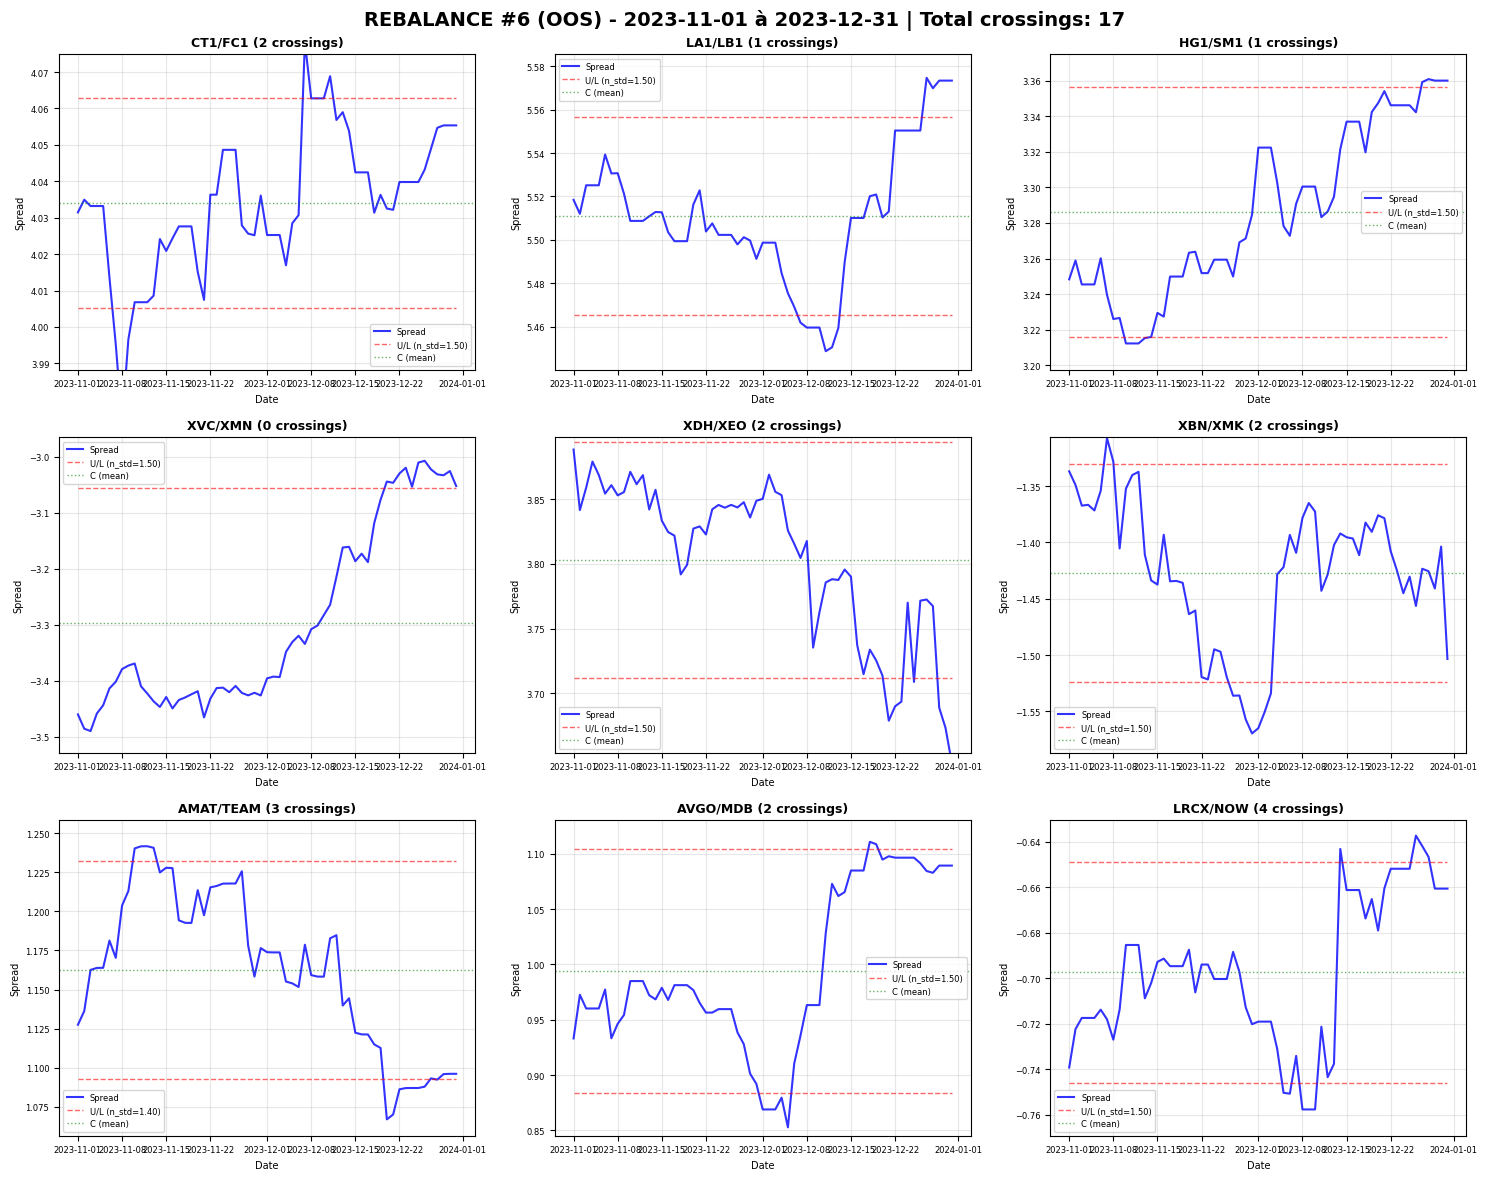

   ✅ 9 paires affichées | 17 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'HG1 Comdty', 'LP1 Comdty')
   Progress: 250/522 dates (47.9%)

  REBALANCE #7 - 2024-01-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 21
   ⚠️  Aucune paire sélectionnée

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / W 1 Comdty (p=0.0007, HL=6.9)
      - NG1 Comdty / PL1 Comdty (p=0.0026, HL=12.0)
      - LA1 Comdty / LB1 Comdty (p=0.0047, HL=9.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AVGO US Equity / AMAT US Equity (p=0.0011, HL=7.3)
      - MU US Equity / ESTC US Equity (p=0.0015, HL=9.1)
      - AMZN US Equity / LRCX US Equity (p=0.0038, HL=5.6)
   ❌ Fermeture: ('tech', 'LRCX US Equity', 'NOW US Equity')
   ❌ Fermeture: ('

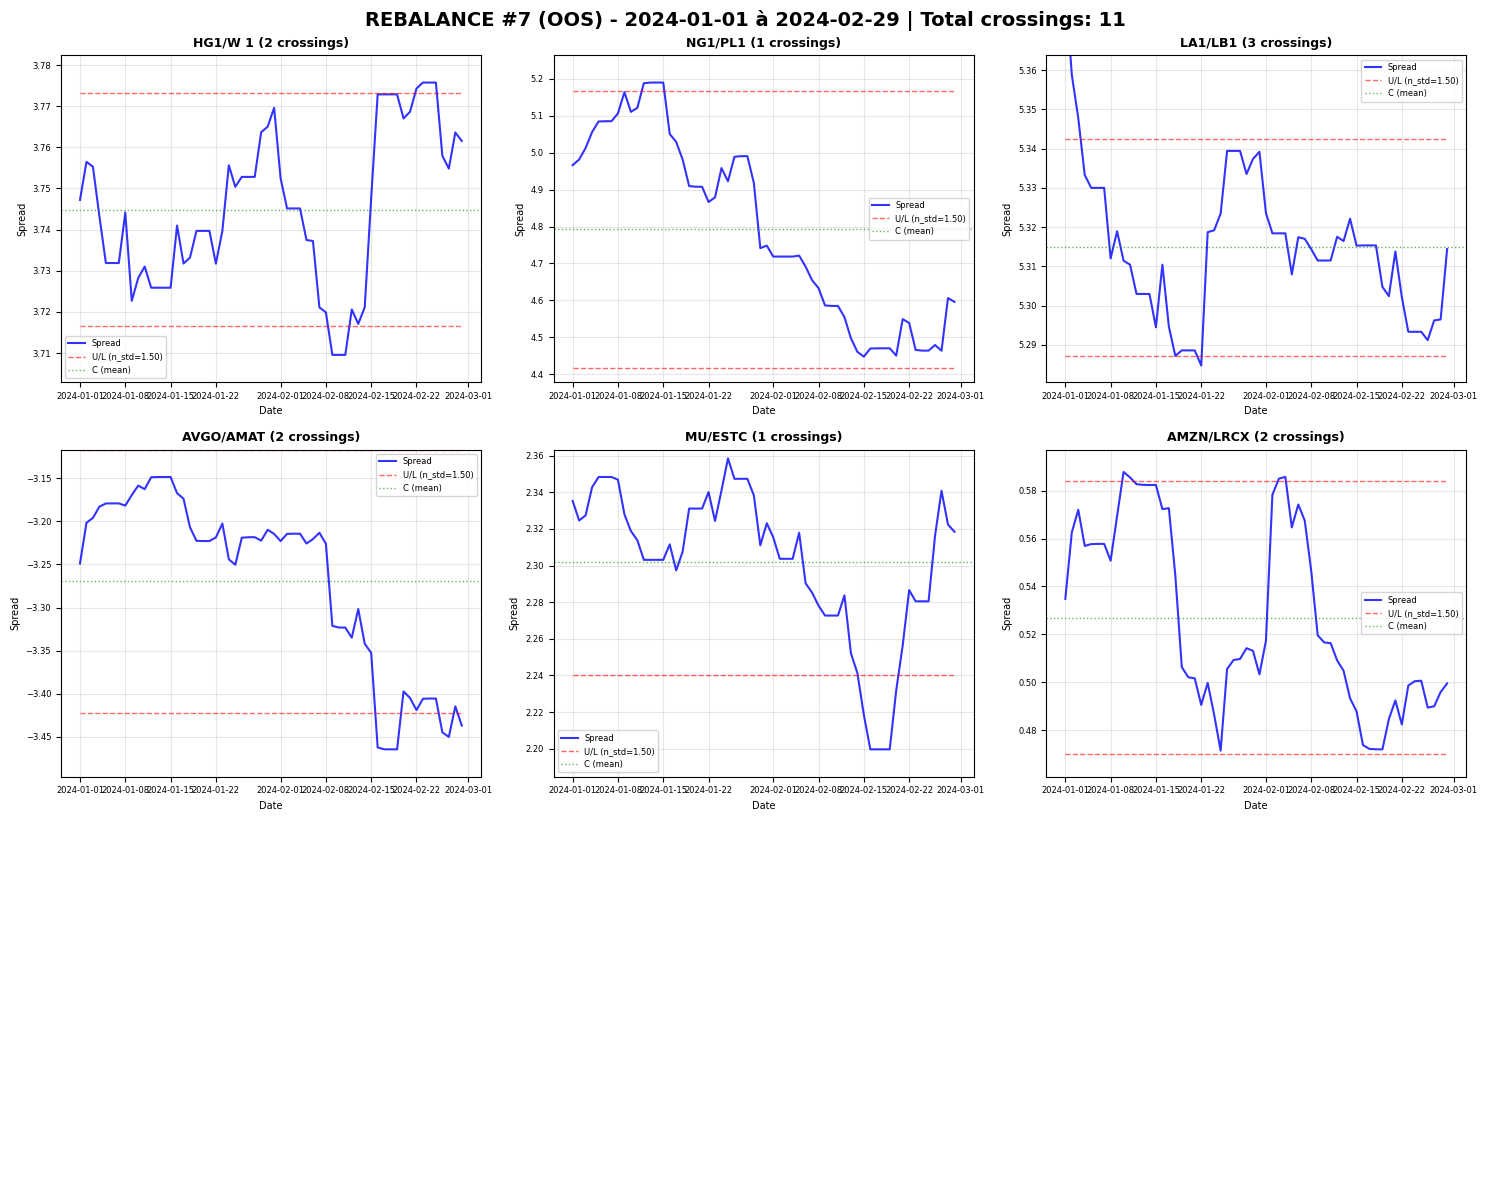

   ✅ 6 paires affichées | 11 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'AMAT US Equity', 'TEAM US Equity')

  REBALANCE #8 - 2024-03-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0079, HL=8.4)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - GC1 Comdty / KC1 Comdty (p=0.0000, HL=8.8)
      - LT1 Comdty / LH1 Comdty (p=0.0002, HL=9.3)
      - LA1 Comdty / LB1 Comdty (p=0.0006, HL=8.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AVGO US Equity / ZS US Equity (p=0.0005, HL=7.4)
      - AMZN US Equity / KLAC US Equity (p=0.0011, HL=7.2)
      - NFLX US Equity / LRCX US Equity (p=0.0041, HL=7.6)
   ❌ Fermeture: ('tech', 'MU US Equity', 'ESTC US Equity')
   ❌ Fer

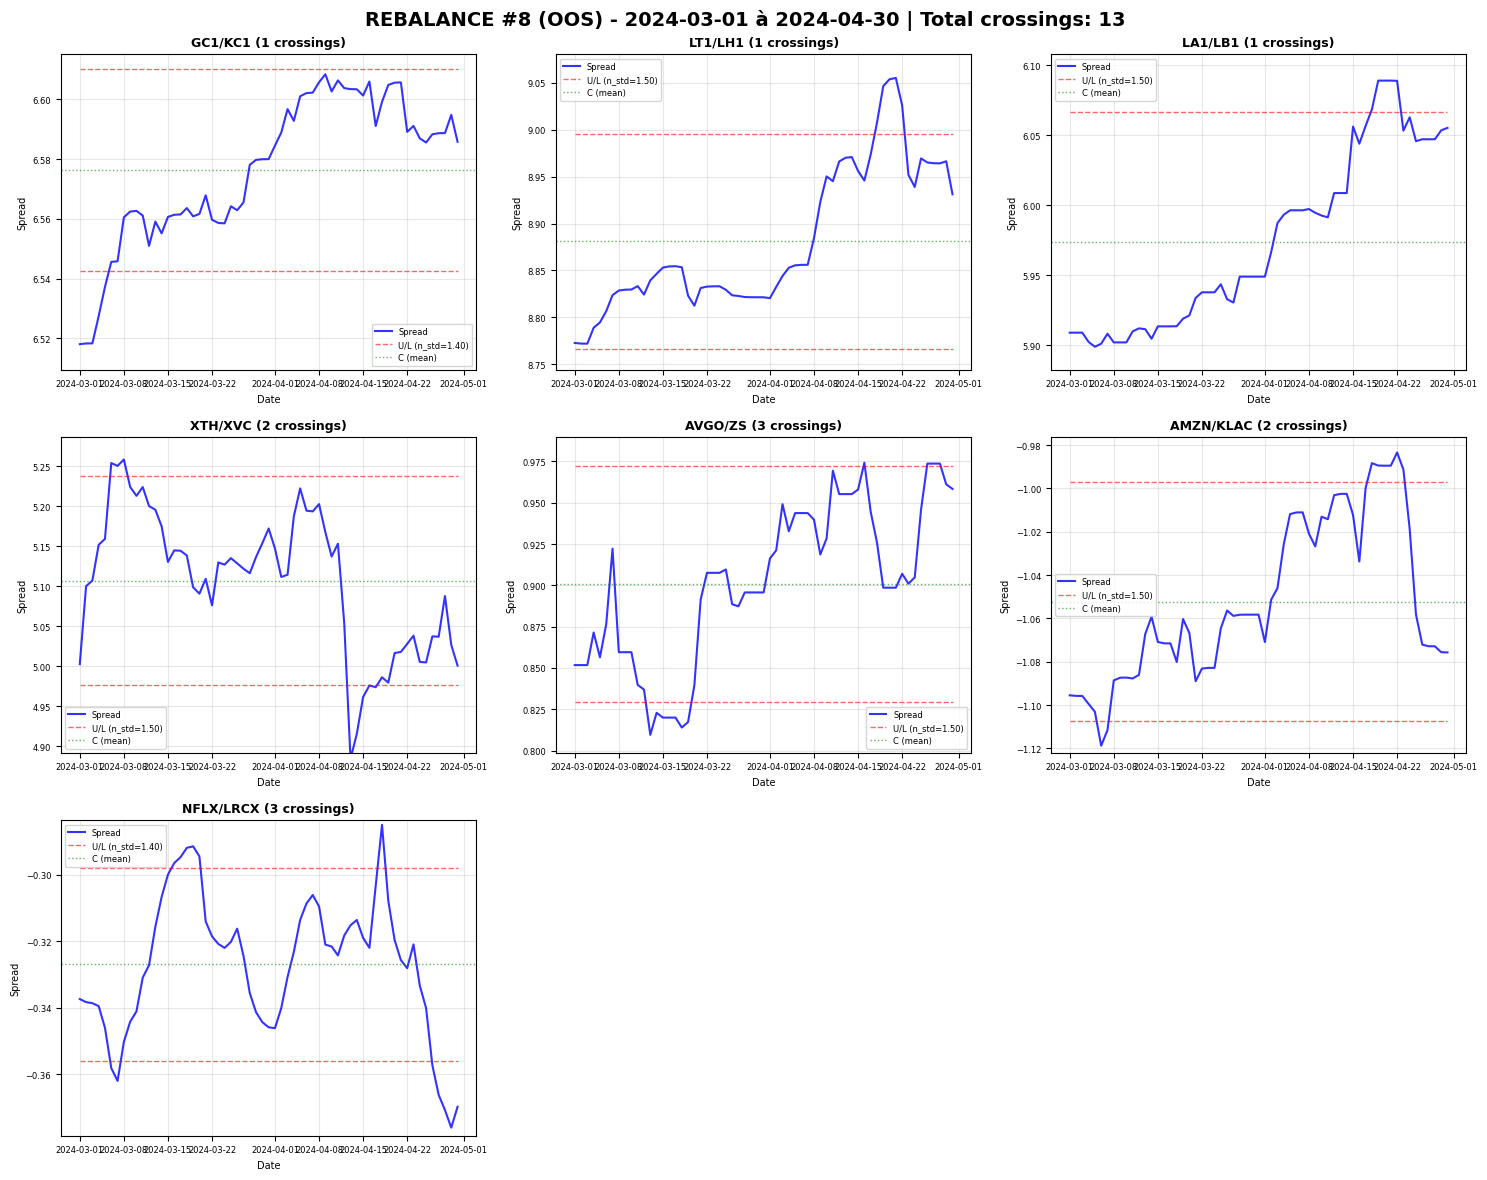

   ✅ 7 paires affichées | 13 crossings de seuils détectés

  REBALANCE #9 - 2024-05-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-05-01 00:00:00 → 2024-04-30 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XTH Curncy / ETHUSD Curncy (p=0.0014, HL=8.0)
      - XET Curncy / ETCUSD Curncy (p=0.0032, HL=8.7)
      - XBN Curncy / XMK Curncy (p=0.0272, HL=20.3)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-05-01 00:00:00 → 2024-04-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - SI1 Comdty / HG1 Comdty (p=0.0003, HL=11.4)
      - LC1 Comdty / FC1 Comdty (p=0.0099, HL=8.4)
      - CL1 Comdty / CO1 Comdty (p=0.0080, HL=5.1)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-05-01 00:00:00 → 2024-04-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - NFLX US Equity / QCOM US Equity (p=0.0001, HL=8.5)
      - AMZN US Equity / KLAC US Equity (p=0.0001, HL=5.6)
      - TXN US Equity / PYPL US Equity (p=0.0005, HL=6.9)
   ⚠️  Déselectio

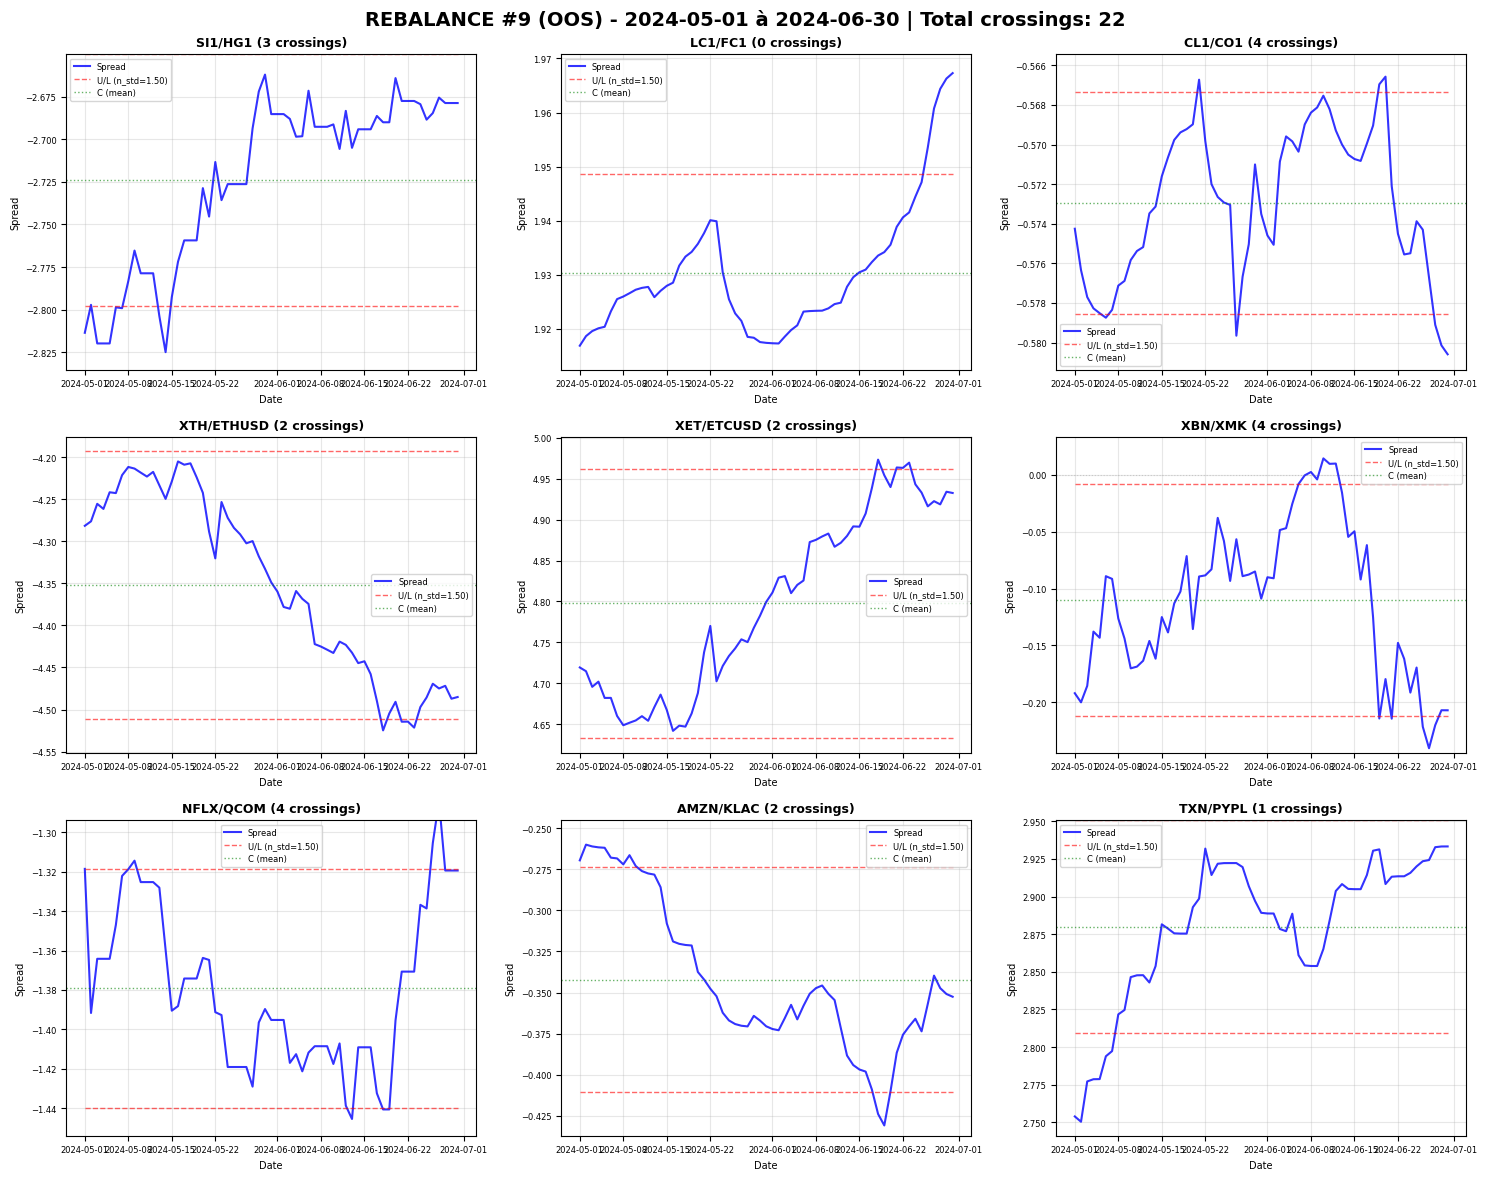

   ✅ 9 paires affichées | 22 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'LA1 Comdty', 'LB1 Comdty')

  REBALANCE #10 - 2024-07-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-07-01 00:00:00 → 2024-06-30 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0263, HL=10.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-07-01 00:00:00 → 2024-06-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - CL1 Comdty / CO1 Comdty (p=0.0002, HL=3.8)
      - PL1 Comdty / LP1 Comdty (p=0.0004, HL=9.7)
      - PA1 Comdty / BO1 Comdty (p=0.0032, HL=8.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-07-01 00:00:00 → 2024-06-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - NFLX US Equity / ASML US Equity (p=0.0006, HL=7.4)
      - AMZN US Equity / LRCX US Equity (p=0.0007, HL=7.1)
      - PANW US Equity / ESTC US Equity (p=0.0011, HL=6.6)
   ⚠️  Déselection: ('commodities', 'SI1 Comdty', 'HG1 Comdty') 

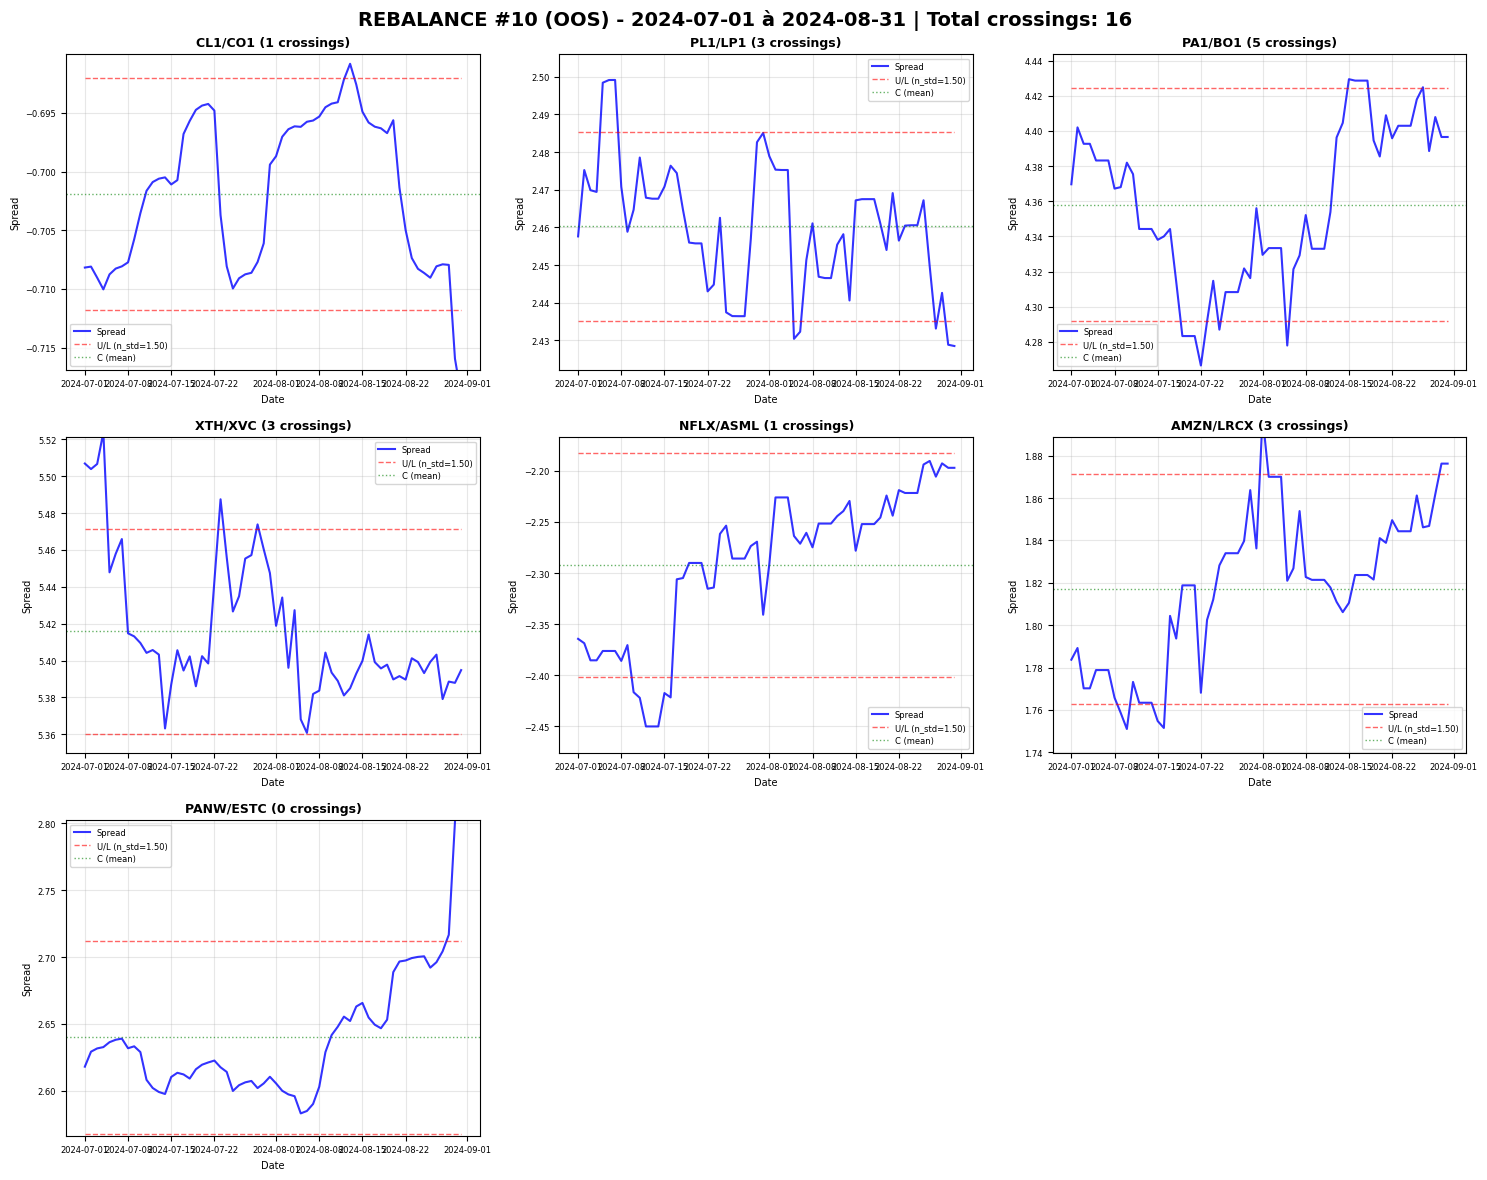

   ✅ 7 paires affichées | 16 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'SI1 Comdty', 'HG1 Comdty')
   ❌ Fermeture: ('crypto', 'XET Curncy', 'ETCUSD Curncy')
   ❌ Fermeture: ('crypto', 'XTH Curncy', 'ETHUSD Curncy')
   ❌ Fermeture: ('tech', 'TXN US Equity', 'PYPL US Equity')

  REBALANCE #11 - 2024-09-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-09-01 00:00:00 → 2024-08-31 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0228, HL=12.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-09-01 00:00:00 → 2024-08-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0006, HL=3.6)
      - PL1 Comdty / LX1 Comdty (p=0.0028, HL=7.3)
      - PA1 Comdty / BO1 Comdty (p=0.0096, HL=8.7)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-09-01 00:00:00 → 2024-08-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - MRVL US Equity / ASML US Equity (p=0.0025, HL=12.5)
     

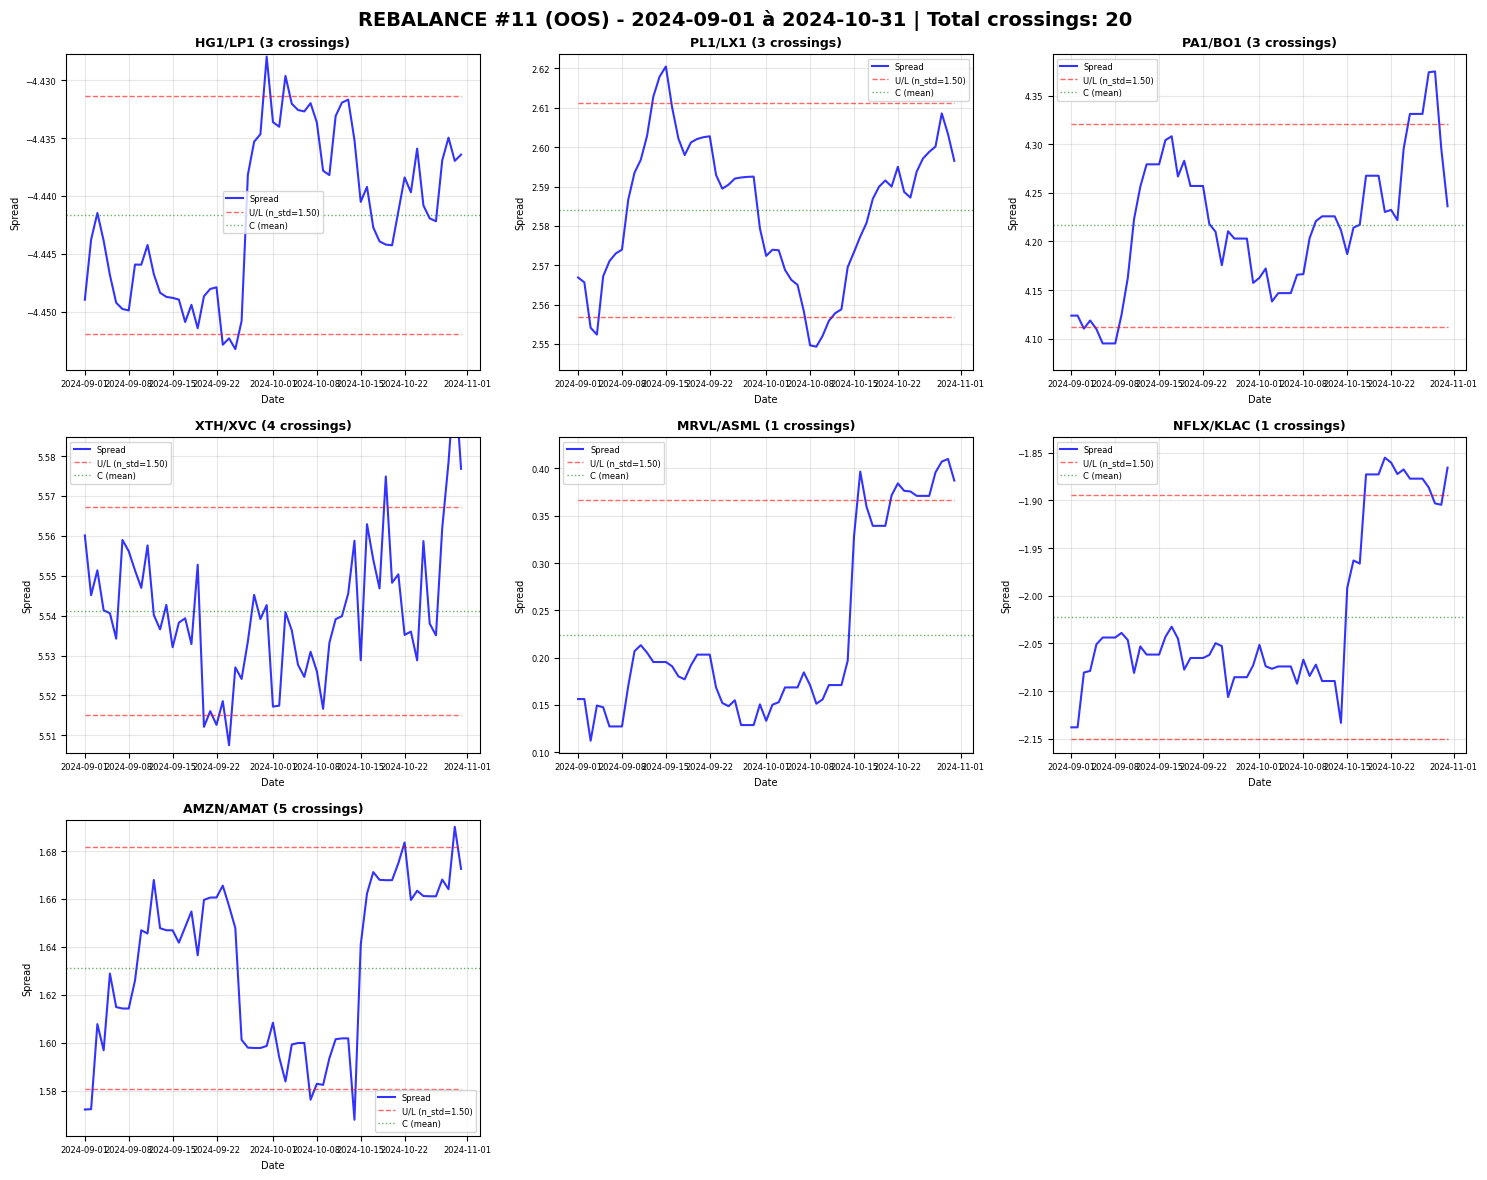

   ✅ 7 paires affichées | 20 crossings de seuils détectés

  REBALANCE #12 - 2024-11-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-11-01 00:00:00 → 2024-10-31 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0271, HL=12.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-11-01 00:00:00 → 2024-10-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0016, HL=3.7)
      - PL1 Comdty / LX1 Comdty (p=0.0109, HL=7.4)
      - PA1 Comdty / O 1 Comdty (p=0.0301, HL=12.4)

🔷 TECH: Sélection de 3 paires
   📊 Période: 2023-11-01 00:00:00 → 2024-10-31 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - IBM US Equity / NOW US Equity (p=0.0010, HL=6.2)
      - NXPI US Equity / SHOP US Equity (p=0.0026, HL=14.4)
      - LRCX US Equity / ROKU US Equity (p=0.0031, HL=10.8)
   ❌ Fermeture: ('tech', 'NFLX US Equity', 'KLAC US Equity')
   ❌ Fermeture: ('tech', 'AMZN US Equity', 'AMAT US Equity')
 

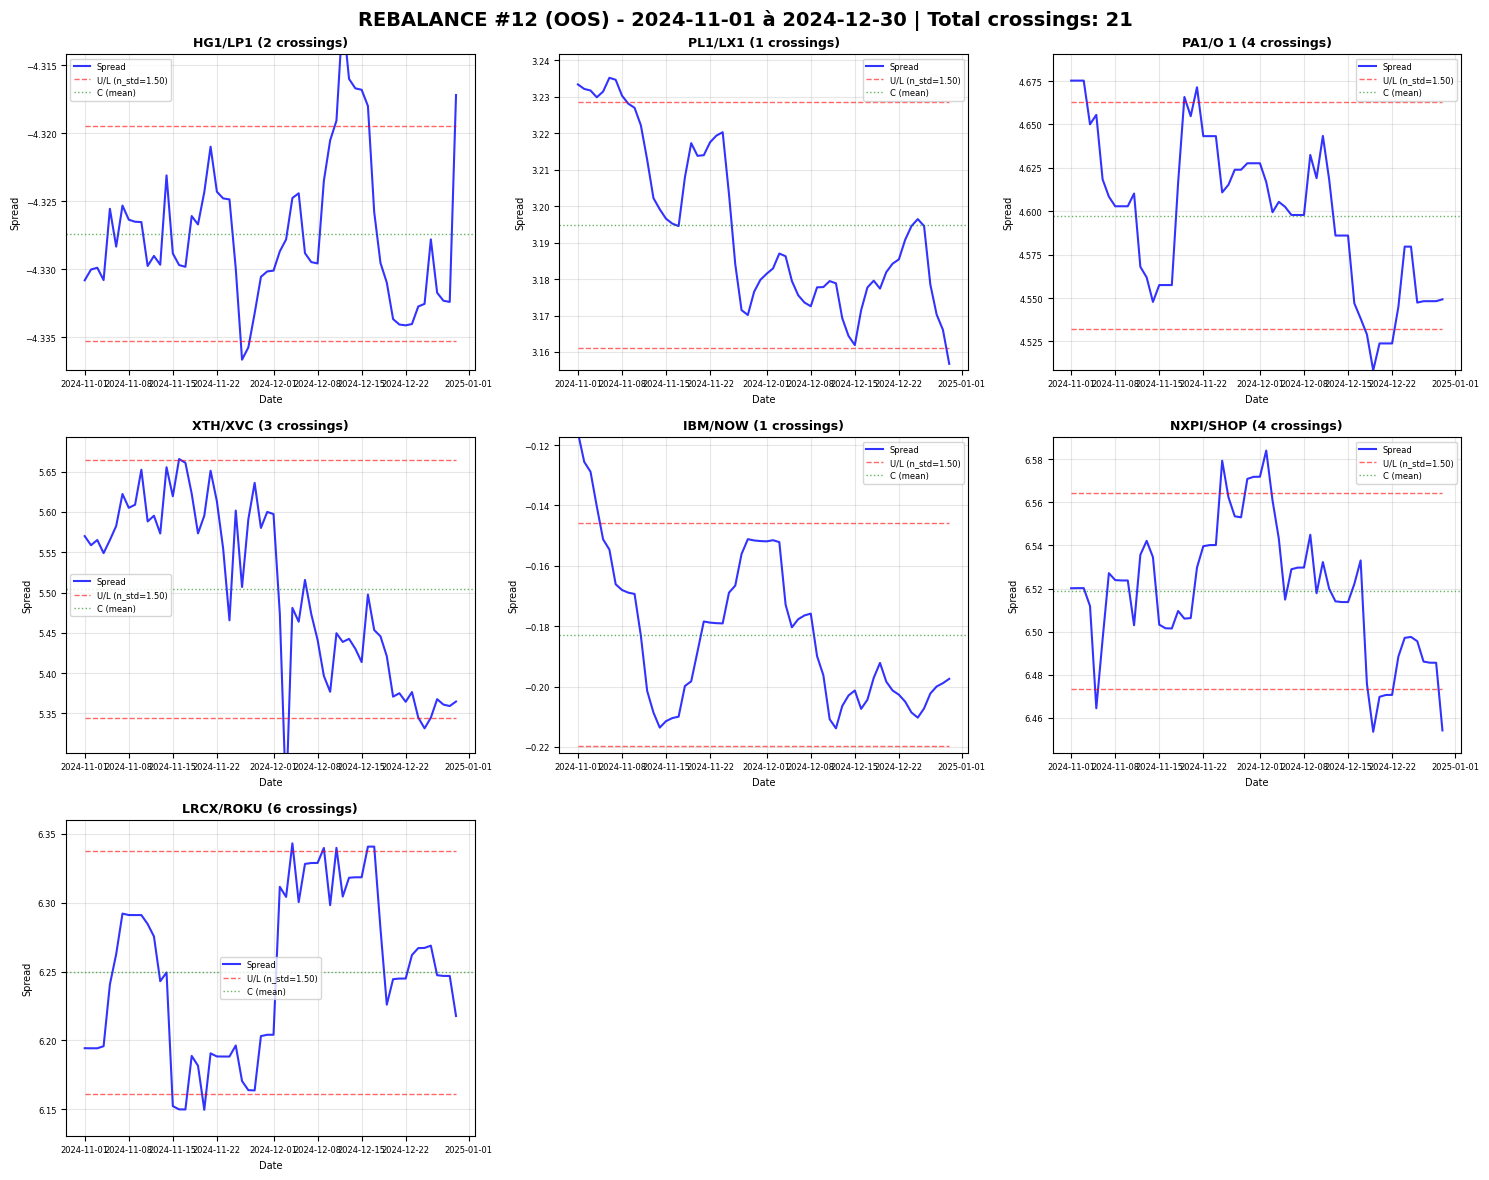

   ✅ 7 paires affichées | 21 crossings de seuils détectés
   Progress: 500/522 dates (95.8%)

✅ Backtest terminé!

  STATISTIQUES DES PAIRES

📊 Nombre total de paires différentes utilisées: 68

🔷 COMMODITIES
   HG1 Comdty / LP1 Comdty │ Sélections:  6x │ Trades:   3
   SB1 Comdty / CC1 Comdty │ Sélections:  2x │ Trades:   3
   CL1 Comdty / CO1 Comdty │ Sélections:  4x │ Trades:   2
   RR1 Comdty / LC1 Comdty │ Sélections:  1x │ Trades:   1
   LA1 Comdty / LB1 Comdty │ Sélections:  3x │ Trades:   1
   SI1 Comdty / HG1 Comdty │ Sélections:  1x │ Trades:   1
   PA1 Comdty / BO1 Comdty │ Sélections:  2x │ Trades:   1
   SI1 Comdty / CC1 Comdty │ Sélections:  1x │ Trades:   0
   SI1 Comdty / LN1 Comdty │ Sélections:  1x │ Trades:   0
   LA1 Comdty / S 1 Comdty │ Sélections:  1x │ Trades:   0
   CL1 Comdty / LB1 Comdty │ Sélections:  1x │ Trades:   0
   CT1 Comdty / LH1 Comdty │ Sélections:  1x │ Trades:   0
   CL1 Comdty / HO1 Comdty │ Sélections:  1x │ Trades:   0
   CT1 Comdty / FC1 Comdt

In [ ]:
# Pour Model 1 (Strat A)
df_portfolio_pnl_1_A = run_portfolio_backtest(
    asset_classes=ASSET_CLASSES,
    backtest_start=BACKTEST_START,
    backtest_end=BACKTEST_END,
    rebalance_freq_months=REBALANCE_FREQ_MONTHS,
    lookback_years=SELECTION_LOOKBACK_YEARS,
    n_pairs_per_class=N_PAIRS_PER_CLASS,
    model="I"  # Strat A (homoscédastique)
)

print(f"\n Résultats du backtest:")
print(f"   Dates: {len(df_portfolio_pnl_1_A)}")
print(f"   PnL moyen par jour: {df_portfolio_pnl_1_A['pnl'].mean():.6f}")
print(f"   Positions moyennes: {df_portfolio_pnl_1_A['n_positions'].mean():.1f}")

## Performance Metrics & Analysis

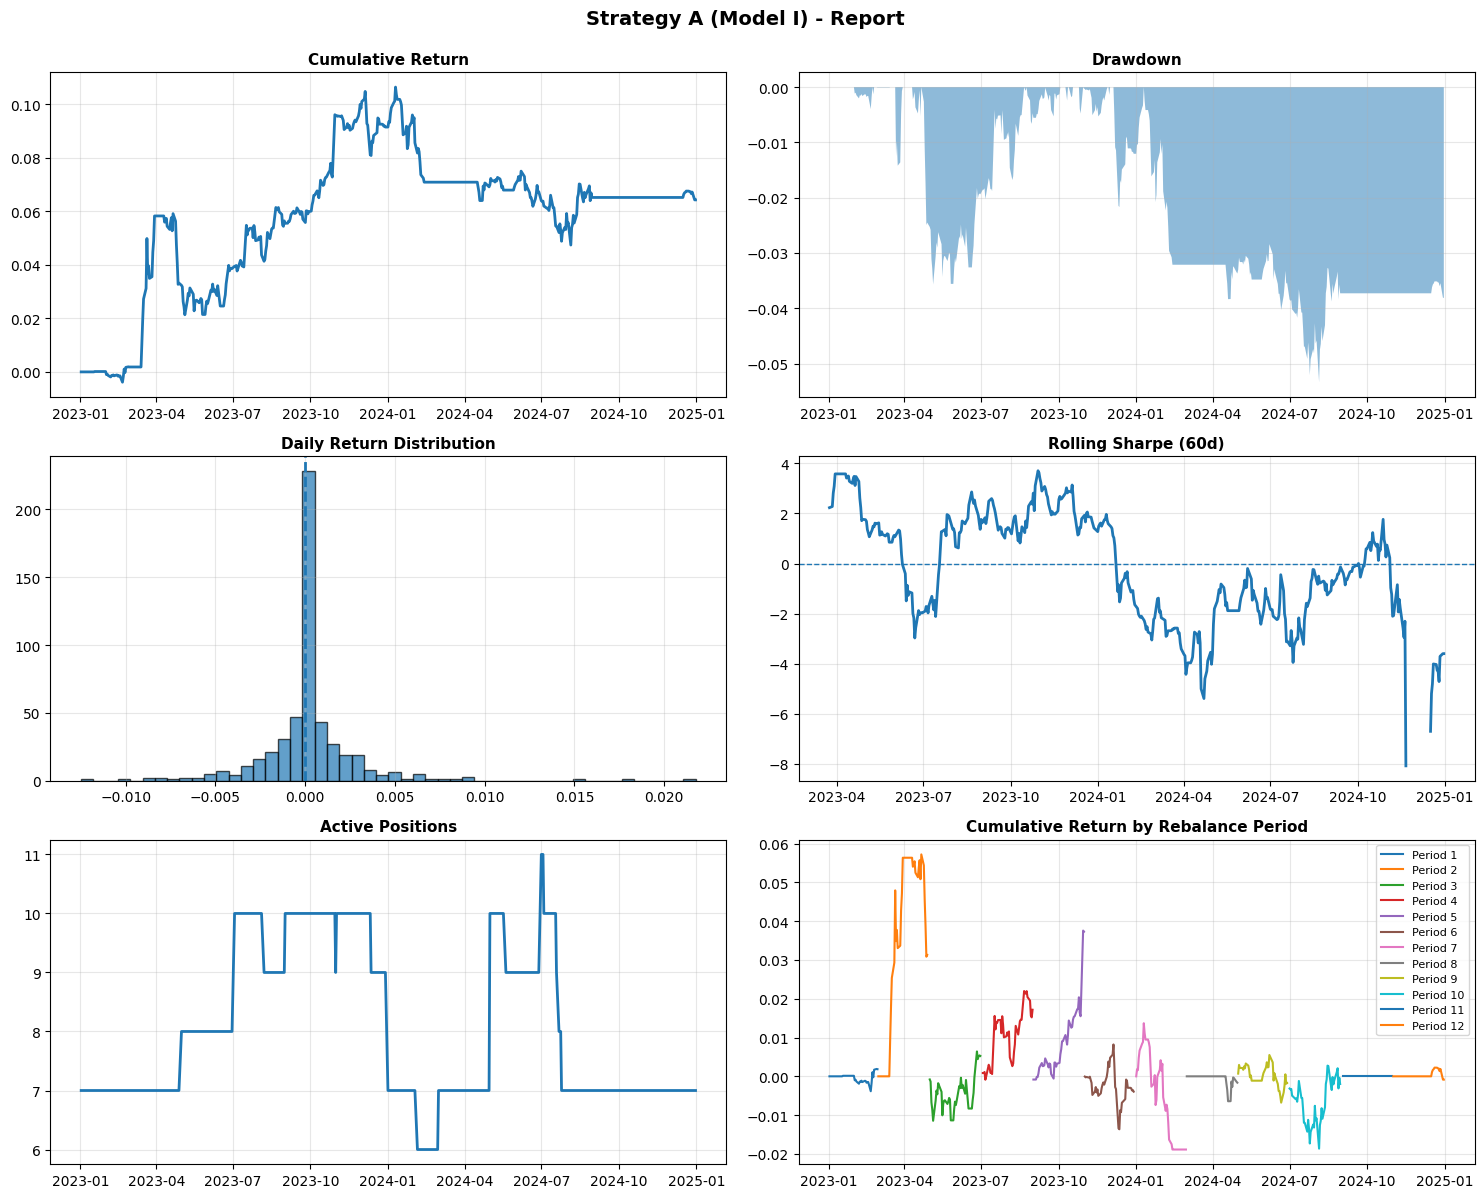

✅ Saved: ../data/pairs_multiasset_A_report.png


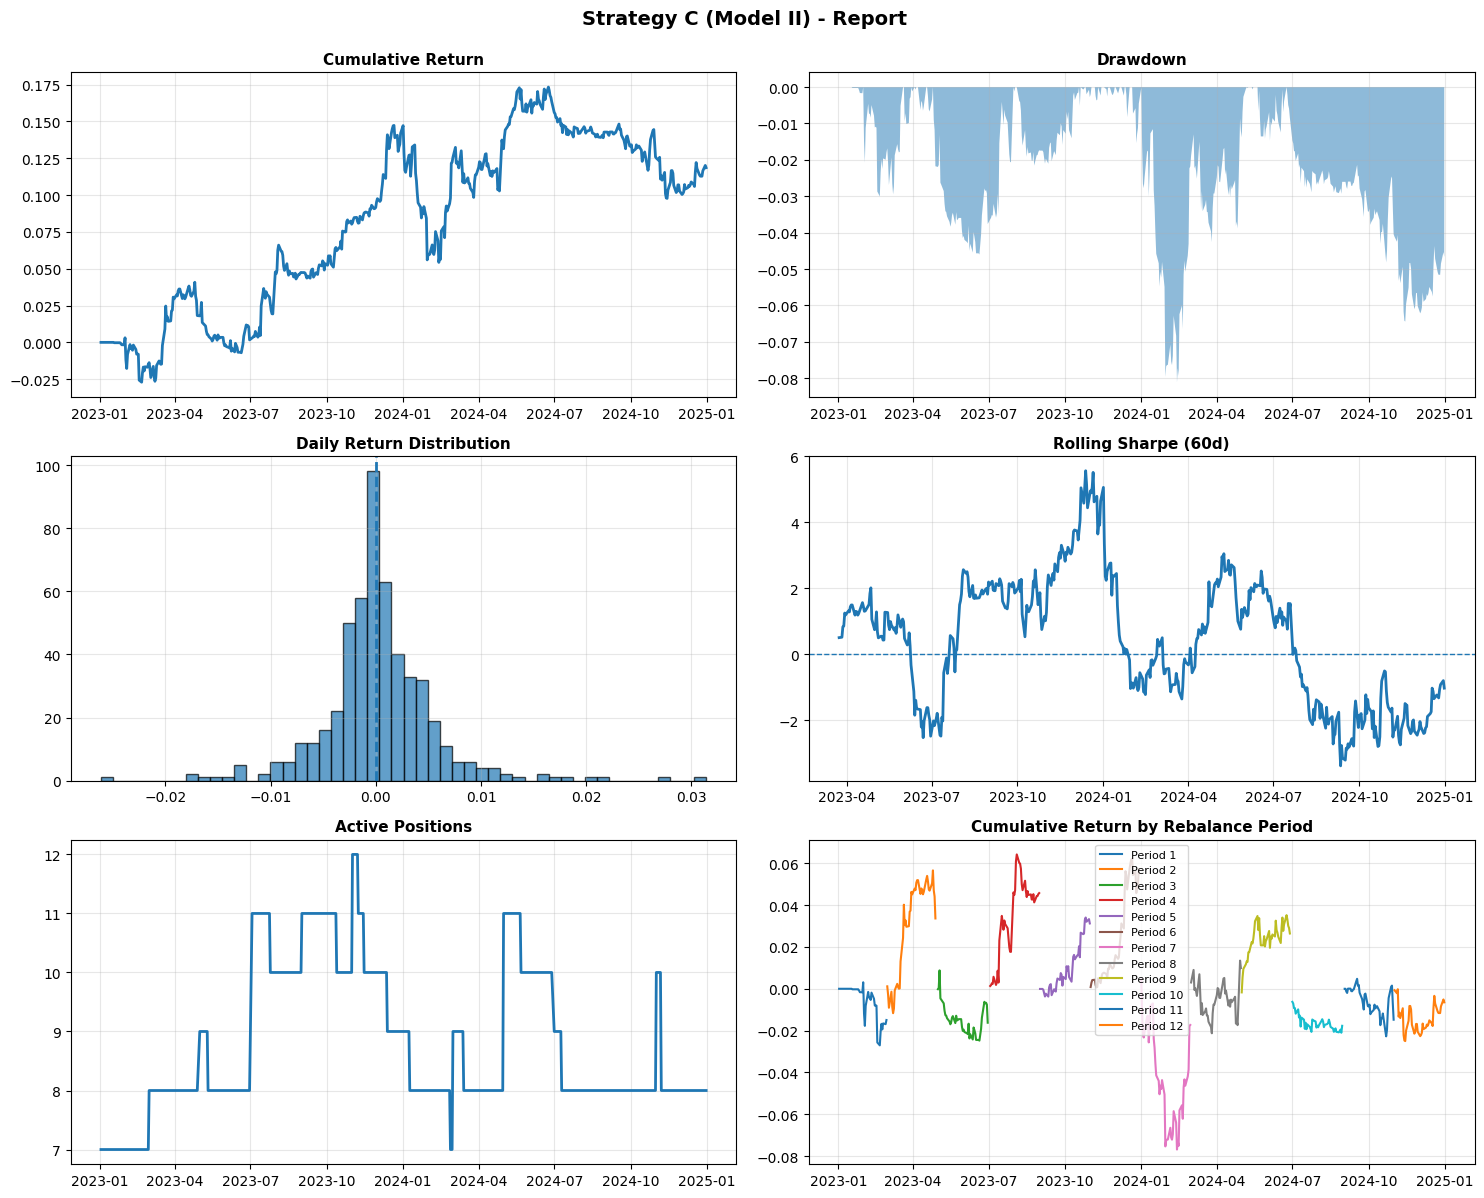

✅ Saved: ../data/pairs_multiasset_C_report.png


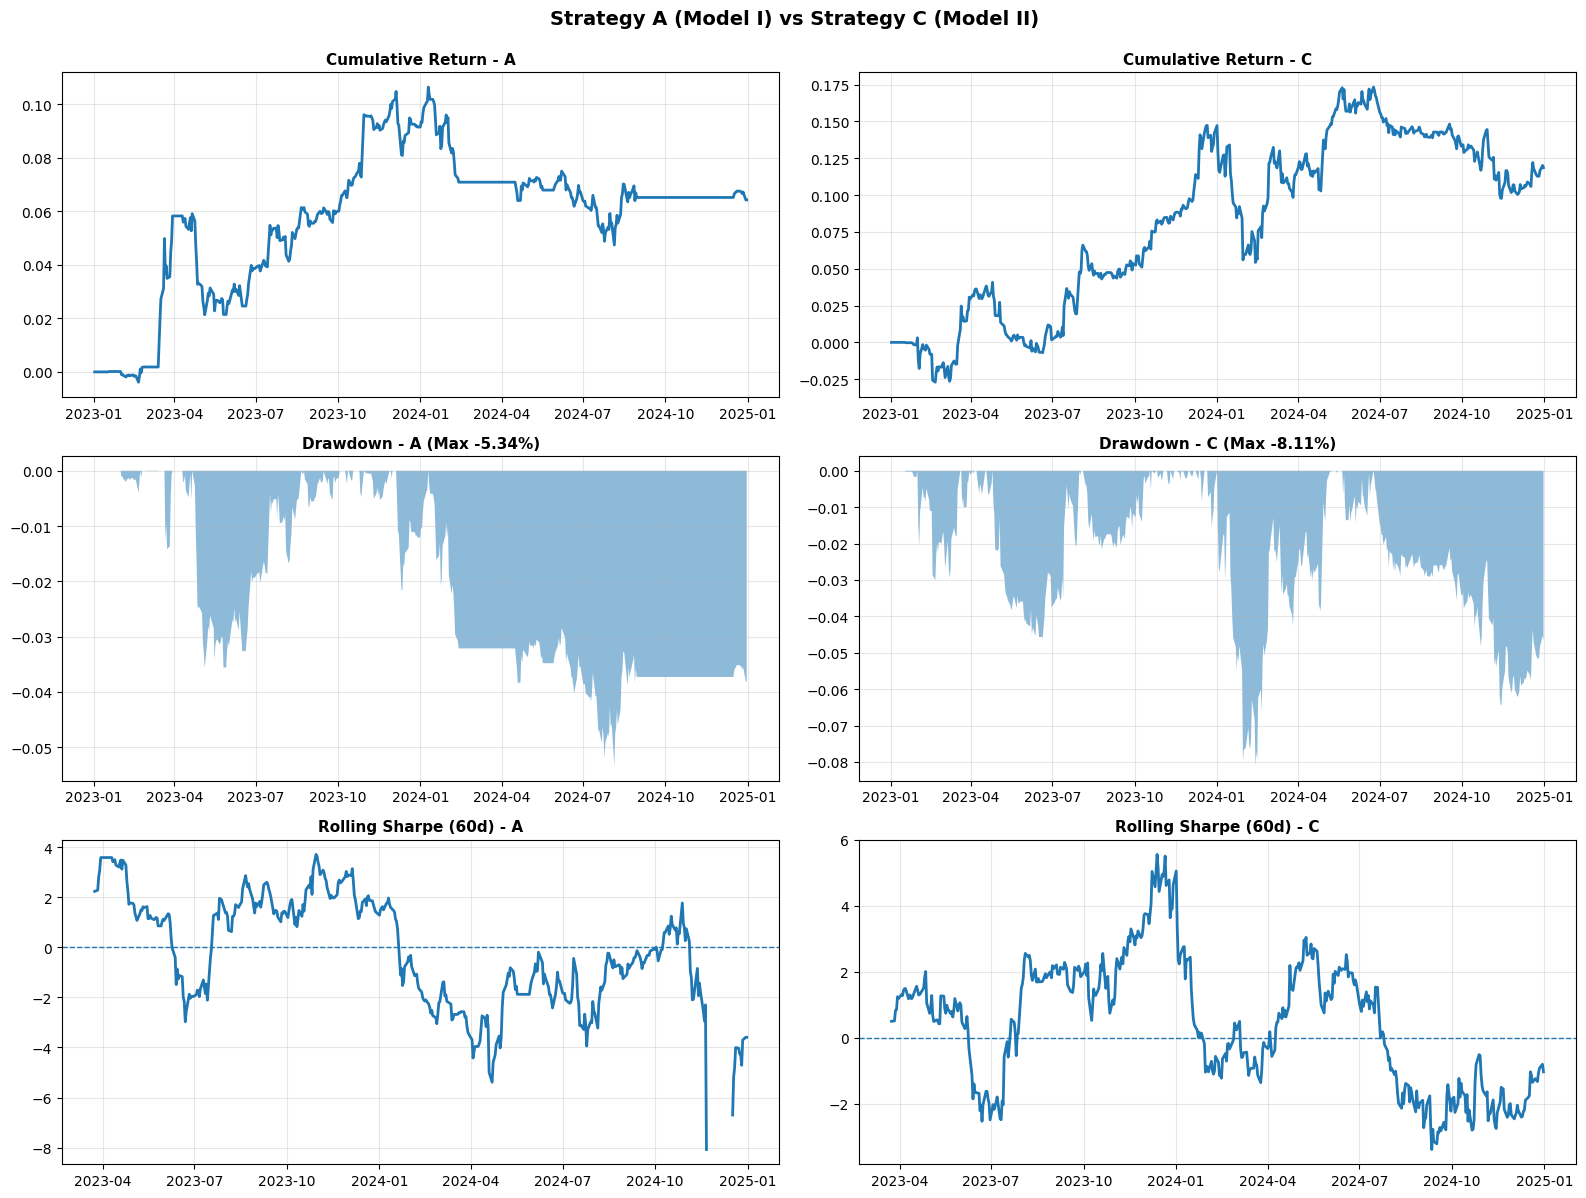

✅ Saved: ../data/pairs_multiasset_A_vs_C.png

                                       CORE METRICS                                       
Total Return                 | A:      6.43%  | C:     11.86%
Annualized Return            | A:      3.05%  | C:      5.56%
Annualized Volatility        | A:      4.28%  | C:      8.32%
Sharpe                       | A:     0.2464  | C:     0.4277
Max Drawdown                 | A:     -5.34%  | C:     -8.11%

                            ACTIVE MGMT (COURSE FLAM) — C vs A                            
IC (weekly, horizon h)                        :         0.1363
Alpha (annualized)                            :          2.68%
Tracking Error (annualized)                   :          8.62%
IR (annualized)                               :         0.3107
Breadth BR (proxy)                            :        18.5000
Breadth method                                : Trade count / year (MAIN)
BR_main (trades/yr)                           :        18.5000
BR_bench 

In [ ]:
# ============================================================
# PERFORMANCE + ACTIVE MANAGEMENT ANALYZER (FLAM-compliant)
# Breadth = trade count / year
# ============================================================

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# Helpers
# ============================================================

def _safe_corr(a: pd.Series, b: pd.Series) -> float:
    joined = pd.concat([a.astype(float), b.astype(float)], axis=1).dropna()
    if joined.shape[0] < 3:
        return np.nan
    return float(joined.iloc[:, 0].corr(joined.iloc[:, 1]))

def _max_drawdown_from_wealth(wealth: pd.Series) -> float:
    running_max = wealth.cummax()
    dd = wealth / running_max - 1.0
    return float(dd.min())

def _annualize_return(total_return: float, n_days: int, trading_days: int = 252) -> float:
    if n_days <= 0:
        return np.nan
    years = n_days / trading_days
    if years <= 0:
        return np.nan
    return (1.0 + total_return) ** (1.0 / years) - 1.0

def _annualize_vol(daily_ret: pd.Series, trading_days: int = 252) -> float:
    return float(daily_ret.std(ddof=1) * np.sqrt(trading_days))

def breadth_trade_count(trades_total: float, years: float) -> float:
    """METHOD 3: Breadth = number of trades per year (proxy for independent bets)."""
    if years <= 0:
        return np.nan
    return float(trades_total) / float(years)

# ----- robust formatting -----
def _fmt(v, width=12, dec=4):
    if isinstance(v, (int, float, np.floating)) and np.isfinite(v):
        return f"{v:>{width}.{dec}f}"
    return f"{str(v):>{width}}"

def _fmt_pct(v, width=12, dec=2):
    if isinstance(v, (int, float, np.floating)) and np.isfinite(v):
        return f"{v:>{width}.{dec}%}"
    return f"{str(v):>{width}}"


# ============================================================
# Config
# ============================================================

@dataclass
class AnalyzerConfig:
    rf_annual: float = 0.02
    trading_days: int = 252
    weekly_freq: str = "W-FRI"
    flam_horizon_weeks: int = 1

    # ---- Breadth METHOD 3 (fixed inputs) ----
    years: float = 2.0
    trades_total_main: float = 37.0    # Strategy C total trades
    trades_total_bench: float = 23.0   # Strategy A total trades
    breadth_mode: str = "main"         # "main" (default) or "active" (main-bench)

    # ---- Saving ----
    save_dir: str = "../data"
    prefix: str = "pairs_multiasset"


# ============================================================
# Analyzer
# ============================================================

class PortfolioPerformanceAnalyzer:
    """
    Expects df_strategy with index=dates and columns:
      - pnl: daily return (or daily P&L normalized as a return)
      - rebalance_period (optional)
      - n_positions (optional)
      - forecast (optional) : portfolio forecast signal
    """

    def __init__(self, cfg: AnalyzerConfig):
        self.cfg = cfg

    # ---------------------------
    # Weekly aggregation (course style)
    # ---------------------------
    def make_weekly(self, df: pd.DataFrame) -> pd.DataFrame:
        if "pnl" not in df.columns:
            raise ValueError("df must contain column 'pnl'.")

        out = pd.DataFrame(index=df.index.copy())
        out["ret_d"] = df["pnl"].astype(float)
        out["forecast_d"] = df["forecast"].astype(float) if "forecast" in df.columns else 0.0

        # weekly compounded return
        ret_w = (1.0 + out["ret_d"]).resample(self.cfg.weekly_freq).prod() - 1.0
        forecast_w = out["forecast_d"].resample(self.cfg.weekly_freq).last()

        df_w = pd.DataFrame({"ret_w": ret_w, "forecast_w": forecast_w}).dropna()
        return df_w

    # ---------------------------
    # Core metrics
    # ---------------------------
    def core_metrics(self, df: pd.DataFrame) -> Dict[str, float]:
        r_d = df["pnl"].astype(float).dropna()
        n_days = int(r_d.shape[0])

        wealth = (1.0 + r_d).cumprod()
        total_return = float(wealth.iloc[-1] - 1.0)

        ann_return = _annualize_return(total_return, n_days, self.cfg.trading_days)
        ann_vol = _annualize_vol(r_d, self.cfg.trading_days)

        sharpe = np.nan
        if np.isfinite(ann_vol) and ann_vol > 1e-12:
            sharpe = (ann_return - self.cfg.rf_annual) / ann_vol

        max_dd = _max_drawdown_from_wealth(wealth)

        return {
            "Total Return": total_return,
            "Annualized Return": ann_return,
            "Annualized Volatility": ann_vol,
            "Sharpe": float(sharpe),
            "Max Drawdown": max_dd,
            "N days": float(n_days),
        }

    # ---------------------------
    # Active management metrics (FLAM)
    # ---------------------------
    def active_metrics_flam(self, df_main: pd.DataFrame, df_bench: pd.DataFrame) -> Dict[str, float]:
        main_w = self.make_weekly(df_main)
        bench_w = self.make_weekly(df_bench)

        joined = main_w[["ret_w", "forecast_w"]].join(
            bench_w[["ret_w"]], how="inner", lsuffix="_main", rsuffix="_bench"
        ).dropna()

        # active return weekly
        active_w = joined["ret_w_main"] - joined["ret_w_bench"]

        # alpha & TE weekly -> annual
        alpha_w = float(active_w.mean())
        te_w = float(active_w.std(ddof=1))

        alpha_ann = alpha_w * 52.0
        te_ann = te_w * np.sqrt(52.0)

        ir_ann = alpha_ann / te_ann if te_ann > 1e-12 else 0.0

        # IC = corr(forecast_t, active_{t+h})
        h = int(self.cfg.flam_horizon_weeks)
        ic = _safe_corr(joined["forecast_w"], active_w.shift(-h))

        # ---------------------------
        # Breadth (trade count / year)
        # ---------------------------
        br_main = breadth_trade_count(self.cfg.trades_total_main, self.cfg.years)
        br_bench = breadth_trade_count(self.cfg.trades_total_bench, self.cfg.years)

        if self.cfg.breadth_mode.lower() == "active":
            br = breadth_trade_count(self.cfg.trades_total_main - self.cfg.trades_total_bench, self.cfg.years)
            br_method = "Trade count / year (ACTIVE = main - bench)"
        else:
            br = br_main
            br_method = "Trade count / year (MAIN)"

        # FLAM prediction
        ir_pred = float(ic) * np.sqrt(br) if (np.isfinite(ic) and br > 0) else np.nan
        flam_gap = ir_ann - ir_pred if np.isfinite(ir_pred) else np.nan
        br_implied = (ir_ann / ic) ** 2 if (np.isfinite(ic) and abs(ic) > 1e-12) else np.nan

        return {
            "IC (weekly, horizon h)": float(ic) if np.isfinite(ic) else np.nan,
            "Alpha (annualized)": float(alpha_ann),
            "Tracking Error (annualized)": float(te_ann),
            "IR (annualized)": float(ir_ann),
            "Breadth BR (proxy)": float(br) if np.isfinite(br) else np.nan,
            "Breadth method": br_method,
            "BR_main (trades/yr)": float(br_main) if np.isfinite(br_main) else np.nan,
            "BR_bench (trades/yr)": float(br_bench) if np.isfinite(br_bench) else np.nan,
            "IR predicted by FLAM (IC*sqrt(BR))": float(ir_pred) if np.isfinite(ir_pred) else np.nan,
            "FLAM gap (IR_ann - IR_pred)": float(flam_gap) if np.isfinite(flam_gap) else np.nan,
            "Implied BR from (IR/IC)^2": float(br_implied) if np.isfinite(br_implied) else np.nan,
        }

    # ---------------------------
    # Summary table
    # ---------------------------
    def build_summary_table(self, df_A: pd.DataFrame, df_C: pd.DataFrame, flam: Dict[str, float]) -> pd.DataFrame:
        core_A = self.core_metrics(df_A)
        core_C = self.core_metrics(df_C)

        rows = [
            ("Total Return", core_A["Total Return"], core_C["Total Return"]),
            ("Annualized Return", core_A["Annualized Return"], core_C["Annualized Return"]),
            ("Annualized Volatility", core_A["Annualized Volatility"], core_C["Annualized Volatility"]),
            ("Sharpe", core_A["Sharpe"], core_C["Sharpe"]),
            ("Max Drawdown", core_A["Max Drawdown"], core_C["Max Drawdown"]),
            ("IC (weekly, h=1)", np.nan, flam["IC (weekly, horizon h)"]),
            ("Alpha (annualized)", np.nan, flam["Alpha (annualized)"]),
            ("Tracking Error (annualized)", np.nan, flam["Tracking Error (annualized)"]),
            ("IR (annualized)", np.nan, flam["IR (annualized)"]),
            ("Breadth BR (trades/yr)", np.nan, flam["Breadth BR (proxy)"]),
            ("IR predicted by FLAM", np.nan, flam["IR predicted by FLAM (IC*sqrt(BR))"]),
            ("FLAM gap", np.nan, flam["FLAM gap (IR_ann - IR_pred)"]),
            ("Implied BR (IR/IC)^2", np.nan, flam["Implied BR from (IR/IC)^2"]),
        ]

        df_sum = pd.DataFrame(rows, columns=["Metric", "Strategy A (Model I)", "Strategy C (Model II)"])

        def _winner(metric: str, a: float, c: float) -> str:
            if not (np.isfinite(a) and np.isfinite(c)):
                return ""
            if metric in ["Annualized Volatility", "Max Drawdown"]:
                return "C" if c < a else "A"
            return "C" if c > a else "A"

        df_sum["Winner"] = [
            _winner(r["Metric"], r["Strategy A (Model I)"], r["Strategy C (Model II)"])
            for _, r in df_sum.iterrows()
        ]
        return df_sum

    # ---------------------------
    # Plots
    # ---------------------------
    def plot_strategy_report(self, df: pd.DataFrame, title: str, file_name: str):
        r = df["pnl"].astype(float).fillna(0.0)
        wealth = (1.0 + r).cumprod()
        cum_ret = wealth - 1.0

        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle(title, fontsize=14, fontweight="bold", y=0.995)

        axes[0, 0].plot(cum_ret.index, cum_ret.values, linewidth=2)
        axes[0, 0].set_title("Cumulative Return", fontsize=11, fontweight="bold")
        axes[0, 0].grid(True, alpha=0.3)

        dd = wealth / wealth.cummax() - 1.0
        axes[0, 1].fill_between(dd.index, dd.values, 0, alpha=0.5)
        axes[0, 1].set_title("Drawdown", fontsize=11, fontweight="bold")
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].hist(r.values, bins=50, alpha=0.7, edgecolor="black")
        axes[1, 0].axvline(0, linestyle="--", linewidth=2)
        axes[1, 0].set_title("Daily Return Distribution", fontsize=11, fontweight="bold")
        axes[1, 0].grid(True, alpha=0.3)

        roll = (r.rolling(60).mean() * self.cfg.trading_days - self.cfg.rf_annual) / (
            r.rolling(60).std(ddof=1) * np.sqrt(self.cfg.trading_days)
        )
        axes[1, 1].plot(roll.index, roll.values, linewidth=2)
        axes[1, 1].axhline(0, linestyle="--", linewidth=1)
        axes[1, 1].set_title("Rolling Sharpe (60d)", fontsize=11, fontweight="bold")
        axes[1, 1].grid(True, alpha=0.3)

        if "n_positions" in df.columns:
            axes[2, 0].plot(df.index, df["n_positions"], linewidth=2)
            axes[2, 0].set_title("Active Positions", fontsize=11, fontweight="bold")
            axes[2, 0].grid(True, alpha=0.3)
        else:
            axes[2, 0].axis("off")

        if "rebalance_period" in df.columns:
            for period in sorted(df["rebalance_period"].dropna().unique()):
                mask = df["rebalance_period"] == period
                r_p = r.loc[mask]
                w_p = (1.0 + r_p).cumprod() - 1.0
                axes[2, 1].plot(w_p.index, w_p.values, linewidth=1.5, label=f"Period {int(period)}")
            axes[2, 1].set_title("Cumulative Return by Rebalance Period", fontsize=11, fontweight="bold")
            axes[2, 1].legend(fontsize=8, loc="best")
            axes[2, 1].grid(True, alpha=0.3)
        else:
            axes[2, 1].axis("off")

        plt.tight_layout()
        path = f"{self.cfg.save_dir}/{file_name}"
        plt.show()

    def plot_comparison(self, df_A: pd.DataFrame, df_C: pd.DataFrame, file_name: str):
        rA = df_A["pnl"].astype(float).fillna(0.0)
        rC = df_C["pnl"].astype(float).fillna(0.0)

        wA = (1.0 + rA).cumprod()
        wC = (1.0 + rC).cumprod()
        cumA, cumC = wA - 1.0, wC - 1.0
        ddA, ddC = wA / wA.cummax() - 1.0, wC / wC.cummax() - 1.0

        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle("Strategy A (Model I) vs Strategy C (Model II)", fontsize=14, fontweight="bold", y=0.995)

        axes[0, 0].plot(cumA.index, cumA.values, linewidth=2)
        axes[0, 0].set_title("Cumulative Return - A", fontsize=11, fontweight="bold")
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(cumC.index, cumC.values, linewidth=2)
        axes[0, 1].set_title("Cumulative Return - C", fontsize=11, fontweight="bold")
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].fill_between(ddA.index, ddA.values, 0, alpha=0.5)
        axes[1, 0].set_title(f"Drawdown - A (Max {ddA.min():.2%})", fontsize=11, fontweight="bold")
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].fill_between(ddC.index, ddC.values, 0, alpha=0.5)
        axes[1, 1].set_title(f"Drawdown - C (Max {ddC.min():.2%})", fontsize=11, fontweight="bold")
        axes[1, 1].grid(True, alpha=0.3)

        rollA = (rA.rolling(60).mean() * self.cfg.trading_days - self.cfg.rf_annual) / (
            rA.rolling(60).std(ddof=1) * np.sqrt(self.cfg.trading_days)
        )
        rollC = (rC.rolling(60).mean() * self.cfg.trading_days - self.cfg.rf_annual) / (
            rC.rolling(60).std(ddof=1) * np.sqrt(self.cfg.trading_days)
        )

        axes[2, 0].plot(rollA.index, rollA.values, linewidth=2)
        axes[2, 0].axhline(0, linestyle="--", linewidth=1)
        axes[2, 0].set_title("Rolling Sharpe (60d) - A", fontsize=11, fontweight="bold")
        axes[2, 0].grid(True, alpha=0.3)

        axes[2, 1].plot(rollC.index, rollC.values, linewidth=2)
        axes[2, 1].axhline(0, linestyle="--", linewidth=1)
        axes[2, 1].set_title("Rolling Sharpe (60d) - C", fontsize=11, fontweight="bold")
        axes[2, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        path = f"{self.cfg.save_dir}/{file_name}"
        plt.show()


# ============================================================
# RUN EVERYTHING
# ============================================================

def run_full_report(
    df_portfolio_pnl_1_A: pd.DataFrame,
    df_portfolio_pnl_2_C: pd.DataFrame,
    rf_annual: float = 0.02,
    save_dir: str = "../data",
    prefix: str = "pairs_multiasset",
    years: float = 2.0,
    trades_total_C: float = 37.0,   # Strategy C
    trades_total_A: float = 23.0,   # Strategy A (benchmark)
    breadth_mode: str = "main",     # "main" or "active"
) -> Tuple[pd.DataFrame, Dict[str, float], Dict[str, float], Dict[str, float]]:

    cfg = AnalyzerConfig(
        rf_annual=rf_annual,
        save_dir=save_dir,
        prefix=prefix,
        years=years,
        trades_total_main=trades_total_C,
        trades_total_bench=trades_total_A,
        breadth_mode=breadth_mode,
    )
    ana = PortfolioPerformanceAnalyzer(cfg)

    core_A = ana.core_metrics(df_portfolio_pnl_1_A)
    core_C = ana.core_metrics(df_portfolio_pnl_2_C)
    flam = ana.active_metrics_flam(df_portfolio_pnl_2_C, df_portfolio_pnl_1_A)

    df_summary = ana.build_summary_table(df_portfolio_pnl_1_A, df_portfolio_pnl_2_C, flam)
    df_summary.to_csv(f"{save_dir}/{prefix}_summary.csv", index=False)

    ana.plot_strategy_report(df_portfolio_pnl_1_A, "Strategy A (Model I) - Report", f"{prefix}_A_report.png")
    ana.plot_strategy_report(df_portfolio_pnl_2_C, "Strategy C (Model II) - Report", f"{prefix}_C_report.png")
    ana.plot_comparison(df_portfolio_pnl_1_A, df_portfolio_pnl_2_C, f"{prefix}_A_vs_C.png")

    # ----------------------------
    # PRINTS (rounded + robust)
    # ----------------------------
    print("\n" + "=" * 90)
    print("CORE METRICS".center(90))
    print("=" * 90)

    core_keys = ["Total Return", "Annualized Return", "Annualized Volatility", "Sharpe", "Max Drawdown"]
    for k in core_keys:
        if k in {"Total Return", "Annualized Return", "Annualized Volatility", "Max Drawdown"}:
            a = _fmt_pct(core_A.get(k, np.nan), width=10, dec=2)
            c = _fmt_pct(core_C.get(k, np.nan), width=10, dec=2)
            print(f"{k:<28} | A: {a}  | C: {c}")
        else:
            a = _fmt(core_A.get(k, np.nan), width=10, dec=4)
            c = _fmt(core_C.get(k, np.nan), width=10, dec=4)
            print(f"{k:<28} | A: {a}  | C: {c}")

    print("\n" + "=" * 90)
    print("ACTIVE MGMT (COURSE FLAM) — C vs A".center(90))
    print("=" * 90)

    flam_keys = [
        "IC (weekly, horizon h)",
        "Alpha (annualized)",
        "Tracking Error (annualized)",
        "IR (annualized)",
        "Breadth BR (proxy)",
        "Breadth method",
        "BR_main (trades/yr)",
        "BR_bench (trades/yr)",
        "IR predicted by FLAM (IC*sqrt(BR))",
        "FLAM gap (IR_ann - IR_pred)",
        "Implied BR from (IR/IC)^2",
    ]

    for k in flam_keys:
        v = flam.get(k, np.nan)
        if k in {"Alpha (annualized)", "Tracking Error (annualized)"}:
            s = _fmt_pct(v, width=14, dec=2)
        elif k != "Breadth method":
            s = _fmt(v, width=14, dec=4)
        else:
            s = f"{str(v):>14}"
        print(f"{k:<45} : {s}")

    return df_summary.round(3), core_A, core_C, flam


# ============================================================
# Example call (with your fixed totals)
# ============================================================

df_summary, core_A, core_C, flam = run_full_report(
    df_portfolio_pnl_1_A=df_portfolio_pnl_1_A,
    df_portfolio_pnl_2_C=df_portfolio_pnl_2_C,
    rf_annual=0.02,
    save_dir="../data",
    prefix="pairs_multiasset",
    years=2.0,            # ou len(df_portfolio_pnl_2_C)/252
    trades_total_C=37.0,
    trades_total_A=23.0,
    breadth_mode="main",
)
